In [1]:
library(ggplot2)
library(IRdisplay)
library(XAItest)

a <- function(x,y){
    options(repr.plot.width=x, repr.plot.height=y)
}

a(10,5)




In [2]:
options(warn=-1)


In [3]:
list.files("data/scen_ds/")

[1] "classif_bimod.txt"   "classif_circle.txt"  "classif_diffVar.txt"
[4] "classif_relVar.txt"  "regress_parab.txt"   "regress_sinus.txt"

In [4]:
df1 <- read.table("data/scen_ds/classif_diffVar.txt")
df1_short <- df1[,setdiff(colnames(df1), c("diff_distrib01", "diff_distrib02"))]
df2 <- read.table("data/scen_ds/classif_bimod.txt")
df2_short <- df2[,setdiff(colnames(df2), c("diff_distrib01", "diff_distrib02"))]
df3 <- read.table("data/scen_ds/classif_relVar.txt")
df3_short <- df3[,setdiff(colnames(df3), c("diff_distrib01", "diff_distrib02"))]
df4 <- read.table("data/scen_ds/classif_circle.txt")
df4_short <- df4[,setdiff(colnames(df4), c("diff_distrib01", "diff_distrib02"))]
df5 <- read.table("data/scen_ds/regress_parab.txt")
df6 <- read.table("data/scen_ds/regress_sinus.txt")

df1[1:3,1:3]
df2[1:3,1:3]
df3[1:3,1:3]
df4[1:3,1:3]
df5[1:3,1:3]
df6[1:3,1:3]

,y,norm_noise01,norm_noise02
,<chr>,<dbl>,<dbl>
1,A,-1.876532,8.1736207
2,A,-12.699134,-1.9675857
3,A,-12.542217,0.8717875


,y,norm_noise01,norm_noise02
,<chr>,<dbl>,<dbl>
1,A,-5.204427,1.2724080
2,A,2.225210,0.9637928
3,A,-3.955613,-0.8847515


,y,norm_noise01,norm_noise02
,<chr>,<dbl>,<dbl>
1,A,-4.206335,-3.381436
2,A,6.004028,-5.695923
3,A,8.804386,-7.013112


,y,norm_noise01,norm_noise02
,<chr>,<dbl>,<dbl>
1,A,7.612869,-6.234358
2,A,3.925875,-11.568892
3,A,2.375938,-7.093338


,y,norm_noise01,norm_noise02
,<dbl>,<dbl>,<dbl>
1,7.973836,4.847559,4.957615
2,7.938576,4.530617,8.400693
3,7.949509,6.306884,8.943331


,y,norm_noise01,norm_noise02
,<dbl>,<dbl>,<dbl>
1,3.7460292,6.611315,1.063514
2,0.2167224,4.099210,11.770437
3,-4.5046347,-4.031004,3.714968


In [14]:
categ = "y"
data <- df1
# Assuming df1 is your data frame and 'categ' is the target column name (as a string)
# Example (if you need to simulate data, uncomment the next lines):
# set.seed(123)
# n <- 200   # number of observations
# p <- 5     # number of predictor variables
# X <- data.frame(matrix(rnorm(n * p), nrow = n))
# names(X) <- paste0("X", 1:p)
# df1 <- data.frame(y = with(X, 3 * X1 - 2 * X2 + rnorm(n)), X)
# categ <- "y"

# 1. Fit Random Forest model on the original data using the target variable 'categ'
fctParamFIPV <- function(data, categ="y", modelType="default", ml_algo="rf", algo_options=list(),
                fi_algo="accuracy", fi_transfo="none",pv_algo="pimp", adjMethod="bonferroni",
                n_perm=100, n_probes=10, shap_nsim=100, verbose=0){
    
    if (!modelType %in% c("classification", "regression", "default")){
        stop("The modelType must be a 'classification',
                    'regression' or 'default'")
    }
    if (modelType == "default"){
        if (is(data[[categ]], "character")){
            modelType <- "classification"
        }
        if (is.numeric(data[[categ]])){
            modelType <- "regression"
        }
    }
    computeTimes <- list()
    predictor_names <- setdiff(names(data), categ)
    data[,setdiff(colnames(data), "y")] <- scale(data[,setdiff(colnames(data), "y")])
    data <- data[sample(1:nrow(data)),]

    jitter_ratio <- 0.00001

    if (modelType == "classification"){
        data[[categ]] <- as.factor(data[[categ]])
    }

    getDTGini <- function(data, categ){
        my_method <- "class"
        if (modelType == "regression"){
            my_method <- "anova"
        }
        my_model <- rpart::rpart(as.formula(paste(categ, "~ .")), data = data, method = my_method)
        orig_importance <- my_model$variable.importance
        orig_importance <- orig_importance[setdiff(colnames(data), categ)]
        orig_importance[is.na(orig_importance)] <- 0
        return(orig_importance)
    }
    getDTShapValues <- function(data, categ){
        my_method <- "class"
        if (modelType == "regression"){
            my_method <- "anova"
        }
        my_model <- rpart::rpart(as.formula(paste(categ, "~ .")), data = data, method = my_method)
        shap_values <- fastshap::explain(my_model, X = data[, setdiff(colnames(data), categ)], pred_wrapper = predict, nsim = shap_nsim)
        shap_values <- colMeans(abs(shap_values))
        return(shap_values)
    }

    getRFShapValues <- function(model, data, predictor_names){
        if (modelType == "regression"){
            shap_values <- fastshap::explain(model, X = data[, predictor_names], pred_wrapper = predict, nsim = shap_nsim)
        }
        if (modelType == "classification"){
            pred_wrapper <- function(object, newdata) {
                predict(object, newdata = newdata, type = "prob")[, "A"]
            }
            shap_values <- fastshap::explain(model, X = data[, predictor_names], pred_wrapper = pred_wrapper, nsim = shap_nsim)
        }
        shap_values <- colMeans(abs(shap_values))
        return(shap_values)
    }

    getKerasOldenImportance <- function(model, data){
        # Extraire les poids du modèle Keras
        weights <- model %>% get_weights()

        W1 <- weights[[1]]
        W2 <- weights[[3]]
        W3 <- weights[[5]]

        n_features <- dim(W1)[1]
        n_hidden1 <- dim(W1)[2]  # 16
        n_hidden2 <- dim(W2)[2]  # 8
        n_outputs <- dim(W3)[2]  # num_classes

        feature_importance <- rep(0, n_features)

        for (i in 1:n_features) {
            for (j in 1:n_hidden1) {
                for (k in 1:n_hidden2) {
                    for (l in 1:n_outputs) {
                        feature_importance[i] <- feature_importance[i] + abs(W1[i, j] * W2[j, k] * W3[k, l])
                    }
                }
            }
        }

        names(feature_importance) <- setdiff(colnames(data), categ)

        return(feature_importance)
    }


    getMLPOldenImportance <- function(data){
        library(keras)
        temp_df <- data
        
        cols_to_scale <- setdiff(names(temp_df), categ)
        temp_df[cols_to_scale] <- scale(temp_df[cols_to_scale])

        col_means <- colMeans(temp_df[cols_to_scale])
        col_sds <- apply(temp_df[cols_to_scale], 2, sd)

        n <- nrow(temp_df)
        train_data <- temp_df
        test_data  <- temp_df

        # Préparation des données :
        # Séparer les variables explicatives et la variable cible
        X_train <- as.matrix(train_data[, setdiff(names(train_data), categ)])
        X_test  <- as.matrix(test_data[, setdiff(names(test_data), categ)])

        if (modelType == "classification"){
            # Pour le modèle Keras, il faut encoder la variable cible en one-hot
            num_classes <- length(levels(temp_df[[categ]]))
            # Convertir les classes en indices (commençant par 0)
            y_train <- as.integer(train_data[[categ]]) - 1  
            y_test  <- as.integer(test_data[[categ]]) - 1

            # Encodage one-hot
            y_train <- to_categorical(y_train, num_classes = num_classes)
            y_test  <- to_categorical(y_test, num_classes = num_classes)
        }
        if (modelType == "regression"){
            y_train <- train_data[[categ]]
            y_test  <- test_data[[categ]]
        }

        if (modelType == "classification"){
            model <- keras_model_sequential() %>%
            # Première couche cachée avec 4 neurones et activation ReLU
            layer_dense(units = 16, activation = "relu", input_shape = ncol(X_train)) %>%
            # Dropout classique (20% des neurones désactivés aléatoirement)
            layer_dropout(rate = 0.2) %>%
            # Deuxième couche cachée avec 2 neurones et activation ReLU
            layer_dense(units = 8, activation = "relu") %>%
                layer_dropout(rate = 0.2) %>%
                
            # Deuxième couche cachée avec 2 neurones et activation ReLU

            # Couche de sortie : softmax pour la classification multi-classes
            layer_dense(units = num_classes, activation = "softmax")
        } else {
            model <- keras_model_sequential() %>%
            layer_dense(
                units = 32, 
                activation = "relu", 
                input_shape = ncol(X_train),
                kernel_regularizer = regularizer_l2(l = 0.001)  # Régularisation L2
            ) %>%
            layer_dropout(rate = 0.2) %>%
            
            layer_dense(
                units = 16, 
                activation = "relu",
                kernel_regularizer = regularizer_l2(l = 0.001)  # Régularisation L2
            ) %>%
            
            # Couche de sortie pour la régression (1 neurone, activation linéaire par défaut)
            layer_dense(units = 1)
        }

        if (modelType == "classification"){
            my_loss <- "categorical_crossentropy"
            model %>% compile(
                loss = my_loss,
                optimizer = optimizer_adam(),
                metrics = c("accuracy")
            )
        }
        if (modelType == "regression"){
            my_loss <- "mean_squared_error"
                model %>% compile(
                    loss = my_loss,
                    optimizer = optimizer_adam(learning_rate = 0.01),
                    metrics = c("mean_absolute_error")
                )
        }

        model %>% compile(
            loss = my_loss,
            optimizer = optimizer_adam(),
            metrics = c("accuracy")
        )

        summary(model)

        history <- model %>% fit(
            X_train, y_train,
            #epochs = 5000,          # ajustez le nombre d'epochs selon vos besoins
            epochs = 100, 
            batch_size = 32,       # ajustez la taille de batch
            validation_split = 0.2,
            verbose = 0
        )

        # Évaluation sur l'ensemble de test
        #score <- model %>% evaluate(X_test, y_test_cat)
        #score
        my_res <- getKerasOldenImportance(model, data)
        return(my_res)
    }

    getMLPShapValues <- function(data){
        library(keras)
        temp_df <- data
        
        cols_to_scale <- setdiff(names(temp_df), categ)
        temp_df[cols_to_scale] <- scale(temp_df[cols_to_scale])

        col_means <- colMeans(temp_df[cols_to_scale])
        col_sds <- apply(temp_df[cols_to_scale], 2, sd)

        n <- nrow(temp_df)
        train_data <- temp_df
        test_data  <- temp_df

        # Préparation des données :
        # Séparer les variables explicatives et la variable cible
        X_train <- as.matrix(train_data[, setdiff(names(train_data), categ)])
        X_test  <- as.matrix(test_data[, setdiff(names(test_data), categ)])

        # Pour le modèle Keras, il faut encoder la variable cible en one-hot
        if (modelType == "classification"){
            num_classes <- length(levels(temp_df[[categ]]))
            # Convertir les classes en indices (commençant par 0)
            y_train <- as.integer(train_data[[categ]]) - 1  
            y_test  <- as.integer(test_data[[categ]]) - 1

            # Encodage one-hot
            y_train <- to_categorical(y_train, num_classes = num_classes)
            y_test  <- to_categorical(y_test, num_classes = num_classes)
        }
        if (modelType == "regression"){
            y_train <- train_data[[categ]]
            y_test  <- test_data[[categ]]
        }

        # Construction du modèle MLP
        if (modelType == "classification"){
            model <- keras_model_sequential() %>%
            # Première couche cachée avec 4 neurones et activation ReLU
            layer_dense(units = 16, activation = "relu", input_shape = ncol(X_train)) %>%
            # Dropout classique (20% des neurones désactivés aléatoirement)
            layer_dropout(rate = 0.2) %>%
            # Deuxième couche cachée avec 2 neurones et activation ReLU
            layer_dense(units = 8, activation = "relu") %>%
                layer_dropout(rate = 0.2) %>%
                
            # Deuxième couche cachée avec 2 neurones et activation ReLU

            # Couche de sortie : softmax pour la classification multi-classes
            layer_dense(units = num_classes, activation = "softmax")
        } else {
            model <- keras_model_sequential() %>%
            layer_dense(
                units = 32, 
                activation = "relu", 
                input_shape = ncol(X_train),
                kernel_regularizer = regularizer_l2(l = 0.001)  # Régularisation L2
            ) %>%
            layer_dropout(rate = 0.2) %>%
            
            layer_dense(
                units = 16, 
                activation = "relu",
                kernel_regularizer = regularizer_l2(l = 0.001)  # Régularisation L2
            ) %>%
            
            # Couche de sortie pour la régression (1 neurone, activation linéaire par défaut)
            layer_dense(units = 1)
        }

        if (modelType == "classification"){
            my_loss <- "categorical_crossentropy"
            model %>% compile(
                loss = my_loss,
                optimizer = optimizer_adam(),
                metrics = c("accuracy")
            )
        }
        if (modelType == "regression"){
            my_loss <- "mean_squared_error"
            model %>% compile(
                loss = my_loss,
                optimizer = optimizer_adam(learning_rate = 0.01),
                metrics = c("mean_absolute_error")
            )
        }


        summary(model)

        history <- model %>% fit(
            X_train, y_train,
            #epochs = 5000,        # ajustez le nombre d'epochs selon vos besoins
            epochs = 100, 
            batch_size = 32,       # ajustez la taille de batch
            validation_split = 0.2,
            verbose = 0
        )
        pred_wrapper <- function(object, newdata, ...) {
            predict(object, newdata)[, 1]
        }
        shap_values <- fastshap::explain(object=model, X = X_train, pred_wrapper = pred_wrapper, nsim = shap_nsim)
        shap_values <- colMeans(abs(shap_values))
        return(shap_values)
    }

    getSVMShapValues <- function(data){
        str_kern <- unlist(strsplit(ml_algo, 'svm-'))[2]
        #str_kern <- "rbfdot"
        svm_model_ksvm <- kernlab::ksvm(as.formula(paste(categ, "~ .")), 
                       data = data, 
                       kernel = str_kern,   # Noyau polynomial rbfdot polydot
                       prob.model = TRUE)
        X <- data[, setdiff(colnames(data), categ)]
        pred_fun <- function(model, newdata) {
            probs <- kernlab::predict(model, newdata, type = "probabilities")
            return(probs[, 1])
        }
        shap_values <- fastshap::explain(svm_model_ksvm, 
                                        X = X, 
                                        pred_wrapper = pred_fun, 
                                        nsim = shap_nsim)
        shap_importance <- colMeans(abs(shap_values))
    }

    getSVMCoeffValues <- function(data){
        display("getSVMCoeffValues")
        str_kern <- unlist(strsplit(ml_algo, 'svm-'))[2]
        #str_kern <- "rbfdot"
        svm_model_ksvm <- kernlab::ksvm(as.formula(paste(categ, "~ .")), 
                       data = data, 
                       kernel = str_kern,   # Noyau polynomial rbfdot polydot
                       prob.model = TRUE)
                       # Extraction des coefficients (alpha) pour le cas binaire
        alphas <- coef(svm_model_ksvm)

        # Extraction des vecteurs de support et conversion en matrice
        SV <- do.call(rbind, svm_model_ksvm@xmatrix)

        # Calcul du vecteur de poids (w)
        w <- t(alphas) %*% SV

        # Pour obtenir une importance relative des features,
        # on peut utiliser la valeur absolue des coefficients:
        feature_importance <- as.vector(abs(w))

        # Affichage du vecteur d'importance
        display("feature_importance")
        display(feature_importance)

        # Optionnel : association aux noms des colonnes (features)
        names(feature_importance) <- colnames(SV)
        return(feature_importance)
    }

    start_time <- Sys.time()
    
    if (ml_algo == "mlp"){
        if (fi_algo == "olden"){
            orig_importance <- getMLPOldenImportance(data)
        }
        if (fi_algo == "shap"){
            orig_importance <- getMLPShapValues(data)
        }
    }

    if (ml_algo == "rf"){
        my_model <- randomForest::randomForest(as.formula(paste(categ, "~ .")), data = data, importance = TRUE)
        if (fi_algo %in% c("gini", "accuracy")){
            my_type <- 1
            if (fi_algo == "gini"){
                my_type <- 2
            }
            orig_importance <- randomForest::importance(my_model, type = my_type)[, 1]
        }   
        if (fi_algo == "shap"){
            orig_importance <- getRFShapValues(my_model, data, predictor_names)
        }
    }

    if (ml_algo == "dt"){
        if (fi_algo == "gini"){
            orig_importance <- getDTGini(data, categ)
        }
        if (fi_algo == "shap"){
            orig_importance <- getDTShapValues(data, categ)
        }
    }

    if (unlist(strsplit(ml_algo, '-'))[1] == "svm"){
        if (fi_algo == "shap"){
            orig_importance <- getSVMShapValues(data)
        }
        if(fi_algo == "coeff"){
            display("before getSVMCoeffValues")
            orig_importance <- getSVMCoeffValues(data)
            display("after getSVMCoeffValues")
        }
    }

    if (verbose>0){
        cat("Observed importance:\n")
        print(orig_importance)
    }
    display("before orig_importance")
        display(orig_importance)
    if (fi_transfo == "rank" || fi_transfo == "rank+jitter" || fi_transfo == "jitter"){
        temp_names <- names(orig_importance)
        #orig_importance <- scale(orig_importance)
        if (fi_transfo == "rank+jitter" || fi_transfo == "jitter"){
            toadd <- ((runif(length(orig_importance))-0.5)*jitter_ratio*orig_importance)
            toadd[toadd==0] <- jitter_ratio * min(abs(orig_importance[orig_importance!=0])) * (runif(sum(toadd==0))-0.5)
            orig_importance <- orig_importance + toadd
        }
        if(fi_transfo != "jitter"){
            orig_importance <- rank(abs(orig_importance))
            # orig_importance <- abs(orig_importance)
        }
        names(orig_importance) <- temp_names
        
    }

    if (verbose>0){
        cat("Observed importance:\n")
        print(orig_importance)
    }
            display(orig_importance)

    end_time <- Sys.time()
    computeTimes[["diff_time1"]] <-  difftime(end_time, start_time, units="secs")
    
    start_time <- Sys.time()
    if (pv_algo == "probes"){
        n_perm <- n_perm   # Nombre de répétitions (permutations)
        n_probes <- n_probes   # Nombre de colonnes probes à ajouter par permutation
        # Vecteur pour stocker toutes les importances obtenues pour les probes
        #probe_importances <- c()
        df_probe_importances <- as.data.frame(matrix(nrow = 0, ncol = length(orig_importance)))
        colnames(df_probe_importances) <- names(orig_importance)
        # Pour chaque permutation, on ajoute nprobes colonnes aléatoires et on ajuste le modèle
        # display(paste0("Permutation ", 0, " sur ", n_perm))
        for(i in 1:n_perm){
            #display(paste0("Permutation ", i, " sur ", n_perm))
            # Copier le jeu de données original
            if (verbose>0){
                cat("Probes permutation ", i, " sur ", n_perm, "\n")
            }
            message("Probes permutation ", i, " sur ", n_perm)
            data_perm <- data
            # Ajouter nprobes colonnes de bruit (probes)
            for(j in 1:n_probes){
                probe_name <- paste0("probe_", j)
                data_perm[[probe_name]] <- rnorm(nrow(data))  # bruit normal standard
            }
            # Ajuster un modèle sur le jeu de données étendu
            if (ml_algo == "rf"){
                model_perm <- randomForest::randomForest(as.formula(paste(categ, "~ .")), data = data_perm, importance = TRUE)
                if (fi_algo %in% c("gini", "accuracy")){
                    imp_perm <- randomForest::importance(model_perm, type = my_type)[,1]
                }
                if (fi_algo == "shap"){
                    imp_perm <- getRFShapValues(model_perm, data_perm, setdiff(colnames(data_perm), categ))
                }
            }
            if (ml_algo == "dt"){
                if (fi_algo == "gini"){
                    imp_perm <- getDTGini(data_perm, categ)
                }
                if (fi_algo == "shap"){
                    imp_perm <- getDTShapValues(data_perm, categ)
                }
            }
                    
            if (ml_algo == "mlp"){
                if (fi_algo == "olden"){
                    imp_perm <- getMLPOldenImportance(data_perm)
                }
                if (fi_algo == "shap"){
                    imp_perm <- getMLPShapValues(data_perm)
                }
            }
            if (unlist(strsplit(ml_algo, '-'))[1] == "svm"){
                if (fi_algo == "shap"){
                    imp_perm <- getSVMShapValues(data_perm)
                }
                if(fi_algo == "coeff"){
                    imp_perm <- getSVMCoeffValues(data_perm)
                }
            }
            #if (fi_algo == "olden" || fi_algo == "shap"){
            if (fi_transfo == "rank" || fi_transfo == "rank+jitter" || fi_transfo == "jitter"){
                temp_names <- names(imp_perm)
                #imp_perm <- scale(imp_perm)[,1]
                if (fi_transfo == "rank+jitter" || fi_transfo == "jitter"){
                    toadd <- ((runif(length(imp_perm))-0.5)*jitter_ratio*imp_perm)
                    toadd[toadd==0] <- jitter_ratio * min(abs(imp_perm[imp_perm!=0])) * (runif(sum(toadd==0))-0.5)
                    imp_perm <- imp_perm + toadd
                }
                if(fi_transfo != "jitter"){
                    imp_perm <- rank(abs(imp_perm))-n_probes
                    # imp_perm <- abs(imp_perm)
                }
                names(imp_perm) <- temp_names
            }

            # Conserver uniquement les colonnes probes (leurs noms commencent par "probe_")
            probe_imp_vals <- imp_perm[grep("probe_", names(imp_perm))]
            # Ajouter ces importances au vecteur global
            #probe_importances <- c(probe_importances, probe_imp_vals)

            p_values <- sapply(names(orig_importance), function(feat) {
                (1 + sum(probe_imp_vals >= imp_perm[feat])) / (length(probe_imp_vals) + 1)
            })
            df_probe_importances <- rbind(df_probe_importances, p_values)
            # names(p_values) <- names(orig_importance)
        }

        #p_values <- sapply(names(orig_importance), function(feat) {
        #    (1 + sum(probe_importances >= orig_importance[feat])) / (length(probe_importances) + 1)
        #})
        #names(p_values) <- names(orig_importance)

    # Calculate p-values as the column means of df_probe_importances
        if (nrow(df_probe_importances) > 0) {
            p_values <- colMeans(df_probe_importances, na.rm = TRUE)
            names(p_values) <- names(orig_importance)
        }
    }

    if (pv_algo == "pimp"){
        # 2. Estimate the null distribution by permuting the target variable
        n_perm <- n_perm  # number of permutations (increase for more robustness)
        # Determine predictor names (all columns except the target)
        if (verbose > 0){
            cat("Predictor names: ", predictor_names, "\n")
        }

        p <- length(predictor_names)
        importance_null <- matrix(NA, nrow = n_perm, ncol = p)
        colnames(importance_null) <- predictor_names
        for (i in 1:n_perm) {
            data_perm <- data
            # Permute the target variable to break the relationship between predictors and target
            if (verbose>0){
                cat("Pimp permutation ", i, " sur ", n_perm, "\n")
            }
            message("Pimp permutation ", i, " sur ", n_perm)
            data_perm[[categ]] <- sample(data_perm[[categ]])
            if (ml_algo == "mlp"){
                if (fi_algo == "olden"){
                    importance_null[i, ] <- getMLPOldenImportance(data_perm)
                }
                if (fi_algo == "shap"){
                    importance_null[i, ] <- getMLPShapValues(data_perm)
                }
            }
            if (ml_algo == "rf"){
                model_perm <- randomForest::randomForest(as.formula(paste(categ, "~ .")), data = data_perm, importance = TRUE)
                if (fi_algo %in% c("gini", "accuracy")){
                    importance_null[i, ] <- randomForest::importance(model_perm, type = my_type)[, 1]
                }
                if (fi_algo == "shap"){
                    importance_null[i, ] <- getRFShapValues(model_perm, data_perm, setdiff(colnames(data_perm), categ))
                }

            }
            if (ml_algo == "dt"){
                if (fi_algo == "gini"){
                    importance_null[i, ] <- getDTGini(data_perm, categ)
                }
                if (fi_algo == "shap"){
                    importance_null[i, ] <- getDTShapValues(data_perm, categ)
                }
            }
            if (unlist(strsplit(ml_algo, '-'))[1] == "svm"){
                if (fi_algo == "shap"){
                    importance_null[i, ] <- getSVMShapValues(data_perm)
                }
                if(fi_algo == "coeff"){
                    importance_null[i, ] <- getSVMCoeffValues(data_perm)
                }
            }
        }
        # 3. Calculate p-values: proportion of permutations where the null importance exceeds the observed importance
        #display(importance_null)
        #display(orig_importance)
        if (fi_transfo == "rank" || fi_transfo == "rank+jitter" || fi_transfo == "jitter"){
            temp_names <- colnames(importance_null)
            importance_null <- t(apply(importance_null, 1, function(x) {
                #scale(abs(x))
                y <- x
                #display("orig x")
                #display(x)
                if (fi_transfo == "rank+jitter" || fi_transfo == "jitter"){
                    toadd <- ((runif(length(x))-0.5)*jitter_ratio*x)
                    toadd[toadd==0] <- jitter_ratio * min(abs(x[x!=0])) * (runif(sum(toadd==0))-0.5)
                    y <- y + toadd
                }
                if(fi_transfo != "jitter"){
                    y <- rank(abs(y))
                }
                return(y)
            }))
            colnames(importance_null) <- temp_names
        }
        #display(importance_null)
        #display(orig_importance)
        #display("importance_null[,'diff_distrib02']")
        #display(importance_null[,"diff_distrib02"])
        #display("orig_importance['diff_distrib02']")
        #display(orig_importance["diff_distrib02"])
        
        p_values <- sapply(1:p, function(j) {
            if ( is.na(orig_importance[j]) ){
                return(1)
            }
            (1 + sum(importance_null[, j] >= orig_importance[j])) / (n_perm + 1)
        })
        names(p_values) <- predictor_names

        if ( verbose > 0){
            cat("\nP-values obtained by the PIMP method:\n")
            print(p_values)
        }
    }

    cols2keep <- setdiff(colnames(data), categ)
    p_values <- p_values[cols2keep]

    if (verbose > 0){
        print("p_values")
        print(p_values)
    }
    adjPvals <- p.adjust(p_values, method = adjMethod)
    featImps <- orig_importance[cols2keep]
    featImps[is.na(featImps)] <- 0

    end_time <- Sys.time()
    computeTimes[["diff_time2"]] <-  difftime(end_time, start_time, units="secs")

    my_res <- list( featImps=orig_importance[cols2keep],
                    pvals=p_values,
                    adjPvals=adjPvals,
                    computeTimes=computeTimes)
    return(my_res)
}

In [18]:
my_combin <- c()
my_ml_algo <- "dt"
for (my_df in c("df1", "df1Short", "df2", "df2Short", "df3", "df3Short", "df4", "df4Short")){
    for (my_fi_algo in c("gini", "shap")){
        for(my_pv_algo in c("pimp")){
            my_n_perm <- 1; my_shap_nsim <- 10; my_fi_transfo <- "none"
            if(my_fi_algo == "shap"){
                my_fi_transfo <- "rank+jitter"
            }
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "rf"
for (my_df in c("df1", "df1Short", "df2", "df2Short", "df3", "df3Short", "df4", "df4Short")){
    for (my_fi_algo in c("accuracy", "gini", "shap")){
        for(my_pv_algo in c("pimp")){
            my_n_perm <- 1; my_shap_nsim <- 10; my_fi_transfo <- "none"
            if(my_fi_algo == "shap"){
                my_fi_transfo <- "rank+jitter"
            }
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "svm-vanilladot"
for (my_df in c("df1", "df1Short", "df2", "df2Short", "df3", "df3Short", "df4", "df4Short")){
    for (my_fi_algo in c("shap")){
        for(my_pv_algo in c("pimp")){
            my_n_perm <- 1; my_shap_nsim <- 10; my_fi_transfo <- "rank+jitter"
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "svm-rbfdot"
for (my_df in c("df1", "df1Short", "df2", "df2Short", "df3", "df3Short", "df4", "df4Short")){
    for (my_fi_algo in c("shap")){
        for(my_pv_algo in c("pimp")){
            my_n_perm <- 1; my_shap_nsim <- 10; my_fi_transfo <- "rank+jitter"
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "mlp"
for (my_df in c("df1", "df1Short", "df2", "df2Short", "df3", "df3Short", "df4", "df4Short")){
    for (my_fi_algo in c("olden", "shap")){
        for(my_pv_algo in c("pimp")){
            my_n_perm <- 1; my_shap_nsim <- 10; my_fi_transfo <- "rank+jitter"
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "dt"
for (my_df in c("df5", "df6")){
    for (my_fi_algo in c("gini", "shap")){
        for(my_pv_algo in c("pimp")){
            my_n_perm <- 1; my_shap_nsim <- 10; my_fi_transfo <- "none"
            if(my_fi_algo == "shap"){
                my_fi_transfo <- "rank+jitter"
            }
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "rf"
for (my_df in c("df5", "df6")){
    for (my_fi_algo in c("accuracy", "gini", "shap")){
        for(my_pv_algo in c("pimp")){
            my_n_perm <- 1; my_shap_nsim <- 10; my_fi_transfo <- "none"
            if(my_fi_algo == "shap"){
                my_fi_transfo <- "rank+jitter"
            }
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}

my_ml_algo <- "mlp"
for (my_df in c("df5", "df6")){
    for (my_fi_algo in c("olden", "shap")){
        for(my_pv_algo in c("pimp")){
            my_n_perm <- 1; my_shap_nsim <- 10; my_fi_transfo <- "rank+jitter"
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}

head(my_combin)

[1] "df1_dt_gini_pimp_none_1_10"            
[2] "df1_dt_shap_pimp_rank+jitter_1_10"     
[3] "df1Short_dt_gini_pimp_none_1_10"       
[4] "df1Short_dt_shap_pimp_rank+jitter_1_10"
[5] "df2_dt_gini_pimp_none_1_10"            
[6] "df2_dt_shap_pimp_rank+jitter_1_10"

In [ ]:
my_df = "df4Short"
my_df = "df1"
my_ml_algo = "svm-vanilladot"
my_ml_algo = "svm-rbfdot"
my_fi_algo = "shap"
my_pv_algo = "probes"
my_pv_algo = "pimp"
my_fi_transfo = "rank+jitter"
my_n_perm = 100
my_shap_nsim = 10
# df1_svm-rbfdot_shap_pimp_rank+jitter_100_10


        xaires_fipv <- XAI.test(l_df_corres[[my_df]], y="y", simData=F, customFIPV=list("try1"=function(data, ...) {
            fctParamFIPV(data=data, fi_algo=my_fi_algo, pv_algo=my_pv_algo, ml_algo=my_ml_algo,
            fi_transfo=my_fi_transfo, n_perm=my_n_perm, shap_nsim = my_shap_nsim, verbose=0,...)
        }))

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
    0.01610326     0.01904634     0.01723080     0.01132570     0.01227168 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    0.01507226     0.01027105     0.01620269     0.02010098     0.01599256 
diff_distrib01 diff_distrib02      diffVar01 
    0.22427983     0.17571828     0.04766036

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             6              9              8              2              3 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             4              1              7             10              5 
diff_distrib01 diff_distrib02      diffVar01 
            13             12             11

Pimp permutation 1 sur 100

Pimp permutation 2 sur 100



In [19]:
l_df_corres <- list(df1=df1, df1Short=df1_short, df2=df2, df2Short=df2_short, df3=df3, df3Short=df3_short, df4=df4, df4Short=df4_short, df5=df5, df6=df6)

for (my_str_combin in my_combin[sample(1:length(my_combin))]) {
    a_split <- unlist(strsplit(my_str_combin, "_"))
    my_df <- a_split[1]
    my_ml_algo <- a_split[2]
    my_fi_algo <- a_split[3]
    my_pv_algo <- a_split[4]
    my_fi_transfo <- a_split[5]
    my_n_perm <- as.numeric(a_split[6])
    my_shap_nsim <- as.numeric(a_split[7])
    
    
    my_rds_path <- paste0("data/comp_rds/", my_df, "_", my_ml_algo, "_", my_fi_algo, "_",
            my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim, "_simData=T.rds")
    
    if (!file.exists(my_rds_path)){
        display(paste0("my_rds_path = ", my_rds_path))
        xaires_fipv <- XAI.test(l_df_corres[[my_df]], y="y", simData=T, customFIPV=list("try1"=function(data, ...) {
            fctParamFIPV(data=data, fi_algo=my_fi_algo, pv_algo=my_pv_algo, ml_algo=my_ml_algo,
            fi_transfo=my_fi_transfo, n_perm=my_n_perm, shap_nsim = my_shap_nsim, verbose=0,...)
        }))
        
        saveRDS(xaires_fipv, my_rds_path)
    } else {
        display(paste0("my_rds_path already exists: ", my_rds_path))
    }
}

[1] "my_rds_path = data/comp_rds/df2_rf_accuracy_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
     0.2501485      3.6770212      3.0120392     -0.7499147     -1.3258419 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    -2.1646527     -1.5931464     -0.1946165      1.2048346      0.2542560 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
    22.3346854     21.2793035     14.0283237      5.1015705

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
     0.2501485      3.6770212      3.0120392     -0.7499147     -1.3258419 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    -2.1646527     -1.5931464     -0.1946165      1.2048346      0.2542560 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
    22.3346854     21.2793035     14.0283237      5.1015705

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df6_rf_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  0.05091594   0.04684024   0.08555379   0.03214146   0.04978151   0.05364491 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
  0.05088909   0.03947361   0.03924120   0.04111747   1.32088974   0.05247291 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
  0.05214619   0.05386763   0.06577620   0.13573506   0.13208231   0.05122504 
unif_noise09 unif_noise10      simFeat 
  0.08763992   0.02595412   0.40208040

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           9            6           16            2            7           13 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
           8            4            3            5           21           12 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
          11           14           15           19           18           10 
unif_noise09 unif_noise10      simFeat 
          17            1           20

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df6_mlp_olden_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    7.683203     7.224267     6.345860     5.405940     6.111987     7.205693 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    7.217942     6.870882     5.671372     5.405332     5.893671     5.524925 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    5.518670     4.821776     6.701952     6.199211     5.910358     5.987762 
unif_noise09 unif_noise10      simFeat 
    6.859795     5.935345     8.115966

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          20           19           13            3           11           17 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
          18           16            6            2            7            5 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
           4            1           14           12            8           10 
unif_noise09 unif_noise10      simFeat 
          15            9           21

Model: "sequential_330"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_992 (Dense)                  (None, 32)                      704         
 dropout_660 (Dropout)              (None, 32)                      0           
 dense_991 (Dense)                  (None, 16)                      528         
 dense_990 (Dense)                  (None, 1)                       17          
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df6_dt_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_331"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_995 (Dense)                  (None, 32)                      704         
 dropout_661 (Dropout)              (None, 32)                      0           
 dense_994 (Dense)                  (None, 16)                      528         
 dense_993 (Dense)                  (None, 1)                       17          
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    0.000000     0.000000     0.000000     0.000000     2.708024     0.000000 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000 
unif_noise09 unif_noise10      simFeat 
    0.000000     0.000000     0.000000

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          12           10            3            4           17            7 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
          18            8           11            5           21            1 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
          20            6           14            9           16           19 
unif_noise09 unif_noise10      simFeat 
          15           13            2

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df6_mlp_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   0.1664706    0.4722376    0.2680698    0.1716446    0.2304445    0.2636239 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
   0.2638148    0.3566663    0.3181517    0.2157320    0.5825144    0.3931743 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
   0.3377701    0.1583056    0.3738993    0.4851150    0.3200289    0.4219802 
unif_noise09 unif_noise10      simFeat 
   0.6044546    0.2071901    0.7889194

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           2           17            9            3            6            7 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
           8           13           10            5           19           15 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
          12            1           14           18           11           16 
unif_noise09 unif_noise10      simFeat 
          20            4           21

Model: "sequential_332"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_998 (Dense)                  (None, 32)                      704         
 dropout_662 (Dropout)              (None, 32)                      0           
 dense_997 (Dense)                  (None, 16)                      528         
 dense_996 (Dense)                  (None, 1)                       17          
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2_svm-vanilladot_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_333"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1001 (Dense)                 (None, 32)                      704         
 dropout_663 (Dropout)              (None, 32)                      0           
 dense_1000 (Dense)                 (None, 16)                      528         
 dense_999 (Dense)                  (None, 1)                       17          
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
   0.020755563    0.019371959    0.010226379    0.008947878    0.004638604 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
   0.009871388    0.031623278    0.004731682    0.012182976    0.007054112 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
   0.238232338    0.205142208    0.028440519    0.065366088

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             9              8              6              4              1 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             5             11              2              7              3 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
            14             13             10             12

 Setting default kernel parameters  


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3_mlp_olden_pimp_rank+jitter_1_10_simData=T.rds"

 Setting default kernel parameters  


[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      5.020517       5.257699       4.951443       6.330727       5.708702 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      4.441101       6.746266       5.445574       5.000911       6.140470 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
      8.677447       7.299757       7.568593       5.781864       5.901187

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             4              5              2             11              7 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             1             12              6              3             10 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
            15             13             14              8              9

Model: "sequential_334"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1004 (Dense)                 (None, 16)                      256         
 dropout_665 (Dropout)              (None, 16)                      0           
 dense_1003 (Dense)                 (None, 8)                       136         
 dropout_664 (Dropout)              (None, 8)                       0           
 dense_1002 (Dense)                 (None, 2)                       18          
Total params: 410 (1.60 KB)
Trainable params: 410 (1.60 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df6_dt_gini_pimp_none_1_10_simData=T.rds"

Model: "sequential_335"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1007 (Dense)                 (None, 16)                      256         
 dropout_667 (Dropout)              (None, 16)                      0           
 dense_1006 (Dense)                 (None, 8)                       136         
 dropout_666 (Dropout)              (None, 8)                       0           
 dense_1005 (Dense)                 (None, 2)                       18          
Total params: 410 (1.60 KB)
Trainable params: 410 (1.60 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02         <NA> norm_noise04 norm_noise05 norm_noise06 
   40.559560    74.721340     0.000000    90.945577    99.998100   100.255064 
norm_noise07 norm_noise08 norm_noise09         <NA> unif_noise01 unif_noise02 
  108.858585     6.359757    18.800741     0.000000  1065.895060    12.440985 
unif_noise03 unif_noise04         <NA> unif_noise06 unif_noise07 unif_noise08 
    9.539635    26.498568     0.000000   108.244546    74.721340     4.517949 
unif_noise09         <NA>      simFeat 
    6.359757     0.000000   139.343948

norm_noise01 norm_noise02         <NA> norm_noise04 norm_noise05 norm_noise06 
   40.559560    74.721340     0.000000    90.945577    99.998100   100.255064 
norm_noise07 norm_noise08 norm_noise09         <NA> unif_noise01 unif_noise02 
  108.858585     6.359757    18.800741     0.000000  1065.895060    12.440985 
unif_noise03 unif_noise04         <NA> unif_noise06 unif_noise07 unif_noise08 
    9.539635    26.498568     0.000000   108.244546    74.721340     4.517949 
unif_noise09         <NA>      simFeat 
    6.359757     0.000000   139.343948

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4Short_rf_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    2.368289     3.283442     2.927970     2.711747     4.415367     3.612683 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    3.003924     4.467884     2.272951     3.014613     5.937582     6.459238 
     simFeat 
    5.003789

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    2.368289     3.283442     2.927970     2.711747     4.415367     3.612683 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    3.003924     4.467884     2.272951     3.014613     5.937582     6.459238 
     simFeat 
    5.003789

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3Short_dt_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01         <NA> norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   3.0620159    0.0000000    4.3125000    0.4222379    0.3518649    5.4829342 
norm_noise07         <NA> norm_noise09         <NA>     relVar01     relVar02 
   7.0682395    0.0000000    3.7176724    0.0000000   30.5774232   20.1093857 
     simFeat 
  13.4441631

norm_noise01         <NA> norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   3.0620159    0.0000000    4.3125000    0.4222379    0.3518649    5.4829342 
norm_noise07         <NA> norm_noise09         <NA>     relVar01     relVar02 
   7.0682395    0.0000000    3.7176724    0.0000000   30.5774232   20.1093857 
     simFeat 
  13.4441631

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3_rf_accuracy_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
   -0.42663152     0.85435729     0.19149297    -1.70078209    -0.93568480 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
   -0.76896344    -0.22367769     0.77816769    -0.05792478    -0.66216293 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
   25.33087613    26.06987492     7.03088810     4.09554736     5.27954972

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
   -0.42663152     0.85435729     0.19149297    -1.70078209    -0.93568480 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
   -0.76896344    -0.22367769     0.77816769    -0.05792478    -0.66216293 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
   25.33087613    26.06987492     7.03088810     4.09554736     5.27954972

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2_dt_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

<NA>           <NA>   norm_noise03           <NA>           <NA> 
      0.000000       0.000000       9.259259       0.000000       0.000000 
  norm_noise06           <NA>           <NA>   norm_noise09           <NA> 
      5.555556       0.000000       0.000000       6.481481       0.000000 
diff_distrib01 diff_distrib02      biDistrib           <NA> 
     42.592593      41.015873      15.740741       0.000000

<NA>           <NA>   norm_noise03           <NA>           <NA> 
      0.000000       0.000000       9.259259       0.000000       0.000000 
  norm_noise06           <NA>           <NA>   norm_noise09           <NA> 
      5.555556       0.000000       0.000000       6.481481       0.000000 
diff_distrib01 diff_distrib02      biDistrib           <NA> 
     42.592593      41.015873      15.740741       0.000000

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1_dt_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01           <NA>           <NA>           <NA>           <NA> 
     5.0253252      0.0000000      0.0000000      0.0000000      0.0000000 
  norm_noise06           <NA>           <NA>           <NA>   norm_noise10 
     0.9676717      0.0000000      0.0000000      0.0000000      5.7432288 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
    33.7414693     22.0523447     12.6881971      5.7432288

norm_noise01           <NA>           <NA>           <NA>           <NA> 
     5.0253252      0.0000000      0.0000000      0.0000000      0.0000000 
  norm_noise06           <NA>           <NA>           <NA>   norm_noise10 
     0.9676717      0.0000000      0.0000000      0.0000000      5.7432288 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
    33.7414693     22.0523447     12.6881971      5.7432288

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1_rf_accuracy_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
    1.97929889    -2.71113500    -0.65227878    -1.68100854    -1.89306137 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    2.83170998    -2.05387849    -0.80584127     0.04774347    -0.23333226 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
   28.75575879    23.84318914    13.88899731     3.60171739

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
    1.97929889    -2.71113500    -0.65227878    -1.68100854    -1.89306137 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    2.83170998    -2.05387849    -0.80584127     0.04774347    -0.23333226 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
   28.75575879    23.84318914    13.88899731     3.60171739

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2_mlp_olden_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      6.455062       4.276536       5.454744       7.427073       5.837104 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      5.895640       6.141660       5.214357       5.628297       6.539483 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
      7.776260       7.421852       5.213831       5.224723

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
            10              1              5             13              7 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             8              9              3              6             11 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
            14             12              2              4

Model: "sequential_336"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1010 (Dense)                 (None, 16)                      240         
 dropout_669 (Dropout)              (None, 16)                      0           
 dense_1009 (Dense)                 (None, 8)                       136         
 dropout_668 (Dropout)              (None, 8)                       0           
 dense_1008 (Dense)                 (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1Short_dt_gini_pimp_none_1_10_simData=T.rds"

Model: "sequential_337"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1013 (Dense)                 (None, 16)                      240         
 dropout_671 (Dropout)              (None, 16)                      0           
 dense_1012 (Dense)                 (None, 8)                       136         
 dropout_670 (Dropout)              (None, 8)                       0           
 dense_1011 (Dense)                 (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01         <NA> norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   0.8848462    0.0000000    1.5098462    0.2598462    1.1032074    0.8928571 
norm_noise07         <NA>         <NA> norm_noise10    diffVar01      simFeat 
   0.5196923    0.0000000    0.0000000    3.2093330   21.4285714    3.4833077

norm_noise01         <NA> norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   0.8848462    0.0000000    1.5098462    0.2598462    1.1032074    0.8928571 
norm_noise07         <NA>         <NA> norm_noise10    diffVar01      simFeat 
   0.5196923    0.0000000    0.0000000    3.2093330   21.4285714    3.4833077

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1_rf_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
     1.4448289      1.1336151      0.9309659      1.0537661      1.0060129 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
     1.4837572      1.3425411      1.3391544      1.2427567      1.4480193 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
    17.7229890     11.4734073      5.4577902      2.4126760

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
     1.4448289      1.1336151      0.9309659      1.0537661      1.0060129 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
     1.4837572      1.3425411      1.3391544      1.2427567      1.4480193 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
    17.7229890     11.4734073      5.4577902      2.4126760

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2Short_svm-rbfdot_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  0.01484736   0.01799014   0.04445577   0.03947123   0.02352995   0.01811955 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
  0.01434397   0.02985702   0.03999010   0.02160120   0.05003314   0.07102513

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           2            3           10            8            6            4 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
           1            7            9            5           11           12

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3_svm-vanilladot_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
  0.0002818671   0.0344550757   0.0215202586   0.0295702568   0.0249653002 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
  0.0082447590   0.0004132378   0.0086824806   0.0010060543   0.0137898301 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
  0.2107148714   0.1846857781   0.0004284396   0.0567708625   0.0582243998

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             1             11              8             10              9 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             5              2              6              4              7 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
            15             14              3             12             13

 Setting default kernel parameters  


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3_dt_shap_pimp_rank+jitter_1_10_simData=T.rds"

 Setting default kernel parameters  


[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
  0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
  0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
  8.193587e-19   4.531965e-19   0.000000e+00   0.000000e+00   0.000000e+00

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             7              5              3             11              2 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
            13             10              9              4              1 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
            15             14              6              8             12

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1Short_mlp_olden_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    5.212004     7.227815     5.845415     4.854013     8.218399     5.716357 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
    5.865617     5.011274     5.748295     7.568957     5.938981     6.975136

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           3           10            6            1           12            4 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
           7            2            5           11            8            9

Model: "sequential_338"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1016 (Dense)                 (None, 16)                      208         
 dropout_673 (Dropout)              (None, 16)                      0           
 dense_1015 (Dense)                 (None, 8)                       136         
 dropout_672 (Dropout)              (None, 8)                       0           
 dense_1014 (Dense)                 (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df5_mlp_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_339"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1019 (Dense)                 (None, 16)                      208         
 dropout_675 (Dropout)              (None, 16)                      0           
 dense_1018 (Dense)                 (None, 8)                       136         
 dropout_674 (Dropout)              (None, 8)                       0           
 dense_1017 (Dense)                 (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   0.2874909    0.1405051    0.1140882    0.1700895    0.1783720    0.1298043 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
   0.1409284    0.1767145    0.3453723    0.1807373    0.2488427    0.1939593 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
   0.1422042    0.1577154    0.1550571    0.2475176    0.1258377    0.1999101 
unif_noise09 unif_noise10      simFeat 
   0.2343754    0.1236383    0.2706344

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          20            5            1           10           12            4 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
           6           11           21           13           18           14 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
           7            9            8           17            3           15 
unif_noise09 unif_noise10      simFeat 
          16            2           19

Model: "sequential_340"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1022 (Dense)                 (None, 32)                      704         
 dropout_676 (Dropout)              (None, 32)                      0           
 dense_1021 (Dense)                 (None, 16)                      528         
 dense_1020 (Dense)                 (None, 1)                       17          
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4Short_svm-rbfdot_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_341"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1025 (Dense)                 (None, 32)                      704         
 dropout_677 (Dropout)              (None, 32)                      0           
 dense_1024 (Dense)                 (None, 16)                      528         
 dense_1023 (Dense)                 (None, 1)                       17          
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
 0.013041426  0.016777939  0.017375668  0.012284020  0.030071441  0.010962293 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
 0.007747735  0.038971639  0.022321241  0.021249326  0.012908475  0.033143096 
     simFeat 
 0.058596297

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           5            6            7            3           10            2 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           1           12            9            8            4           11 
     simFeat 
          13

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4_svm-vanilladot_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
  0.0165537737   0.0172051835   0.0405875305   0.0198955568   0.0307858450 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
  0.0247557880   0.0241849249   0.0711026695   0.0208478111   0.0003338347 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
  0.1387103216   0.2042082740   0.0304994814   0.0104139961   0.0426560304

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             3              4             11              5             10 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             8              7             13              6              1 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
            14             15              9              2             12

 Setting default kernel parameters  


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4_svm-rbfdot_shap_pimp_rank+jitter_1_10_simData=T.rds"

 Setting default kernel parameters  


[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
   0.014748739    0.019635898    0.021662901    0.006995691    0.030138788 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
   0.017764339    0.007274086    0.029640191    0.027192398    0.019976220 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
   0.161685957    0.209378509    0.011851051    0.015895817    0.035508574

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             4              7              9              1             12 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             6              2             11             10              8 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
            14             15              3              5             13

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4Short_rf_accuracy_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  -0.6633305   -1.3375726   -2.4686223   -1.3509943    2.9817946    3.0096772 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
   1.2577333    3.5304551   -2.9446205   -1.5306588   10.7595057   12.3448310 
     simFeat 
   9.1565543

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  -0.6633305   -1.3375726   -2.4686223   -1.3509943    2.9817946    3.0096772 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
   1.2577333    3.5304551   -2.9446205   -1.5306588   10.7595057   12.3448310 
     simFeat 
   9.1565543

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2Short_dt_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 5.891419e-19 0.000000e+00

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          11            6            5            9           10            7 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
           4            8            2            1           12            3

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1Short_svm-vanilladot_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
0.0046486303 0.0026024773 0.0045915671 0.0017814389 0.0004663446 0.0076013773 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
0.0053579996 0.0018560307 0.0003989919 0.0116318958 0.0106274019 0.0160263973

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           7            5            6            3            2            9 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
           8            4            1           11           10           12

 Setting default kernel parameters  


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2Short_rf_shap_pimp_rank+jitter_1_10_simData=T.rds"

 Setting default kernel parameters  


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    0.011864     0.020486     0.034532     0.020812     0.011546     0.010964 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
    0.010576     0.015972     0.024384     0.014170     0.208620     0.041816

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           4            7           10            8            3            2 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
           1            6            9            5           12           11

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3_dt_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01           <NA>   norm_noise03           <NA>           <NA> 
      2.663813       0.000000       3.571429       0.000000       0.000000 
          <NA>   norm_noise07           <NA>           <NA>   norm_noise10 
      0.000000       6.659534       0.000000       0.000000       3.329767 
diff_distrib01 diff_distrib02       relVar01           <NA>        simFeat 
     29.301948      24.840737       2.380952       0.000000       5.327627

norm_noise01           <NA>   norm_noise03           <NA>           <NA> 
      2.663813       0.000000       3.571429       0.000000       0.000000 
          <NA>   norm_noise07           <NA>           <NA>   norm_noise10 
      0.000000       6.659534       0.000000       0.000000       3.329767 
diff_distrib01 diff_distrib02       relVar01           <NA>        simFeat 
     29.301948      24.840737       2.380952       0.000000       5.327627

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1_mlp_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
    0.02478863     0.02299373     0.02156240     0.01416626     0.01002025 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    0.01260400     0.03015126     0.04854307     0.04702865     0.01156384 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
    0.22973410     0.15352621     0.02629700     0.05050758

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             7              6              5              4              1 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             3              9             11             10              2 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
            14             13              8             12

Model: "sequential_342"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1028 (Dense)                 (None, 16)                      240         
 dropout_679 (Dropout)              (None, 16)                      0           
 dense_1027 (Dense)                 (None, 8)                       136         
 dropout_678 (Dropout)              (None, 8)                       0           
 dense_1026 (Dense)                 (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2Short_dt_gini_pimp_none_1_10_simData=T.rds"

Model: "sequential_343"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1031 (Dense)                 (None, 16)                      240         
 dropout_681 (Dropout)              (None, 16)                      0           
 dense_1030 (Dense)                 (None, 8)                       136         
 dropout_680 (Dropout)              (None, 8)                       0           
 dense_1029 (Dense)                 (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02         <NA> norm_noise04         <NA> norm_noise06 
    1.208087     5.749507     0.000000     2.416174     0.000000     1.333333 
        <NA> norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
    0.000000     2.000000     6.707101     2.416174    48.076923     7.333333

norm_noise01 norm_noise02         <NA> norm_noise04         <NA> norm_noise06 
    1.208087     5.749507     0.000000     2.416174     0.000000     1.333333 
        <NA> norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
    0.000000     2.000000     6.707101     2.416174    48.076923     7.333333

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df5_dt_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02         <NA>         <NA>         <NA>         <NA> 
 177.2369927    0.6203906    0.0000000    0.0000000    0.0000000    0.0000000 
norm_noise07 norm_noise08         <NA> norm_noise10         <NA>         <NA> 
   2.5511094    1.2407811    0.0000000   18.7652902    0.0000000    0.0000000 
        <NA>         <NA> unif_noise05         <NA>         <NA> unif_noise08 
   0.0000000    0.0000000    1.2755547    0.0000000    0.0000000    0.6203906 
unif_noise09         <NA>      simFeat 
   2.5511094    0.0000000   23.1868016

norm_noise01 norm_noise02         <NA>         <NA>         <NA>         <NA> 
 177.2369927    0.6203906    0.0000000    0.0000000    0.0000000    0.0000000 
norm_noise07 norm_noise08         <NA> norm_noise10         <NA>         <NA> 
   2.5511094    1.2407811    0.0000000   18.7652902    0.0000000    0.0000000 
        <NA>         <NA> unif_noise05         <NA>         <NA> unif_noise08 
   0.0000000    0.0000000    1.2755547    0.0000000    0.0000000    0.6203906 
unif_noise09         <NA>      simFeat 
   2.5511094    0.0000000   23.1868016

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2_svm-rbfdot_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
   0.004816459    0.006037230    0.009534666    0.012485554    0.008665406 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
   0.010629842    0.011077803    0.009197097    0.009780506    0.008317930 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
   0.217814904    0.208345540    0.020218469    0.026901569

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             1              2              6             10              4 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             8              9              5              7              3 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
            14             13             11             12

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4Short_mlp_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  0.01752784   0.02081125   0.03972074   0.01390120   0.07048089   0.03674153 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
  0.04698459   0.04015902   0.03342933   0.06291792   0.01627791   0.05968368 
     simFeat 
  0.09584714

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           3            4            7            1           12            6 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           9            8            5           11            2           10 
     simFeat 
          13

Model: "sequential_344"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1034 (Dense)                 (None, 16)                      224         
 dropout_683 (Dropout)              (None, 16)                      0           
 dense_1033 (Dense)                 (None, 8)                       136         
 dropout_682 (Dropout)              (None, 8)                       0           
 dense_1032 (Dense)                 (None, 2)                       18          
Total params: 378 (1.48 KB)
Trainable params: 378 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2_mlp_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_345"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1037 (Dense)                 (None, 16)                      224         
 dropout_685 (Dropout)              (None, 16)                      0           
 dense_1036 (Dense)                 (None, 8)                       136         
 dropout_684 (Dropout)              (None, 8)                       0           
 dense_1035 (Dense)                 (None, 2)                       18          
Total params: 378 (1.48 KB)
Trainable params: 378 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
    0.01717273     0.01226709     0.01518995     0.02428879     0.02106620 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    0.01395735     0.02321256     0.01072654     0.02290039     0.01224035 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
    0.21074771     0.17385519     0.02829796     0.06609996

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             6              3              5             10              7 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             4              9              1              8              2 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
            14             13             11             12

Model: "sequential_346"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1040 (Dense)                 (None, 16)                      240         
 dropout_687 (Dropout)              (None, 16)                      0           
 dense_1039 (Dense)                 (None, 8)                       136         
 dropout_686 (Dropout)              (None, 8)                       0           
 dense_1038 (Dense)                 (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1_svm-rbfdot_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_347"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1043 (Dense)                 (None, 16)                      240         
 dropout_689 (Dropout)              (None, 16)                      0           
 dense_1042 (Dense)                 (None, 8)                       136         
 dropout_688 (Dropout)              (None, 8)                       0           
 dense_1041 (Dense)                 (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
   0.010945158    0.013392213    0.023949417    0.009915047    0.007603139 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
   0.015505508    0.008392398    0.014614205    0.012732897    0.016538093 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
   0.208009170    0.165706609    0.040109533    0.041879630

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             4              6             10              3              1 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             8              2              7              5              9 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
            14             13             11             12

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4_dt_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02           <NA>           <NA>   norm_noise05 
     1.9036782      4.9397920      0.0000000      0.0000000      7.7625303 
  norm_noise06           <NA>           <NA>   norm_noise09   norm_noise10 
     0.9518391      0.0000000      0.0000000      0.9518391      0.9518391 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
    17.9866057     29.6387521      6.3511612      2.8555172      4.9397920

norm_noise01   norm_noise02           <NA>           <NA>   norm_noise05 
     1.9036782      4.9397920      0.0000000      0.0000000      7.7625303 
  norm_noise06           <NA>           <NA>   norm_noise09   norm_noise10 
     0.9518391      0.0000000      0.0000000      0.9518391      0.9518391 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
    17.9866057     29.6387521      6.3511612      2.8555172      4.9397920

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4Short_dt_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    2.856652     2.346403     2.284313     1.506511     4.568459     1.466461 
        <NA> norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    0.000000     1.099846     1.105118     1.804321     4.857721    26.721969 
     simFeat 
   13.604918

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    2.856652     2.346403     2.284313     1.506511     4.568459     1.466461 
        <NA> norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    0.000000     1.099846     1.105118     1.804321     4.857721    26.721969 
     simFeat 
   13.604918

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2Short_rf_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    1.827249     3.100615     3.498663     2.415090     1.881458     2.087765 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
    1.768291     2.315029     2.911440     2.163375    21.374665     4.110320

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    1.827249     3.100615     3.498663     2.415090     1.881458     2.087765 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
    1.768291     2.315029     2.911440     2.163375    21.374665     4.110320

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1_mlp_olden_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      5.589679       5.383718       5.010870       5.342795       4.032382 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      4.694729       6.513871       6.795612       5.657176       4.712138 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
      8.828182       8.253507       5.470086       5.689881

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             8              6              4              5              1 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             2             11             12              9              3 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
            14             13              7             10

Model: "sequential_348"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1046 (Dense)                 (None, 16)                      240         
 dropout_691 (Dropout)              (None, 16)                      0           
 dense_1045 (Dense)                 (None, 8)                       136         
 dropout_690 (Dropout)              (None, 8)                       0           
 dense_1044 (Dense)                 (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2Short_rf_accuracy_pimp_none_1_10_simData=T.rds"

Model: "sequential_349"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1049 (Dense)                 (None, 16)                      240         
 dropout_693 (Dropout)              (None, 16)                      0           
 dense_1048 (Dense)                 (None, 8)                       136         
 dropout_692 (Dropout)              (None, 8)                       0           
 dense_1047 (Dense)                 (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  -0.3046451    4.2658184    0.9808830    1.8124441   -1.6919537   -0.3739892 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
  -0.3931408   -1.3024917    0.1556888   -1.9036021   31.4646478    8.5339701

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  -0.3046451    4.2658184    0.9808830    1.8124441   -1.6919537   -0.3739892 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
  -0.3931408   -1.3024917    0.1556888   -1.9036021   31.4646478    8.5339701

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3_mlp_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
    0.01969806     0.01525028     0.02859620     0.01872053     0.04391495 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    0.01418563     0.01988738     0.01659187     0.02738306     0.02293040 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
    0.18256497     0.16408303     0.01974546     0.03009876     0.05970178

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             5              2             10              4             12 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             1              7              3              9              8 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
            15             14              6             11             13

Model: "sequential_350"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1052 (Dense)                 (None, 16)                      256         
 dropout_695 (Dropout)              (None, 16)                      0           
 dense_1051 (Dense)                 (None, 8)                       136         
 dropout_694 (Dropout)              (None, 8)                       0           
 dense_1050 (Dense)                 (None, 2)                       18          
Total params: 410 (1.60 KB)
Trainable params: 410 (1.60 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1Short_svm-rbfdot_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_351"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1055 (Dense)                 (None, 16)                      256         
 dropout_697 (Dropout)              (None, 16)                      0           
 dense_1054 (Dense)                 (None, 8)                       136         
 dropout_696 (Dropout)              (None, 8)                       0           
 dense_1053 (Dense)                 (None, 2)                       18          
Total params: 410 (1.60 KB)
Trainable params: 410 (1.60 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
 0.018506326  0.014478250  0.016028228  0.011581677  0.013565193  0.015343915 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
 0.014124648  0.011151515  0.009471814  0.021740736  0.036552472  0.053226131

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           9            6            8            3            4            7 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
           5            2            1           10           11           12

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4_mlp_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
    0.01333669     0.01339809     0.04271007     0.01436525     0.04273361 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    0.01671328     0.02148383     0.04802383     0.01750667     0.02478595 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
    0.22489018     0.09705546     0.03588845     0.02593409     0.05466186

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             1              2             10              3             11 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             4              6             12              5              7 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
            15             14              9              8             13

Model: "sequential_352"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1058 (Dense)                 (None, 16)                      256         
 dropout_699 (Dropout)              (None, 16)                      0           
 dense_1057 (Dense)                 (None, 8)                       136         
 dropout_698 (Dropout)              (None, 8)                       0           
 dense_1056 (Dense)                 (None, 2)                       18          
Total params: 410 (1.60 KB)
Trainable params: 410 (1.60 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1_dt_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_353"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1061 (Dense)                 (None, 16)                      256         
 dropout_701 (Dropout)              (None, 16)                      0           
 dense_1060 (Dense)                 (None, 8)                       136         
 dropout_700 (Dropout)              (None, 8)                       0           
 dense_1059 (Dense)                 (None, 2)                       18          
Total params: 410 (1.60 KB)
Trainable params: 410 (1.60 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
  0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
  0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
  9.057425e-19   0.000000e+00   0.000000e+00   0.000000e+00

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             4              3              2             12             11 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             5              9             13             10              8 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
            14              1              6              7

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df5_rf_accuracy_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  25.5245356   -0.3142968   -0.3706150   -0.1242902   -1.5133988   -2.3700876 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
  -0.4684649   -2.2578671    1.1585929    4.5875248   -0.1420959    1.9884486 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
   2.0106712   -2.0858487    5.9067450   -2.6739515    0.4860136    1.0338878 
unif_noise09 unif_noise10      simFeat 
  -0.6613714   -0.8494985    7.0981933

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  25.5245356   -0.3142968   -0.3706150   -0.1242902   -1.5133988   -2.3700876 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
  -0.4684649   -2.2578671    1.1585929    4.5875248   -0.1420959    1.9884486 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
   2.0106712   -2.0858487    5.9067450   -2.6739515    0.4860136    1.0338878 
unif_noise09 unif_noise10      simFeat 
  -0.6613714   -0.8494985    7.0981933

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4_rf_accuracy_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
     0.4482082     -1.3595536     -0.4271985     -2.1455015      1.2905576 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    -0.3687969      0.8722790      2.6746567     -2.9195662      0.9777277 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
    19.8646179     28.1974974      6.6880248     10.6904180      1.6994203

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
     0.4482082     -1.3595536     -0.4271985     -2.1455015      1.2905576 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    -0.3687969      0.8722790      2.6746567     -2.9195662      0.9777277 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
    19.8646179     28.1974974      6.6880248     10.6904180      1.6994203

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2Short_mlp_olden_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    6.936472     6.521947     6.006265     5.902153     5.435822     4.513939 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
    4.125844     6.513963     6.447819     4.370197     5.567816     6.837630

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          12           10            7            6            4            3 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
           1            9            8            2            5           11

Model: "sequential_354"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1064 (Dense)                 (None, 16)                      208         
 dropout_703 (Dropout)              (None, 16)                      0           
 dense_1063 (Dense)                 (None, 8)                       136         
 dropout_702 (Dropout)              (None, 8)                       0           
 dense_1062 (Dense)                 (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df6_rf_gini_pimp_none_1_10_simData=T.rds"

Model: "sequential_355"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1067 (Dense)                 (None, 16)                      208         
 dropout_705 (Dropout)              (None, 16)                      0           
 dense_1066 (Dense)                 (None, 8)                       136         
 dropout_704 (Dropout)              (None, 8)                       0           
 dense_1065 (Dense)                 (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    31.68412     27.76754     36.89619     23.88367     30.61418     33.63801 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    22.67538     21.56258     24.80034     20.42604    457.94242     25.63140 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    27.27867     32.88977     29.07376     47.57812     38.46599     39.15761 
unif_noise09 unif_noise10      simFeat 
    37.81205     20.18702    105.49454

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    31.68412     27.76754     36.89619     23.88367     30.61418     33.63801 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    22.67538     21.56258     24.80034     20.42604    457.94242     25.63140 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    27.27867     32.88977     29.07376     47.57812     38.46599     39.15761 
unif_noise09 unif_noise10      simFeat 
    37.81205     20.18702    105.49454

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1_rf_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      0.012322       0.011268       0.005460       0.005368       0.006274 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      0.010872       0.007166       0.009232       0.006694       0.009736 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
      0.189882       0.138114       0.056152       0.029808

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
            10              9              2              1              3 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             8              5              6              4              7 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
            14             13             12             11

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2_rf_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      0.003358       0.005304       0.009932       0.003578       0.002984 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      0.004058       0.003648       0.006506       0.006630       0.004142 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
      0.180614       0.143302       0.088136       0.012374

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             2              7             10              3              1 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             5              4              8              9              6 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
            14             13             12             11

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3Short_mlp_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  0.02208602   0.01128482   0.04087155   0.01396853   0.05735129   0.01979501 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
  0.01857348   0.02177739   0.04242816   0.02636678   0.05653065   0.04369745 
     simFeat 
  0.07707535

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           6            1            8            2           12            4 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           3            5            9            7           11           10 
     simFeat 
          13

Model: "sequential_356"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1070 (Dense)                 (None, 16)                      224         
 dropout_707 (Dropout)              (None, 16)                      0           
 dense_1069 (Dense)                 (None, 8)                       136         
 dropout_706 (Dropout)              (None, 8)                       0           
 dense_1068 (Dense)                 (None, 2)                       18          
Total params: 378 (1.48 KB)
Trainable params: 378 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df5_mlp_olden_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_357"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1073 (Dense)                 (None, 16)                      224         
 dropout_709 (Dropout)              (None, 16)                      0           
 dense_1072 (Dense)                 (None, 8)                       136         
 dropout_708 (Dropout)              (None, 8)                       0           
 dense_1071 (Dense)                 (None, 2)                       18          
Total params: 378 (1.48 KB)
Trainable params: 378 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    5.491189     7.223117     5.646168     5.831593     6.092627     7.151339 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    5.973441     5.994064     7.112655     6.142648     6.593913     5.905034 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    5.028445     6.207485     6.416651     6.009017     7.354316     5.852419 
unif_noise09 unif_noise10      simFeat 
    4.777053     6.841892     5.240660

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           4           20            5            6           12           19 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
           9           10           18           13           16            8 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
           2           14           15           11           21            7 
unif_noise09 unif_noise10      simFeat 
           1           17            3

Model: "sequential_358"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1076 (Dense)                 (None, 32)                      704         
 dropout_710 (Dropout)              (None, 32)                      0           
 dense_1075 (Dense)                 (None, 16)                      528         
 dense_1074 (Dense)                 (None, 1)                       17          
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1Short_dt_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_359"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1079 (Dense)                 (None, 32)                      704         
 dropout_711 (Dropout)              (None, 32)                      0           
 dense_1078 (Dense)                 (None, 16)                      528         
 dense_1077 (Dense)                 (None, 1)                       17          
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
0.000000e+00 0.000000e+00 0.000000e+00 1.907788e-19 7.218011e-20 0.000000e+00

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           2            3            5            7            1            8 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
           6           10            9           12           11            4

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df5_rf_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
 0.493380321  0.052207647  0.022155263  0.030645245  0.008831246  0.030909530 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
 0.029393971  0.021359160  0.039987357  0.054222059  0.037393796  0.015489070 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
 0.033452305  0.024717442  0.104508445  0.025928200  0.012513617  0.014037966 
unif_noise09 unif_noise10      simFeat 
 0.032523081  0.011376227  0.127204495

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          21           17            7           11            1           12 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
          10            6           16           18           15            5 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
          14            8           19            9            3            4 
unif_noise09 unif_noise10      simFeat 
          13            2           20

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4_rf_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      0.007482       0.009364       0.015368       0.008334       0.016660 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      0.012186       0.011724       0.021936       0.008530       0.011636 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
      0.110280       0.185266       0.021120       0.032644       0.026576

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             1              4              8              2              9 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             7              6             11              3              5 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
            14             15             10             13             12

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2_rf_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
     0.6421521      1.0301982      1.3130035      0.7048947      0.5882473 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
     0.7440048      0.6296384      0.8279930      1.0396035      0.6844343 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
    18.1357106     14.3813341      7.3557236      1.4639418

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
     0.6421521      1.0301982      1.3130035      0.7048947      0.5882473 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
     0.7440048      0.6296384      0.8279930      1.0396035      0.6844343 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
    18.1357106     14.3813341      7.3557236      1.4639418

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3Short_svm-vanilladot_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
2.827696e-03 3.620451e-03 2.974547e-03 4.653202e-03 3.727805e-03 8.597552e-03 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
2.910639e-03 5.695121e-03 7.635752e-05 5.283366e-03 7.120378e-04 2.385599e-02 
     simFeat 
3.828862e-02

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           3            6            5            8            7           11 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           4           10            1            9            2           12 
     simFeat 
          13

 Setting default kernel parameters  


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3Short_dt_shap_pimp_rank+jitter_1_10_simData=T.rds"

 Setting default kernel parameters  


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 3.454190e-19 0.000000e+00 
     simFeat 
1.460122e-18

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          10            4            1            3            6            7 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           2           11            5            9           12            8 
     simFeat 
          13

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3Short_rf_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    3.519941     3.455284     3.233689     3.455164     3.446004     2.975527 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    3.413956     3.634486     3.199177     2.875476     6.189912     4.542152 
     simFeat 
    5.541273

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    3.519941     3.455284     3.233689     3.455164     3.446004     2.975527 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    3.413956     3.634486     3.199177     2.875476     6.189912     4.542152 
     simFeat 
    5.541273

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4_rf_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      1.144104       1.597738       1.588645       1.268013       2.136970 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      1.713898       1.388075       2.265705       1.171669       1.446347 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
     10.775161      14.719253       2.641705       3.503908       2.117651

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      1.144104       1.597738       1.588645       1.268013       2.136970 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      1.713898       1.388075       2.265705       1.171669       1.446347 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
     10.775161      14.719253       2.641705       3.503908       2.117651

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4_mlp_olden_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      5.374517       5.039515       6.996584       5.871245       5.162634 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      5.007892       5.744183       4.659340       6.439541       4.252548 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
      7.081994       7.254025       4.819930       5.595154       7.162048

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             7              5             12             10              6 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             4              9              2             11              1 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
            13             15              3              8             14

Model: "sequential_360"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1082 (Dense)                 (None, 16)                      256         
 dropout_713 (Dropout)              (None, 16)                      0           
 dense_1081 (Dense)                 (None, 8)                       136         
 dropout_712 (Dropout)              (None, 8)                       0           
 dense_1080 (Dense)                 (None, 2)                       18          
Total params: 410 (1.60 KB)
Trainable params: 410 (1.60 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4Short_svm-vanilladot_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_361"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1085 (Dense)                 (None, 16)                      256         
 dropout_715 (Dropout)              (None, 16)                      0           
 dense_1084 (Dense)                 (None, 8)                       136         
 dropout_714 (Dropout)              (None, 8)                       0           
 dense_1083 (Dense)                 (None, 2)                       18          
Total params: 410 (1.60 KB)
Trainable params: 410 (1.60 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
0.0030203560 0.0087847845 0.0155326094 0.0042059688 0.0304906413 0.0002365925 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
0.0008664221 0.0336385016 0.0095850178 0.0111669404 0.0019997747 0.0462961539 
     simFeat 
0.0561047379

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           4            6            9            5           10            1 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           2           11            7            8            3           12 
     simFeat 
          13

 Setting default kernel parameters  


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df5_rf_gini_pimp_none_1_10_simData=T.rds"

 Setting default kernel parameters  


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   87.445104     7.196436     4.766126    11.157217     1.632695     6.102325 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    3.044861     3.147054     7.295483     8.928374     3.963098     3.309297 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    7.159005     4.810723    13.704415     4.235345     2.318045     2.681365 
unif_noise09 unif_noise10      simFeat 
    4.734411     2.955277    28.553814

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   87.445104     7.196436     4.766126    11.157217     1.632695     6.102325 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    3.044861     3.147054     7.295483     8.928374     3.963098     3.309297 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    7.159005     4.810723    13.704415     4.235345     2.318045     2.681365 
unif_noise09 unif_noise10      simFeat 
    4.734411     2.955277    28.553814

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1Short_rf_gini_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    3.758981     2.662765     2.749795     3.052457     3.087698     3.790361 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
    3.357662     3.068634     2.662716     3.626393    12.212926     5.488050

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    3.758981     2.662765     2.749795     3.052457     3.087698     3.790361 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
    3.357662     3.068634     2.662716     3.626393    12.212926     5.488050

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4Short_rf_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    0.013616     0.026924     0.026178     0.017320     0.046730     0.026226 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    0.023074     0.056508     0.017528     0.019528     0.057178     0.066900 
     simFeat 
    0.065580

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           1            8            6            2            9            7 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           5           10            3            4           11           13 
     simFeat 
          12

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1_svm-vanilladot_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
   0.020115365    0.037292058    0.020547079    0.011863670    0.006447911 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
   0.044409367    0.018615791    0.029020015    0.050483541    0.012920621 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
   0.221069652    0.157920291    0.037251168    0.073686843

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             5              9              6              2              1 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
            10              4              7             11              3 
diff_distrib01 diff_distrib02      diffVar01        simFeat 
            14             13              8             12

 Setting default kernel parameters  


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1Short_rf_shap_pimp_rank+jitter_1_10_simData=T.rds"

 Setting default kernel parameters  


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    0.030092     0.024954     0.014138     0.015936     0.017792     0.026210 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
    0.020562     0.020780     0.016400     0.032632     0.152928     0.063358

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           9            7            1            2            4            8 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
           5            6            3           10           12           11

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1Short_rf_accuracy_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   1.7578055   -3.0308912   -1.4653184   -1.6531460   -1.7464508    4.3075811 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
  -1.4282144   -0.5114081   -2.1738720   -0.7507680   22.9777751    4.3699067

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   1.7578055   -3.0308912   -1.4653184   -1.6531460   -1.7464508    4.3075811 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
  -1.4282144   -0.5114081   -2.1738720   -0.7507680   22.9777751    4.3699067

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2Short_svm-vanilladot_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
 0.003080765  0.007407429  0.010606324  0.005174283  0.004605787  0.004425250 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
 0.001076168  0.011277167  0.008059475  0.006930039  0.002430138  0.021837802

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           3            8           10            6            5            4 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
           1           11            9            7            2           12

 Setting default kernel parameters  


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3_rf_gini_pimp_none_1_10_simData=T.rds"

 Setting default kernel parameters  


[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      1.560071       1.371957       1.457200       1.233219       1.619011 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      1.403649       1.388069       1.774361       1.697380       1.747258 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
     13.972237      13.417602       2.550741       1.903684       2.427683

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      1.560071       1.371957       1.457200       1.233219       1.619011 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      1.403649       1.388069       1.774361       1.697380       1.747258 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
     13.972237      13.417602       2.550741       1.903684       2.427683

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3_svm-rbfdot_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
   0.008472073    0.022691434    0.014211850    0.007438753    0.011183205 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
   0.012121869    0.008706341    0.020497826    0.012262965    0.011144535 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
   0.208231643    0.190583753    0.030258613    0.031722656    0.044419522

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             2             10              8              1              5 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             6              3              9              7              4 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
            15             14             11             12             13

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3Short_rf_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    0.025458     0.024938     0.027838     0.025560     0.024802     0.018380 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    0.028306     0.028930     0.026992     0.022952     0.047142     0.035316 
     simFeat 
    0.075588

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           5            4            8            6            3            1 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           9           10            7            2           12           11 
     simFeat 
          13

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2_dt_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
  0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
  0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
  2.046432e-18   5.990616e-19   0.000000e+00   0.000000e+00

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             6              2              5              9              3 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             1              8             12             11             10 
diff_distrib01 diff_distrib02      biDistrib        simFeat 
            14             13              7              4

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df6_rf_accuracy_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  -1.3182609   -0.5108231    0.4130347   -0.7007106    1.5365045   -1.1027159 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
  -1.8146293   -0.8342263   -1.6606063   -3.0628666   28.2163599   -0.5585207 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
  -0.9249645   -0.9519755    0.8127454    1.1145970    0.9001842    0.4980332 
unif_noise09 unif_noise10      simFeat 
   0.4571646   -0.6343644    6.6785078

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  -1.3182609   -0.5108231    0.4130347   -0.7007106    1.5365045   -1.1027159 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
  -1.8146293   -0.8342263   -1.6606063   -3.0628666   28.2163599   -0.5585207 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
  -0.9249645   -0.9519755    0.8127454    1.1145970    0.9001842    0.4980332 
unif_noise09 unif_noise10      simFeat 
   0.4571646   -0.6343644    6.6785078

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4Short_dt_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 9.467813e-19 0.000000e+00 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.509480e-19 2.600715e-19 
     simFeat 
4.821989e-19

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           8            6            7            5           13            4 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           9            1            3            2           10           11 
     simFeat 
          12

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3Short_mlp_olden_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    5.044289     6.541473     6.806683     6.381857     8.489312     9.203393 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    6.790858     6.562525     5.642680     7.453885     9.895315     7.604201 
     simFeat 
    9.177897

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           1            4            7            3           10           12 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           6            5            2            8           13            9 
     simFeat 
          11

Model: "sequential_362"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1088 (Dense)                 (None, 16)                      224         
 dropout_717 (Dropout)              (None, 16)                      0           
 dense_1087 (Dense)                 (None, 8)                       136         
 dropout_716 (Dropout)              (None, 8)                       0           
 dense_1086 (Dense)                 (None, 2)                       18          
Total params: 378 (1.48 KB)
Trainable params: 378 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df2Short_mlp_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_363"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1091 (Dense)                 (None, 16)                      224         
 dropout_719 (Dropout)              (None, 16)                      0           
 dense_1090 (Dense)                 (None, 8)                       136         
 dropout_718 (Dropout)              (None, 8)                       0           
 dense_1089 (Dense)                 (None, 2)                       18          
Total params: 378 (1.48 KB)
Trainable params: 378 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  0.01841106   0.06266096   0.03636689   0.03031252   0.01654311   0.01282669 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
  0.01973700   0.03574289   0.03686029   0.02652529   0.03571498   0.09825912

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           3           11            9            6            2            1 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    biDistrib      simFeat 
           4            8           10            5            7           12

Model: "sequential_364"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1094 (Dense)                 (None, 16)                      208         
 dropout_721 (Dropout)              (None, 16)                      0           
 dense_1093 (Dense)                 (None, 8)                       136         
 dropout_720 (Dropout)              (None, 8)                       0           
 dense_1092 (Dense)                 (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4Short_mlp_olden_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_365"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1097 (Dense)                 (None, 16)                      208         
 dropout_723 (Dropout)              (None, 16)                      0           
 dense_1096 (Dense)                 (None, 8)                       136         
 dropout_722 (Dropout)              (None, 8)                       0           
 dense_1095 (Dense)                 (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    6.499571     5.742197     4.649448     5.832707     4.875673     6.030775 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    5.629341     6.511745     6.815893     6.263813     4.990032     4.976357 
     simFeat 
    5.842689

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          11            6            1            7            2            9 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           5           12           13           10            4            3 
     simFeat 
           8

Model: "sequential_366"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1100 (Dense)                 (None, 16)                      224         
 dropout_725 (Dropout)              (None, 16)                      0           
 dense_1099 (Dense)                 (None, 8)                       136         
 dropout_724 (Dropout)              (None, 8)                       0           
 dense_1098 (Dense)                 (None, 2)                       18          
Total params: 378 (1.48 KB)
Trainable params: 378 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df5_dt_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_367"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1103 (Dense)                 (None, 16)                      224         
 dropout_727 (Dropout)              (None, 16)                      0           
 dense_1102 (Dense)                 (None, 8)                       136         
 dropout_726 (Dropout)              (None, 8)                       0           
 dense_1101 (Dense)                 (None, 2)                       18          
Total params: 378 (1.48 KB)
Trainable params: 378 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    1.041621     0.000000     0.000000     0.000000     0.000000     0.000000 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000 
unif_noise09 unif_noise10      simFeat 
    0.000000     0.000000     0.000000

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          21           16            9           20           13           14 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
           8           15           11            6            4            1 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
           5            3           17           12            2           19 
unif_noise09 unif_noise10      simFeat 
          10            7           18

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df4_dt_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
  0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
  0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
  0.000000e+00   1.418543e-19   0.000000e+00   0.000000e+00   0.000000e+00

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             4              9              3             14             11 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
            13              8             12              1              7 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
             6             15              2              5             10

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3Short_rf_accuracy_pimp_none_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
 -1.16413072   0.48977696   0.09296001  -0.24362136  -0.04094891   0.55588495 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
  1.36200952   0.49022836  -2.78077775  -3.38203508  14.11313343   7.99768907 
     simFeat 
 11.14189717

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
 -1.16413072   0.48977696   0.09296001  -0.24362136  -0.04094891   0.55588495 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
  1.36200952   0.49022836  -2.78077775  -3.38203508  14.11313343   7.99768907 
     simFeat 
 11.14189717

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3Short_svm-rbfdot_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  0.01282373   0.01970532   0.02916269   0.01983325   0.01885847   0.02336671 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
  0.02400292   0.02373553   0.02330413   0.02781388   0.04114130   0.04881084 
     simFeat 
  0.08477463

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           1            3           10            4            2            6 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           8            7            5            9           11           12 
     simFeat 
          13

Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df1Short_mlp_shap_pimp_rank+jitter_1_10_simData=T.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  0.01705752   0.02423394   0.01370778   0.02295684   0.01757290   0.01436764 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
  0.01737983   0.02401437   0.02841825   0.02405499   0.01473503   0.02230243

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           4           11            1            8            6            2 
norm_noise07 norm_noise08 norm_noise09 norm_noise10    diffVar01      simFeat 
           5            9           12           10            3            7

Model: "sequential_368"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1106 (Dense)                 (None, 16)                      208         
 dropout_729 (Dropout)              (None, 16)                      0           
 dense_1105 (Dense)                 (None, 8)                       136         
 dropout_728 (Dropout)              (None, 8)                       0           
 dense_1104 (Dense)                 (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 1



[1] "my_rds_path = data/comp_rds/df3_rf_shap_pimp_rank+jitter_1_10_simData=T.rds"

Model: "sequential_369"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1109 (Dense)                 (None, 16)                      208         
 dropout_731 (Dropout)              (None, 16)                      0           
 dense_1108 (Dense)                 (None, 8)                       136         
 dropout_730 (Dropout)              (None, 8)                       0           
 dense_1107 (Dense)                 (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
      0.010668       0.010784       0.010892       0.010228       0.011018 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
      0.007920       0.008316       0.010766       0.011328       0.010030 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
      0.148218       0.159798       0.016208       0.015310       0.022612

norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
             5              7              8              4              9 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
             1              2              6             10              3 
diff_distrib01 diff_distrib02       relVar01       relVar02        simFeat 
            14             15             12             11             13

Pimp permutation 1 sur 1



In [20]:
my_combin <- c()
my_ml_algo <- "dt"
for (my_df in c("df1", "df1Short", "df2", "df2Short", "df3", "df3Short", "df4", "df4Short")){
    for (my_fi_algo in c("gini", "shap")){
        for(my_pv_algo in c("probes", "pimp")){
            my_n_perm <- 100; my_shap_nsim <- 10; my_fi_transfo <- "none"
            if(my_fi_algo == "shap"){
                my_fi_transfo <- "rank+jitter"
            }
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "rf"
for (my_df in c("df1", "df1Short", "df2", "df2Short", "df3", "df3Short", "df4", "df4Short")){
    for (my_fi_algo in c("accuracy", "gini", "shap")){
        for(my_pv_algo in c("probes", "pimp")){
            my_n_perm <- 100; my_shap_nsim <- 10; my_fi_transfo <- "none"
            if(my_fi_algo == "shap"){
                my_fi_transfo <- "rank+jitter"
            }
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "svm-vanilladot"
for (my_df in c("df1", "df1Short", "df2", "df2Short", "df3", "df3Short", "df4", "df4Short")){
    for (my_fi_algo in c("shap")){
        for(my_pv_algo in c("probes", "pimp")){
            my_n_perm <- 100; my_shap_nsim <- 10; my_fi_transfo <- "rank+jitter"
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "svm-rbfdot"
for (my_df in c("df1", "df1Short", "df2", "df2Short", "df3", "df3Short", "df4", "df4Short")){
    for (my_fi_algo in c("shap")){
        for(my_pv_algo in c("probes", "pimp")){
            my_n_perm <- 100; my_shap_nsim <- 10; my_fi_transfo <- "rank+jitter"
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "mlp"
for (my_df in c("df1", "df1Short", "df2", "df2Short", "df3", "df3Short", "df4", "df4Short")){
    for (my_fi_algo in c("olden", "shap")){
        for(my_pv_algo in c("probes", "pimp")){
            my_n_perm <- 100; my_shap_nsim <- 10; my_fi_transfo <- "rank+jitter"
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "dt"
for (my_df in c("df5", "df6")){
    for (my_fi_algo in c("gini", "shap")){
        for(my_pv_algo in c("probes", "pimp")){
            my_n_perm <- 100; my_shap_nsim <- 10; my_fi_transfo <- "none"
            if(my_fi_algo == "shap"){
                my_fi_transfo <- "rank+jitter"
            }
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}
my_ml_algo <- "rf"
for (my_df in c("df5", "df6")){
    for (my_fi_algo in c("accuracy", "gini", "shap")){
        for(my_pv_algo in c("probes", "pimp")){
            my_n_perm <- 100; my_shap_nsim <- 10; my_fi_transfo <- "none"
            if(my_fi_algo == "shap"){
                my_fi_transfo <- "rank+jitter"
            }
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}

my_ml_algo <- "mlp"
for (my_df in c("df5", "df6")){
    for (my_fi_algo in c("olden", "shap")){
        for(my_pv_algo in c("probes", "pimp")){
            my_n_perm <- 100; my_shap_nsim <- 10; my_fi_transfo <- "rank+jitter"
            str_combin <- paste0(my_df, "_", my_ml_algo, "_", my_fi_algo, "_", my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim)
            my_combin <- c(my_combin, str_combin)
        }
    }
}

head(my_combin)

[1] "df1_dt_gini_probes_none_100_10"       
[2] "df1_dt_gini_pimp_none_100_10"         
[3] "df1_dt_shap_probes_rank+jitter_100_10"
[4] "df1_dt_shap_pimp_rank+jitter_100_10"  
[5] "df1Short_dt_gini_probes_none_100_10"  
[6] "df1Short_dt_gini_pimp_none_100_10"

In [21]:
l_df_corres <- list(df1=df1, df1Short=df1_short, df2=df2, df2Short=df2_short, df3=df3, df3Short=df3_short, df4=df4, df4Short=df4_short, df5=df5, df6=df6)

for (my_str_combin in my_combin[sample(1:length(my_combin))]) {
    a_split <- unlist(strsplit(my_str_combin, "_"))
    my_df <- a_split[1]
    my_ml_algo <- a_split[2]
    my_fi_algo <- a_split[3]
    my_pv_algo <- a_split[4]
    my_fi_transfo <- a_split[5]
    my_n_perm <- as.numeric(a_split[6])
    my_shap_nsim <- as.numeric(a_split[7])
    
    my_rds_path <- paste0("data/comp_rds/", my_df, "_", my_ml_algo, "_", my_fi_algo, "_",
            my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim, ".rds")
    
    if (!file.exists(my_rds_path)){
        display(paste0("my_rds_path = ", my_rds_path))
        xaires_fipv <- XAI.test(l_df_corres[[my_df]], y="y", simData=F, customFIPV=list("try1"=function(data, ...) {
            fctParamFIPV(data=data, fi_algo=my_fi_algo, pv_algo=my_pv_algo, ml_algo=my_ml_algo,
            fi_transfo=my_fi_transfo, n_perm=my_n_perm, shap_nsim = my_shap_nsim, verbose=0,...)
        }))
        
        saveRDS(xaires_fipv, my_rds_path)
        
        loaded_rds <- readRDS(my_rds_path)
        
        a_a <- XAItest::getMetricsTable(loaded_rds)
        a_a[, grep("feat_imp", colnames(a_a))]
    } else {
        display(paste0("my_rds_path already exists: ", my_rds_path))
    }
}

[1] "my_rds_path already exists: data/comp_rds/df4_svm-vanilladot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_dt_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_rf_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_svm-vanilladot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_mlp_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_dt_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_svm-vanilladot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_mlp_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_dt_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_rf_accuracy_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_rf_accuracy_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_rf_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path = data/comp_rds/df6_mlp_shap_pimp_rank+jitter_100_10.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   0.3143376    0.2559919    0.4867660    0.1792097    0.1609168    0.2742473 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
   0.3092384    0.3388808    0.2269799    0.1949250    0.5050005    0.2431256 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
   0.1920376    0.4424889    0.5254262    0.3541875    0.3156121    0.4660340 
unif_noise09 unif_noise10 
   0.4871370    0.2849066

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          11            7           17            2            1            8 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
          10           13            5            4           19            6 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
           3           15           20           14           12           16 
unif_noise09 unif_noise10 
          18            9

Model: "sequential_370"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1112 (Dense)                 (None, 32)                      672         
 dropout_732 (Dropout)              (None, 32)                      0           
 dense_1111 (Dense)                 (None, 16)                      528         
 dense_1110 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 100



Model: "sequential_371"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1115 (Dense)                 (None, 32)                      672         
 dropout_733 (Dropout)              (None, 32)                      0           
 dense_1114 (Dense)                 (None, 16)                      528         
 dense_1113 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 2 sur 100



Model: "sequential_372"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1118 (Dense)                 (None, 32)                      672         
 dropout_734 (Dropout)              (None, 32)                      0           
 dense_1117 (Dense)                 (None, 16)                      528         
 dense_1116 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 3 sur 100



Model: "sequential_373"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1121 (Dense)                 (None, 32)                      672         
 dropout_735 (Dropout)              (None, 32)                      0           
 dense_1120 (Dense)                 (None, 16)                      528         
 dense_1119 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 4 sur 100



Model: "sequential_374"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1124 (Dense)                 (None, 32)                      672         
 dropout_736 (Dropout)              (None, 32)                      0           
 dense_1123 (Dense)                 (None, 16)                      528         
 dense_1122 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 5 sur 100



Model: "sequential_375"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1127 (Dense)                 (None, 32)                      672         
 dropout_737 (Dropout)              (None, 32)                      0           
 dense_1126 (Dense)                 (None, 16)                      528         
 dense_1125 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 6 sur 100



Model: "sequential_376"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1130 (Dense)                 (None, 32)                      672         
 dropout_738 (Dropout)              (None, 32)                      0           
 dense_1129 (Dense)                 (None, 16)                      528         
 dense_1128 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 7 sur 100



Model: "sequential_377"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1133 (Dense)                 (None, 32)                      672         
 dropout_739 (Dropout)              (None, 32)                      0           
 dense_1132 (Dense)                 (None, 16)                      528         
 dense_1131 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 8 sur 100



Model: "sequential_378"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1136 (Dense)                 (None, 32)                      672         
 dropout_740 (Dropout)              (None, 32)                      0           
 dense_1135 (Dense)                 (None, 16)                      528         
 dense_1134 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 9 sur 100



Model: "sequential_379"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1139 (Dense)                 (None, 32)                      672         
 dropout_741 (Dropout)              (None, 32)                      0           
 dense_1138 (Dense)                 (None, 16)                      528         
 dense_1137 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 10 sur 100



Model: "sequential_380"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1142 (Dense)                 (None, 32)                      672         
 dropout_742 (Dropout)              (None, 32)                      0           
 dense_1141 (Dense)                 (None, 16)                      528         
 dense_1140 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 11 sur 100



Model: "sequential_381"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1145 (Dense)                 (None, 32)                      672         
 dropout_743 (Dropout)              (None, 32)                      0           
 dense_1144 (Dense)                 (None, 16)                      528         
 dense_1143 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 12 sur 100



Model: "sequential_382"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1148 (Dense)                 (None, 32)                      672         
 dropout_744 (Dropout)              (None, 32)                      0           
 dense_1147 (Dense)                 (None, 16)                      528         
 dense_1146 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 13 sur 100



Model: "sequential_383"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1151 (Dense)                 (None, 32)                      672         
 dropout_745 (Dropout)              (None, 32)                      0           
 dense_1150 (Dense)                 (None, 16)                      528         
 dense_1149 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 14 sur 100



Model: "sequential_384"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1154 (Dense)                 (None, 32)                      672         
 dropout_746 (Dropout)              (None, 32)                      0           
 dense_1153 (Dense)                 (None, 16)                      528         
 dense_1152 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 15 sur 100



Model: "sequential_385"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1157 (Dense)                 (None, 32)                      672         
 dropout_747 (Dropout)              (None, 32)                      0           
 dense_1156 (Dense)                 (None, 16)                      528         
 dense_1155 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 16 sur 100



Model: "sequential_386"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1160 (Dense)                 (None, 32)                      672         
 dropout_748 (Dropout)              (None, 32)                      0           
 dense_1159 (Dense)                 (None, 16)                      528         
 dense_1158 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 17 sur 100



Model: "sequential_387"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1163 (Dense)                 (None, 32)                      672         
 dropout_749 (Dropout)              (None, 32)                      0           
 dense_1162 (Dense)                 (None, 16)                      528         
 dense_1161 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 18 sur 100



Model: "sequential_388"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1166 (Dense)                 (None, 32)                      672         
 dropout_750 (Dropout)              (None, 32)                      0           
 dense_1165 (Dense)                 (None, 16)                      528         
 dense_1164 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 19 sur 100



Model: "sequential_389"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1169 (Dense)                 (None, 32)                      672         
 dropout_751 (Dropout)              (None, 32)                      0           
 dense_1168 (Dense)                 (None, 16)                      528         
 dense_1167 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 20 sur 100



Model: "sequential_390"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1172 (Dense)                 (None, 32)                      672         
 dropout_752 (Dropout)              (None, 32)                      0           
 dense_1171 (Dense)                 (None, 16)                      528         
 dense_1170 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 21 sur 100



Model: "sequential_391"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1175 (Dense)                 (None, 32)                      672         
 dropout_753 (Dropout)              (None, 32)                      0           
 dense_1174 (Dense)                 (None, 16)                      528         
 dense_1173 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 22 sur 100



Model: "sequential_392"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1178 (Dense)                 (None, 32)                      672         
 dropout_754 (Dropout)              (None, 32)                      0           
 dense_1177 (Dense)                 (None, 16)                      528         
 dense_1176 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 23 sur 100



Model: "sequential_393"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1181 (Dense)                 (None, 32)                      672         
 dropout_755 (Dropout)              (None, 32)                      0           
 dense_1180 (Dense)                 (None, 16)                      528         
 dense_1179 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 24 sur 100



Model: "sequential_394"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1184 (Dense)                 (None, 32)                      672         
 dropout_756 (Dropout)              (None, 32)                      0           
 dense_1183 (Dense)                 (None, 16)                      528         
 dense_1182 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 25 sur 100



Model: "sequential_395"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1187 (Dense)                 (None, 32)                      672         
 dropout_757 (Dropout)              (None, 32)                      0           
 dense_1186 (Dense)                 (None, 16)                      528         
 dense_1185 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 26 sur 100



Model: "sequential_396"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1190 (Dense)                 (None, 32)                      672         
 dropout_758 (Dropout)              (None, 32)                      0           
 dense_1189 (Dense)                 (None, 16)                      528         
 dense_1188 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 27 sur 100



Model: "sequential_397"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1193 (Dense)                 (None, 32)                      672         
 dropout_759 (Dropout)              (None, 32)                      0           
 dense_1192 (Dense)                 (None, 16)                      528         
 dense_1191 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 28 sur 100



Model: "sequential_398"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1196 (Dense)                 (None, 32)                      672         
 dropout_760 (Dropout)              (None, 32)                      0           
 dense_1195 (Dense)                 (None, 16)                      528         
 dense_1194 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 29 sur 100



Model: "sequential_399"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1199 (Dense)                 (None, 32)                      672         
 dropout_761 (Dropout)              (None, 32)                      0           
 dense_1198 (Dense)                 (None, 16)                      528         
 dense_1197 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 30 sur 100



Model: "sequential_400"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1202 (Dense)                 (None, 32)                      672         
 dropout_762 (Dropout)              (None, 32)                      0           
 dense_1201 (Dense)                 (None, 16)                      528         
 dense_1200 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 31 sur 100



Model: "sequential_401"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1205 (Dense)                 (None, 32)                      672         
 dropout_763 (Dropout)              (None, 32)                      0           
 dense_1204 (Dense)                 (None, 16)                      528         
 dense_1203 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 32 sur 100



Model: "sequential_402"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1208 (Dense)                 (None, 32)                      672         
 dropout_764 (Dropout)              (None, 32)                      0           
 dense_1207 (Dense)                 (None, 16)                      528         
 dense_1206 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 33 sur 100



Model: "sequential_403"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1211 (Dense)                 (None, 32)                      672         
 dropout_765 (Dropout)              (None, 32)                      0           
 dense_1210 (Dense)                 (None, 16)                      528         
 dense_1209 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 34 sur 100



Model: "sequential_404"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1214 (Dense)                 (None, 32)                      672         
 dropout_766 (Dropout)              (None, 32)                      0           
 dense_1213 (Dense)                 (None, 16)                      528         
 dense_1212 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 35 sur 100



Model: "sequential_405"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1217 (Dense)                 (None, 32)                      672         
 dropout_767 (Dropout)              (None, 32)                      0           
 dense_1216 (Dense)                 (None, 16)                      528         
 dense_1215 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 36 sur 100



Model: "sequential_406"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1220 (Dense)                 (None, 32)                      672         
 dropout_768 (Dropout)              (None, 32)                      0           
 dense_1219 (Dense)                 (None, 16)                      528         
 dense_1218 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 37 sur 100



Model: "sequential_407"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1223 (Dense)                 (None, 32)                      672         
 dropout_769 (Dropout)              (None, 32)                      0           
 dense_1222 (Dense)                 (None, 16)                      528         
 dense_1221 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 38 sur 100



Model: "sequential_408"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1226 (Dense)                 (None, 32)                      672         
 dropout_770 (Dropout)              (None, 32)                      0           
 dense_1225 (Dense)                 (None, 16)                      528         
 dense_1224 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 39 sur 100



Model: "sequential_409"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1229 (Dense)                 (None, 32)                      672         
 dropout_771 (Dropout)              (None, 32)                      0           
 dense_1228 (Dense)                 (None, 16)                      528         
 dense_1227 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 40 sur 100



Model: "sequential_410"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1232 (Dense)                 (None, 32)                      672         
 dropout_772 (Dropout)              (None, 32)                      0           
 dense_1231 (Dense)                 (None, 16)                      528         
 dense_1230 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 41 sur 100



Model: "sequential_411"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1235 (Dense)                 (None, 32)                      672         
 dropout_773 (Dropout)              (None, 32)                      0           
 dense_1234 (Dense)                 (None, 16)                      528         
 dense_1233 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 42 sur 100



Model: "sequential_412"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1238 (Dense)                 (None, 32)                      672         
 dropout_774 (Dropout)              (None, 32)                      0           
 dense_1237 (Dense)                 (None, 16)                      528         
 dense_1236 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 43 sur 100



Model: "sequential_413"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1241 (Dense)                 (None, 32)                      672         
 dropout_775 (Dropout)              (None, 32)                      0           
 dense_1240 (Dense)                 (None, 16)                      528         
 dense_1239 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 44 sur 100



Model: "sequential_414"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1244 (Dense)                 (None, 32)                      672         
 dropout_776 (Dropout)              (None, 32)                      0           
 dense_1243 (Dense)                 (None, 16)                      528         
 dense_1242 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 45 sur 100



Model: "sequential_415"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1247 (Dense)                 (None, 32)                      672         
 dropout_777 (Dropout)              (None, 32)                      0           
 dense_1246 (Dense)                 (None, 16)                      528         
 dense_1245 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 46 sur 100



Model: "sequential_416"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1250 (Dense)                 (None, 32)                      672         
 dropout_778 (Dropout)              (None, 32)                      0           
 dense_1249 (Dense)                 (None, 16)                      528         
 dense_1248 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 47 sur 100



Model: "sequential_417"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1253 (Dense)                 (None, 32)                      672         
 dropout_779 (Dropout)              (None, 32)                      0           
 dense_1252 (Dense)                 (None, 16)                      528         
 dense_1251 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 48 sur 100



Model: "sequential_418"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1256 (Dense)                 (None, 32)                      672         
 dropout_780 (Dropout)              (None, 32)                      0           
 dense_1255 (Dense)                 (None, 16)                      528         
 dense_1254 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 49 sur 100



Model: "sequential_419"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1259 (Dense)                 (None, 32)                      672         
 dropout_781 (Dropout)              (None, 32)                      0           
 dense_1258 (Dense)                 (None, 16)                      528         
 dense_1257 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 50 sur 100



Model: "sequential_420"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1262 (Dense)                 (None, 32)                      672         
 dropout_782 (Dropout)              (None, 32)                      0           
 dense_1261 (Dense)                 (None, 16)                      528         
 dense_1260 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 51 sur 100



Model: "sequential_421"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1265 (Dense)                 (None, 32)                      672         
 dropout_783 (Dropout)              (None, 32)                      0           
 dense_1264 (Dense)                 (None, 16)                      528         
 dense_1263 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 52 sur 100



Model: "sequential_422"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1268 (Dense)                 (None, 32)                      672         
 dropout_784 (Dropout)              (None, 32)                      0           
 dense_1267 (Dense)                 (None, 16)                      528         
 dense_1266 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 53 sur 100



Model: "sequential_423"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1271 (Dense)                 (None, 32)                      672         
 dropout_785 (Dropout)              (None, 32)                      0           
 dense_1270 (Dense)                 (None, 16)                      528         
 dense_1269 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 54 sur 100



Model: "sequential_424"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1274 (Dense)                 (None, 32)                      672         
 dropout_786 (Dropout)              (None, 32)                      0           
 dense_1273 (Dense)                 (None, 16)                      528         
 dense_1272 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 55 sur 100



Model: "sequential_425"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1277 (Dense)                 (None, 32)                      672         
 dropout_787 (Dropout)              (None, 32)                      0           
 dense_1276 (Dense)                 (None, 16)                      528         
 dense_1275 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 56 sur 100



Model: "sequential_426"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1280 (Dense)                 (None, 32)                      672         
 dropout_788 (Dropout)              (None, 32)                      0           
 dense_1279 (Dense)                 (None, 16)                      528         
 dense_1278 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 57 sur 100



Model: "sequential_427"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1283 (Dense)                 (None, 32)                      672         
 dropout_789 (Dropout)              (None, 32)                      0           
 dense_1282 (Dense)                 (None, 16)                      528         
 dense_1281 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 58 sur 100



Model: "sequential_428"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1286 (Dense)                 (None, 32)                      672         
 dropout_790 (Dropout)              (None, 32)                      0           
 dense_1285 (Dense)                 (None, 16)                      528         
 dense_1284 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 59 sur 100



Model: "sequential_429"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1289 (Dense)                 (None, 32)                      672         
 dropout_791 (Dropout)              (None, 32)                      0           
 dense_1288 (Dense)                 (None, 16)                      528         
 dense_1287 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 60 sur 100



Model: "sequential_430"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1292 (Dense)                 (None, 32)                      672         
 dropout_792 (Dropout)              (None, 32)                      0           
 dense_1291 (Dense)                 (None, 16)                      528         
 dense_1290 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 61 sur 100



Model: "sequential_431"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1295 (Dense)                 (None, 32)                      672         
 dropout_793 (Dropout)              (None, 32)                      0           
 dense_1294 (Dense)                 (None, 16)                      528         
 dense_1293 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 62 sur 100



Model: "sequential_432"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1298 (Dense)                 (None, 32)                      672         
 dropout_794 (Dropout)              (None, 32)                      0           
 dense_1297 (Dense)                 (None, 16)                      528         
 dense_1296 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 63 sur 100



Model: "sequential_433"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1301 (Dense)                 (None, 32)                      672         
 dropout_795 (Dropout)              (None, 32)                      0           
 dense_1300 (Dense)                 (None, 16)                      528         
 dense_1299 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 64 sur 100



Model: "sequential_434"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1304 (Dense)                 (None, 32)                      672         
 dropout_796 (Dropout)              (None, 32)                      0           
 dense_1303 (Dense)                 (None, 16)                      528         
 dense_1302 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 65 sur 100



Model: "sequential_435"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1307 (Dense)                 (None, 32)                      672         
 dropout_797 (Dropout)              (None, 32)                      0           
 dense_1306 (Dense)                 (None, 16)                      528         
 dense_1305 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 66 sur 100



Model: "sequential_436"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1310 (Dense)                 (None, 32)                      672         
 dropout_798 (Dropout)              (None, 32)                      0           
 dense_1309 (Dense)                 (None, 16)                      528         
 dense_1308 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 67 sur 100



Model: "sequential_437"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1313 (Dense)                 (None, 32)                      672         
 dropout_799 (Dropout)              (None, 32)                      0           
 dense_1312 (Dense)                 (None, 16)                      528         
 dense_1311 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 68 sur 100



Model: "sequential_438"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1316 (Dense)                 (None, 32)                      672         
 dropout_800 (Dropout)              (None, 32)                      0           
 dense_1315 (Dense)                 (None, 16)                      528         
 dense_1314 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 69 sur 100



Model: "sequential_439"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1319 (Dense)                 (None, 32)                      672         
 dropout_801 (Dropout)              (None, 32)                      0           
 dense_1318 (Dense)                 (None, 16)                      528         
 dense_1317 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 70 sur 100



Model: "sequential_440"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1322 (Dense)                 (None, 32)                      672         
 dropout_802 (Dropout)              (None, 32)                      0           
 dense_1321 (Dense)                 (None, 16)                      528         
 dense_1320 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 71 sur 100



Model: "sequential_441"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1325 (Dense)                 (None, 32)                      672         
 dropout_803 (Dropout)              (None, 32)                      0           
 dense_1324 (Dense)                 (None, 16)                      528         
 dense_1323 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 72 sur 100



Model: "sequential_442"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1328 (Dense)                 (None, 32)                      672         
 dropout_804 (Dropout)              (None, 32)                      0           
 dense_1327 (Dense)                 (None, 16)                      528         
 dense_1326 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 73 sur 100



Model: "sequential_443"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1331 (Dense)                 (None, 32)                      672         
 dropout_805 (Dropout)              (None, 32)                      0           
 dense_1330 (Dense)                 (None, 16)                      528         
 dense_1329 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 74 sur 100



Model: "sequential_444"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1334 (Dense)                 (None, 32)                      672         
 dropout_806 (Dropout)              (None, 32)                      0           
 dense_1333 (Dense)                 (None, 16)                      528         
 dense_1332 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 75 sur 100



Model: "sequential_445"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1337 (Dense)                 (None, 32)                      672         
 dropout_807 (Dropout)              (None, 32)                      0           
 dense_1336 (Dense)                 (None, 16)                      528         
 dense_1335 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 76 sur 100



Model: "sequential_446"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1340 (Dense)                 (None, 32)                      672         
 dropout_808 (Dropout)              (None, 32)                      0           
 dense_1339 (Dense)                 (None, 16)                      528         
 dense_1338 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 77 sur 100



Model: "sequential_447"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1343 (Dense)                 (None, 32)                      672         
 dropout_809 (Dropout)              (None, 32)                      0           
 dense_1342 (Dense)                 (None, 16)                      528         
 dense_1341 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 78 sur 100



Model: "sequential_448"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1346 (Dense)                 (None, 32)                      672         
 dropout_810 (Dropout)              (None, 32)                      0           
 dense_1345 (Dense)                 (None, 16)                      528         
 dense_1344 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 79 sur 100



Model: "sequential_449"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1349 (Dense)                 (None, 32)                      672         
 dropout_811 (Dropout)              (None, 32)                      0           
 dense_1348 (Dense)                 (None, 16)                      528         
 dense_1347 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 80 sur 100



Model: "sequential_450"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1352 (Dense)                 (None, 32)                      672         
 dropout_812 (Dropout)              (None, 32)                      0           
 dense_1351 (Dense)                 (None, 16)                      528         
 dense_1350 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 81 sur 100



Model: "sequential_451"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1355 (Dense)                 (None, 32)                      672         
 dropout_813 (Dropout)              (None, 32)                      0           
 dense_1354 (Dense)                 (None, 16)                      528         
 dense_1353 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 82 sur 100



Model: "sequential_452"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1358 (Dense)                 (None, 32)                      672         
 dropout_814 (Dropout)              (None, 32)                      0           
 dense_1357 (Dense)                 (None, 16)                      528         
 dense_1356 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 83 sur 100



Model: "sequential_453"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1361 (Dense)                 (None, 32)                      672         
 dropout_815 (Dropout)              (None, 32)                      0           
 dense_1360 (Dense)                 (None, 16)                      528         
 dense_1359 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 84 sur 100



Model: "sequential_454"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1364 (Dense)                 (None, 32)                      672         
 dropout_816 (Dropout)              (None, 32)                      0           
 dense_1363 (Dense)                 (None, 16)                      528         
 dense_1362 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 85 sur 100



Model: "sequential_455"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1367 (Dense)                 (None, 32)                      672         
 dropout_817 (Dropout)              (None, 32)                      0           
 dense_1366 (Dense)                 (None, 16)                      528         
 dense_1365 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 86 sur 100



Model: "sequential_456"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1370 (Dense)                 (None, 32)                      672         
 dropout_818 (Dropout)              (None, 32)                      0           
 dense_1369 (Dense)                 (None, 16)                      528         
 dense_1368 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 87 sur 100



Model: "sequential_457"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1373 (Dense)                 (None, 32)                      672         
 dropout_819 (Dropout)              (None, 32)                      0           
 dense_1372 (Dense)                 (None, 16)                      528         
 dense_1371 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 88 sur 100



Model: "sequential_458"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1376 (Dense)                 (None, 32)                      672         
 dropout_820 (Dropout)              (None, 32)                      0           
 dense_1375 (Dense)                 (None, 16)                      528         
 dense_1374 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 89 sur 100



Model: "sequential_459"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1379 (Dense)                 (None, 32)                      672         
 dropout_821 (Dropout)              (None, 32)                      0           
 dense_1378 (Dense)                 (None, 16)                      528         
 dense_1377 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 90 sur 100



Model: "sequential_460"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1382 (Dense)                 (None, 32)                      672         
 dropout_822 (Dropout)              (None, 32)                      0           
 dense_1381 (Dense)                 (None, 16)                      528         
 dense_1380 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 91 sur 100



Model: "sequential_461"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1385 (Dense)                 (None, 32)                      672         
 dropout_823 (Dropout)              (None, 32)                      0           
 dense_1384 (Dense)                 (None, 16)                      528         
 dense_1383 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 92 sur 100



Model: "sequential_462"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1388 (Dense)                 (None, 32)                      672         
 dropout_824 (Dropout)              (None, 32)                      0           
 dense_1387 (Dense)                 (None, 16)                      528         
 dense_1386 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 93 sur 100



Model: "sequential_463"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1391 (Dense)                 (None, 32)                      672         
 dropout_825 (Dropout)              (None, 32)                      0           
 dense_1390 (Dense)                 (None, 16)                      528         
 dense_1389 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 94 sur 100



Model: "sequential_464"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1394 (Dense)                 (None, 32)                      672         
 dropout_826 (Dropout)              (None, 32)                      0           
 dense_1393 (Dense)                 (None, 16)                      528         
 dense_1392 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 95 sur 100



Model: "sequential_465"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1397 (Dense)                 (None, 32)                      672         
 dropout_827 (Dropout)              (None, 32)                      0           
 dense_1396 (Dense)                 (None, 16)                      528         
 dense_1395 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 96 sur 100



Model: "sequential_466"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1400 (Dense)                 (None, 32)                      672         
 dropout_828 (Dropout)              (None, 32)                      0           
 dense_1399 (Dense)                 (None, 16)                      528         
 dense_1398 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 97 sur 100



Model: "sequential_467"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1403 (Dense)                 (None, 32)                      672         
 dropout_829 (Dropout)              (None, 32)                      0           
 dense_1402 (Dense)                 (None, 16)                      528         
 dense_1401 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 98 sur 100



Model: "sequential_468"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1406 (Dense)                 (None, 32)                      672         
 dropout_830 (Dropout)              (None, 32)                      0           
 dense_1405 (Dense)                 (None, 16)                      528         
 dense_1404 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 99 sur 100



Model: "sequential_469"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1409 (Dense)                 (None, 32)                      672         
 dropout_831 (Dropout)              (None, 32)                      0           
 dense_1408 (Dense)                 (None, 16)                      528         
 dense_1407 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 100 sur 100



[1] "my_rds_path already exists: data/comp_rds/df1_mlp_olden_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df6_mlp_olden_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_dt_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_rf_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_rf_accuracy_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_rf_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path = data/comp_rds/df6_rf_gini_pimp_none_100_10.rds"

Model: "sequential_470"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1412 (Dense)                 (None, 32)                      672         
 dropout_832 (Dropout)              (None, 32)                      0           
 dense_1411 (Dense)                 (None, 16)                      528         
 dense_1410 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    36.91176     33.36906     43.25880     23.06805     35.41305     39.86421 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    30.08227     33.18426     24.86347     27.05183    449.02887     32.56473 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    35.90800     28.02226     34.26144     55.59496     47.32365     42.58949 
unif_noise09 unif_noise10 
    41.95753     26.39495

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    36.91176     33.36906     43.25880     23.06805     35.41305     39.86421 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    30.08227     33.18426     24.86347     27.05183    449.02887     32.56473 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    35.90800     28.02226     34.26144     55.59496     47.32365     42.58949 
unif_noise09 unif_noise10 
    41.95753     26.39495

Pimp permutation 1 sur 100

Pimp permutation 2 sur 100

Pimp permutation 3 sur 100

Pimp permutation 4 sur 100

Pimp permutation 5 sur 100

Pimp permutation 6 sur 100

Pimp permutation 7 sur 100

Pimp permutation 8 sur 100

Pimp permutation 9 sur 100

Pimp permutation 10 sur 100

Pimp permutation 11 sur 100

Pimp permutation 12 sur 100

Pimp permutation 13 sur 100

Pimp permutation 14 sur 100

Pimp permutation 15 sur 100

Pimp permutation 16 sur 100

Pimp permutation 17 sur 100

Pimp permutation 18 sur 100

Pimp permutation 19 sur 100

Pimp permutation 20 sur 100

Pimp permutation 21 sur 100

Pimp permutation 22 sur 100

Pimp permutation 23 sur 100

Pimp permutation 24 sur 100

Pimp permutation 25 sur 100

Pimp permutation 26 sur 100

Pimp permutation 27 sur 100

Pimp permutation 28 sur 100

Pimp permutation 29 sur 100

Pimp permutation 30 sur 100

Pimp permutation 31 sur 100

Pimp permutation 32 sur 100

Pimp permutation 33 sur 100

Pimp permutation 34 sur 100

Pimp permutation 35 sur

[1] "my_rds_path already exists: data/comp_rds/df3_dt_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_svm-vanilladot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_dt_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_rf_gini_probes_none_100_10.rds"

[1] "my_rds_path = data/comp_rds/df5_dt_shap_probes_rank+jitter_100_10.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
     1.09924      0.00000      0.00000      0.00000      0.00000      0.00000 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
     0.00000      0.00000      0.00000      0.00000      0.00000      0.00000 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
     0.00000      0.00000      0.00000      0.00000      0.00000      0.00000 
unif_noise09 unif_noise10 
     0.00000      0.00000

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          20            9           10            7            8           19 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
           3           11            2           16           15            5 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
          14           12            1           17           13           18 
unif_noise09 unif_noise10 
           4            6

Probes permutation 1 sur 100

Probes permutation 2 sur 100

Probes permutation 3 sur 100

Probes permutation 4 sur 100

Probes permutation 5 sur 100

Probes permutation 6 sur 100

Probes permutation 7 sur 100

Probes permutation 8 sur 100

Probes permutation 9 sur 100

Probes permutation 10 sur 100

Probes permutation 11 sur 100

Probes permutation 12 sur 100

Probes permutation 13 sur 100

Probes permutation 14 sur 100

Probes permutation 15 sur 100

Probes permutation 16 sur 100

Probes permutation 17 sur 100

Probes permutation 18 sur 100

Probes permutation 19 sur 100

Probes permutation 20 sur 100

Probes permutation 21 sur 100

Probes permutation 22 sur 100

Probes permutation 23 sur 100

Probes permutation 24 sur 100

Probes permutation 25 sur 100

Probes permutation 26 sur 100

Probes permutation 27 sur 100

Probes permutation 28 sur 100

Probes permutation 29 sur 100

Probes permutation 30 sur 100

Probes permutation 31 sur 100

Probes permutation 32 sur 100

Probes permutatio

[1] "my_rds_path already exists: data/comp_rds/df1_dt_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_rf_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_rf_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_dt_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_mlp_olden_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_rf_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_rf_accuracy_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_svm-rbfdot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_mlp_olden_probes_rank+jitter_100_10.rds"

[1] "my_rds_path = data/comp_rds/df5_dt_shap_pimp_rank+jitter_100_10.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    1.074179     0.000000     0.000000     0.000000     0.000000     0.000000 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000 
unif_noise09 unif_noise10 
    0.000000     0.000000

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          20            6            1           17            7           12 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
           8           19            5           18           16           11 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
          14            4            9           15            3           13 
unif_noise09 unif_noise10 
          10            2

Pimp permutation 1 sur 100

Pimp permutation 2 sur 100

Pimp permutation 3 sur 100

Pimp permutation 4 sur 100

Pimp permutation 5 sur 100

Pimp permutation 6 sur 100

Pimp permutation 7 sur 100

Pimp permutation 8 sur 100

Pimp permutation 9 sur 100

Pimp permutation 10 sur 100

Pimp permutation 11 sur 100

Pimp permutation 12 sur 100

Pimp permutation 13 sur 100

Pimp permutation 14 sur 100

Pimp permutation 15 sur 100

Pimp permutation 16 sur 100

Pimp permutation 17 sur 100

Pimp permutation 18 sur 100

Pimp permutation 19 sur 100

Pimp permutation 20 sur 100

Pimp permutation 21 sur 100

Pimp permutation 22 sur 100

Pimp permutation 23 sur 100

Pimp permutation 24 sur 100

Pimp permutation 25 sur 100

Pimp permutation 26 sur 100

Pimp permutation 27 sur 100

Pimp permutation 28 sur 100

Pimp permutation 29 sur 100

Pimp permutation 30 sur 100

Pimp permutation 31 sur 100

Pimp permutation 32 sur 100

Pimp permutation 33 sur 100

Pimp permutation 34 sur 100

Pimp permutation 35 sur

[1] "my_rds_path already exists: data/comp_rds/df1Short_dt_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path = data/comp_rds/df5_rf_shap_pimp_rank+jitter_100_10.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  0.44272974   0.04536253   0.03388798   0.04672107   0.01159099   0.03312921 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
  0.04664655   0.04070265   0.05350210   0.06080628   0.04305316   0.01816294 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
  0.04901832   0.02522521   0.09889488   0.03239529   0.02385338   0.02474832 
unif_noise09 unif_noise10 
  0.03853800   0.01306423

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          20           13            9           15            1            8 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
          14           11           17           18           12            3 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
          16            6           19            7            4            5 
unif_noise09 unif_noise10 
          10            2

Pimp permutation 1 sur 100

Pimp permutation 2 sur 100

Pimp permutation 3 sur 100

Pimp permutation 4 sur 100

Pimp permutation 5 sur 100

Pimp permutation 6 sur 100

Pimp permutation 7 sur 100

Pimp permutation 8 sur 100

Pimp permutation 9 sur 100

Pimp permutation 10 sur 100

Pimp permutation 11 sur 100

Pimp permutation 12 sur 100

Pimp permutation 13 sur 100

Pimp permutation 14 sur 100

Pimp permutation 15 sur 100

Pimp permutation 16 sur 100

Pimp permutation 17 sur 100

Pimp permutation 18 sur 100

Pimp permutation 19 sur 100

Pimp permutation 20 sur 100

Pimp permutation 21 sur 100

Pimp permutation 22 sur 100

Pimp permutation 23 sur 100

Pimp permutation 24 sur 100

Pimp permutation 25 sur 100

Pimp permutation 26 sur 100

Pimp permutation 27 sur 100

Pimp permutation 28 sur 100

Pimp permutation 29 sur 100

Pimp permutation 30 sur 100

Pimp permutation 31 sur 100

Pimp permutation 32 sur 100

Pimp permutation 33 sur 100

Pimp permutation 34 sur 100

Pimp permutation 35 sur

[1] "my_rds_path already exists: data/comp_rds/df2_rf_accuracy_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_rf_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_svm-vanilladot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_rf_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_dt_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_rf_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_mlp_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_rf_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_svm-rbfdot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_svm-rbfdot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_rf_accuracy_probes_none_100_10.rds"

[1] "my_rds_path = data/comp_rds/df6_dt_gini_pimp_none_100_10.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   40.559560    74.721340     2.258974    90.945577    99.998100   162.278455 
norm_noise07 norm_noise08 norm_noise09         <NA> unif_noise01 unif_noise02 
  108.858585     6.359757    18.800741     0.000000  1065.895060    12.440985 
unif_noise03 unif_noise04         <NA> unif_noise06 unif_noise07 unif_noise08 
    9.539635    26.498568     0.000000   108.244546    74.721340     4.517949 
unif_noise09         <NA> 
    6.359757     0.000000

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   40.559560    74.721340     2.258974    90.945577    99.998100   162.278455 
norm_noise07 norm_noise08 norm_noise09         <NA> unif_noise01 unif_noise02 
  108.858585     6.359757    18.800741     0.000000  1065.895060    12.440985 
unif_noise03 unif_noise04         <NA> unif_noise06 unif_noise07 unif_noise08 
    9.539635    26.498568     0.000000   108.244546    74.721340     4.517949 
unif_noise09         <NA> 
    6.359757     0.000000

Pimp permutation 1 sur 100

Pimp permutation 2 sur 100

Pimp permutation 3 sur 100

Pimp permutation 4 sur 100

Pimp permutation 5 sur 100

Pimp permutation 6 sur 100

Pimp permutation 7 sur 100

Pimp permutation 8 sur 100

Pimp permutation 9 sur 100

Pimp permutation 10 sur 100

Pimp permutation 11 sur 100

Pimp permutation 12 sur 100

Pimp permutation 13 sur 100

Pimp permutation 14 sur 100

Pimp permutation 15 sur 100

Pimp permutation 16 sur 100

Pimp permutation 17 sur 100

Pimp permutation 18 sur 100

Pimp permutation 19 sur 100

Pimp permutation 20 sur 100

Pimp permutation 21 sur 100

Pimp permutation 22 sur 100

Pimp permutation 23 sur 100

Pimp permutation 24 sur 100

Pimp permutation 25 sur 100

Pimp permutation 26 sur 100

Pimp permutation 27 sur 100

Pimp permutation 28 sur 100

Pimp permutation 29 sur 100

Pimp permutation 30 sur 100

Pimp permutation 31 sur 100

Pimp permutation 32 sur 100

Pimp permutation 33 sur 100

Pimp permutation 34 sur 100

Pimp permutation 35 sur

[1] "my_rds_path already exists: data/comp_rds/df4Short_svm-rbfdot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_svm-rbfdot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df6_rf_accuracy_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df5_mlp_olden_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_mlp_olden_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_dt_gini_pimp_none_100_10.rds"

[1] "my_rds_path = data/comp_rds/df6_dt_shap_pimp_rank+jitter_100_10.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    0.000000     0.000000     0.000000     0.000000     2.897292     0.000000 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000 
unif_noise09 unif_noise10 
    0.000000     0.000000

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           8           12            7            4           15           10 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
          18            6           11           14           20            5 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
           1           13           17            9            3           16 
unif_noise09 unif_noise10 
          19            2

Pimp permutation 1 sur 100

Pimp permutation 2 sur 100

Pimp permutation 3 sur 100

Pimp permutation 4 sur 100

Pimp permutation 5 sur 100

Pimp permutation 6 sur 100

Pimp permutation 7 sur 100

Pimp permutation 8 sur 100

Pimp permutation 9 sur 100

Pimp permutation 10 sur 100

Pimp permutation 11 sur 100

Pimp permutation 12 sur 100

Pimp permutation 13 sur 100

Pimp permutation 14 sur 100

Pimp permutation 15 sur 100

Pimp permutation 16 sur 100

Pimp permutation 17 sur 100

Pimp permutation 18 sur 100

Pimp permutation 19 sur 100

Pimp permutation 20 sur 100

Pimp permutation 21 sur 100

Pimp permutation 22 sur 100

Pimp permutation 23 sur 100

Pimp permutation 24 sur 100

Pimp permutation 25 sur 100

Pimp permutation 26 sur 100

Pimp permutation 27 sur 100

Pimp permutation 28 sur 100

Pimp permutation 29 sur 100

Pimp permutation 30 sur 100

Pimp permutation 31 sur 100

Pimp permutation 32 sur 100

Pimp permutation 33 sur 100

Pimp permutation 34 sur 100

Pimp permutation 35 sur

[1] "my_rds_path already exists: data/comp_rds/df1_rf_accuracy_probes_none_100_10.rds"

[1] "my_rds_path = data/comp_rds/df6_rf_gini_probes_none_100_10.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    38.69744     37.04690     44.78540     27.06749     32.44319     34.68286 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    31.31089     35.11505     32.42464     29.52265    445.47152     31.19022 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    36.73607     28.21283     39.96742     49.52873     44.64866     44.79686 
unif_noise09 unif_noise10 
    47.77324     25.06471

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    38.69744     37.04690     44.78540     27.06749     32.44319     34.68286 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
    31.31089     35.11505     32.42464     29.52265    445.47152     31.19022 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
    36.73607     28.21283     39.96742     49.52873     44.64866     44.79686 
unif_noise09 unif_noise10 
    47.77324     25.06471

Probes permutation 1 sur 100

Probes permutation 2 sur 100

Probes permutation 3 sur 100

Probes permutation 4 sur 100

Probes permutation 5 sur 100

Probes permutation 6 sur 100

Probes permutation 7 sur 100

Probes permutation 8 sur 100

Probes permutation 9 sur 100

Probes permutation 10 sur 100

Probes permutation 11 sur 100

Probes permutation 12 sur 100

Probes permutation 13 sur 100

Probes permutation 14 sur 100

Probes permutation 15 sur 100

Probes permutation 16 sur 100

Probes permutation 17 sur 100

Probes permutation 18 sur 100

Probes permutation 19 sur 100

Probes permutation 20 sur 100

Probes permutation 21 sur 100

Probes permutation 22 sur 100

Probes permutation 23 sur 100

Probes permutation 24 sur 100

Probes permutation 25 sur 100

Probes permutation 26 sur 100

Probes permutation 27 sur 100

Probes permutation 28 sur 100

Probes permutation 29 sur 100

Probes permutation 30 sur 100

Probes permutation 31 sur 100

Probes permutation 32 sur 100

Probes permutatio

[1] "my_rds_path already exists: data/comp_rds/df1Short_svm-rbfdot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_rf_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_rf_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_dt_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_mlp_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_dt_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_dt_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_rf_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_svm-rbfdot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_rf_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_dt_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_rf_accuracy_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_rf_accuracy_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_rf_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_mlp_olden_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df6_mlp_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_mlp_olden_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_svm-vanilladot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_svm-rbfdot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path = data/comp_rds/df6_dt_shap_probes_rank+jitter_100_10.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
     0.00000      0.00000      0.00000      0.00000      0.00000      0.00000 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
     0.00000      0.00000      0.00000      0.00000      2.82973      0.00000 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
     0.00000      0.00000      0.00000      0.00000      0.00000      0.00000 
unif_noise09 unif_noise10 
     0.00000      0.00000

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
          19            1           13            5           10           12 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
           8            4           16           18           20           15 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
          11            6            7           17            9            3 
unif_noise09 unif_noise10 
          14            2

Probes permutation 1 sur 100

Probes permutation 2 sur 100

Probes permutation 3 sur 100

Probes permutation 4 sur 100

Probes permutation 5 sur 100

Probes permutation 6 sur 100

Probes permutation 7 sur 100

Probes permutation 8 sur 100

Probes permutation 9 sur 100

Probes permutation 10 sur 100

Probes permutation 11 sur 100

Probes permutation 12 sur 100

Probes permutation 13 sur 100

Probes permutation 14 sur 100

Probes permutation 15 sur 100

Probes permutation 16 sur 100

Probes permutation 17 sur 100

Probes permutation 18 sur 100

Probes permutation 19 sur 100

Probes permutation 20 sur 100

Probes permutation 21 sur 100

Probes permutation 22 sur 100

Probes permutation 23 sur 100

Probes permutation 24 sur 100

Probes permutation 25 sur 100

Probes permutation 26 sur 100

Probes permutation 27 sur 100

Probes permutation 28 sur 100

Probes permutation 29 sur 100

Probes permutation 30 sur 100

Probes permutation 31 sur 100

Probes permutation 32 sur 100

Probes permutatio

[1] "my_rds_path already exists: data/comp_rds/df1_mlp_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_svm-vanilladot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_mlp_olden_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_rf_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df5_rf_accuracy_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_svm-rbfdot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_mlp_olden_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_mlp_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_mlp_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_rf_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_mlp_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_rf_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_svm-rbfdot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_svm-rbfdot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_mlp_olden_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_dt_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_mlp_olden_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_rf_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_svm-vanilladot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_mlp_olden_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_dt_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_dt_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_dt_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_svm-rbfdot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df6_mlp_olden_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_svm-vanilladot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_dt_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_svm-vanilladot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df5_rf_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_svm-vanilladot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df5_dt_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df5_mlp_olden_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_rf_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_rf_accuracy_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df6_rf_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_rf_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df5_dt_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_rf_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_rf_accuracy_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df6_rf_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_dt_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df6_dt_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_rf_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_mlp_olden_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_mlp_olden_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_rf_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_dt_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_rf_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_svm-rbfdot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_svm-rbfdot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_dt_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_dt_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df5_mlp_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path = data/comp_rds/df5_mlp_shap_probes_rank+jitter_100_10.rds"

[1] "before orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  0.07441406   0.19867962   0.28642484   0.14464972   0.14712147   0.22899953 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
  0.25340982   0.14574010   0.20153304   0.22073081   0.19023362   0.22931539 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
  0.16107153   0.16253666   0.35653754   0.32707202   0.25985397   0.25232599 
unif_noise09 unif_noise10 
  0.37662797   0.19965988

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           1            8           17            2            4           12 
norm_noise07 norm_noise08 norm_noise09 norm_noise10 unif_noise01 unif_noise02 
          15            3           10           11            7           13 
unif_noise03 unif_noise04 unif_noise05 unif_noise06 unif_noise07 unif_noise08 
           5            6           19           18           16           14 
unif_noise09 unif_noise10 
          20            9

Model: "sequential_471"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1415 (Dense)                 (None, 32)                      672         
 dropout_833 (Dropout)              (None, 32)                      0           
 dense_1414 (Dense)                 (None, 16)                      528         
 dense_1413 (Dense)                 (None, 1)                       17          
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 1 sur 100



Model: "sequential_472"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1418 (Dense)                 (None, 32)                      992         
 dropout_834 (Dropout)              (None, 32)                      0           
 dense_1417 (Dense)                 (None, 16)                      528         
 dense_1416 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 2 sur 100



Model: "sequential_473"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1421 (Dense)                 (None, 32)                      992         
 dropout_835 (Dropout)              (None, 32)                      0           
 dense_1420 (Dense)                 (None, 16)                      528         
 dense_1419 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 3 sur 100



Model: "sequential_474"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1424 (Dense)                 (None, 32)                      992         
 dropout_836 (Dropout)              (None, 32)                      0           
 dense_1423 (Dense)                 (None, 16)                      528         
 dense_1422 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 4 sur 100



Model: "sequential_475"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1427 (Dense)                 (None, 32)                      992         
 dropout_837 (Dropout)              (None, 32)                      0           
 dense_1426 (Dense)                 (None, 16)                      528         
 dense_1425 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 5 sur 100



Model: "sequential_476"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1430 (Dense)                 (None, 32)                      992         
 dropout_838 (Dropout)              (None, 32)                      0           
 dense_1429 (Dense)                 (None, 16)                      528         
 dense_1428 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 6 sur 100



Model: "sequential_477"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1433 (Dense)                 (None, 32)                      992         
 dropout_839 (Dropout)              (None, 32)                      0           
 dense_1432 (Dense)                 (None, 16)                      528         
 dense_1431 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 7 sur 100



Model: "sequential_478"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1436 (Dense)                 (None, 32)                      992         
 dropout_840 (Dropout)              (None, 32)                      0           
 dense_1435 (Dense)                 (None, 16)                      528         
 dense_1434 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 8 sur 100



Model: "sequential_479"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1439 (Dense)                 (None, 32)                      992         
 dropout_841 (Dropout)              (None, 32)                      0           
 dense_1438 (Dense)                 (None, 16)                      528         
 dense_1437 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 9 sur 100



Model: "sequential_480"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1442 (Dense)                 (None, 32)                      992         
 dropout_842 (Dropout)              (None, 32)                      0           
 dense_1441 (Dense)                 (None, 16)                      528         
 dense_1440 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 10 sur 100



Model: "sequential_481"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1445 (Dense)                 (None, 32)                      992         
 dropout_843 (Dropout)              (None, 32)                      0           
 dense_1444 (Dense)                 (None, 16)                      528         
 dense_1443 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 11 sur 100



Model: "sequential_482"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1448 (Dense)                 (None, 32)                      992         
 dropout_844 (Dropout)              (None, 32)                      0           
 dense_1447 (Dense)                 (None, 16)                      528         
 dense_1446 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 12 sur 100



Model: "sequential_483"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1451 (Dense)                 (None, 32)                      992         
 dropout_845 (Dropout)              (None, 32)                      0           
 dense_1450 (Dense)                 (None, 16)                      528         
 dense_1449 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 13 sur 100



Model: "sequential_484"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1454 (Dense)                 (None, 32)                      992         
 dropout_846 (Dropout)              (None, 32)                      0           
 dense_1453 (Dense)                 (None, 16)                      528         
 dense_1452 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 14 sur 100



Model: "sequential_485"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1457 (Dense)                 (None, 32)                      992         
 dropout_847 (Dropout)              (None, 32)                      0           
 dense_1456 (Dense)                 (None, 16)                      528         
 dense_1455 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 15 sur 100



Model: "sequential_486"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1460 (Dense)                 (None, 32)                      992         
 dropout_848 (Dropout)              (None, 32)                      0           
 dense_1459 (Dense)                 (None, 16)                      528         
 dense_1458 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 16 sur 100



Model: "sequential_487"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1463 (Dense)                 (None, 32)                      992         
 dropout_849 (Dropout)              (None, 32)                      0           
 dense_1462 (Dense)                 (None, 16)                      528         
 dense_1461 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 17 sur 100



Model: "sequential_488"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1466 (Dense)                 (None, 32)                      992         
 dropout_850 (Dropout)              (None, 32)                      0           
 dense_1465 (Dense)                 (None, 16)                      528         
 dense_1464 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 18 sur 100



Model: "sequential_489"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1469 (Dense)                 (None, 32)                      992         
 dropout_851 (Dropout)              (None, 32)                      0           
 dense_1468 (Dense)                 (None, 16)                      528         
 dense_1467 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 19 sur 100



Model: "sequential_490"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1472 (Dense)                 (None, 32)                      992         
 dropout_852 (Dropout)              (None, 32)                      0           
 dense_1471 (Dense)                 (None, 16)                      528         
 dense_1470 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 20 sur 100



Model: "sequential_491"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1475 (Dense)                 (None, 32)                      992         
 dropout_853 (Dropout)              (None, 32)                      0           
 dense_1474 (Dense)                 (None, 16)                      528         
 dense_1473 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 21 sur 100



Model: "sequential_492"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1478 (Dense)                 (None, 32)                      992         
 dropout_854 (Dropout)              (None, 32)                      0           
 dense_1477 (Dense)                 (None, 16)                      528         
 dense_1476 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 22 sur 100



Model: "sequential_493"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1481 (Dense)                 (None, 32)                      992         
 dropout_855 (Dropout)              (None, 32)                      0           
 dense_1480 (Dense)                 (None, 16)                      528         
 dense_1479 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 23 sur 100



Model: "sequential_494"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1484 (Dense)                 (None, 32)                      992         
 dropout_856 (Dropout)              (None, 32)                      0           
 dense_1483 (Dense)                 (None, 16)                      528         
 dense_1482 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 24 sur 100



Model: "sequential_495"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1487 (Dense)                 (None, 32)                      992         
 dropout_857 (Dropout)              (None, 32)                      0           
 dense_1486 (Dense)                 (None, 16)                      528         
 dense_1485 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 25 sur 100



Model: "sequential_496"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1490 (Dense)                 (None, 32)                      992         
 dropout_858 (Dropout)              (None, 32)                      0           
 dense_1489 (Dense)                 (None, 16)                      528         
 dense_1488 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 26 sur 100



Model: "sequential_497"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1493 (Dense)                 (None, 32)                      992         
 dropout_859 (Dropout)              (None, 32)                      0           
 dense_1492 (Dense)                 (None, 16)                      528         
 dense_1491 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 27 sur 100



Model: "sequential_498"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1496 (Dense)                 (None, 32)                      992         
 dropout_860 (Dropout)              (None, 32)                      0           
 dense_1495 (Dense)                 (None, 16)                      528         
 dense_1494 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 28 sur 100



Model: "sequential_499"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1499 (Dense)                 (None, 32)                      992         
 dropout_861 (Dropout)              (None, 32)                      0           
 dense_1498 (Dense)                 (None, 16)                      528         
 dense_1497 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 29 sur 100



Model: "sequential_500"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1502 (Dense)                 (None, 32)                      992         
 dropout_862 (Dropout)              (None, 32)                      0           
 dense_1501 (Dense)                 (None, 16)                      528         
 dense_1500 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 30 sur 100



Model: "sequential_501"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1505 (Dense)                 (None, 32)                      992         
 dropout_863 (Dropout)              (None, 32)                      0           
 dense_1504 (Dense)                 (None, 16)                      528         
 dense_1503 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 31 sur 100



Model: "sequential_502"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1508 (Dense)                 (None, 32)                      992         
 dropout_864 (Dropout)              (None, 32)                      0           
 dense_1507 (Dense)                 (None, 16)                      528         
 dense_1506 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 32 sur 100



Model: "sequential_503"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1511 (Dense)                 (None, 32)                      992         
 dropout_865 (Dropout)              (None, 32)                      0           
 dense_1510 (Dense)                 (None, 16)                      528         
 dense_1509 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 33 sur 100



Model: "sequential_504"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1514 (Dense)                 (None, 32)                      992         
 dropout_866 (Dropout)              (None, 32)                      0           
 dense_1513 (Dense)                 (None, 16)                      528         
 dense_1512 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 34 sur 100



Model: "sequential_505"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1517 (Dense)                 (None, 32)                      992         
 dropout_867 (Dropout)              (None, 32)                      0           
 dense_1516 (Dense)                 (None, 16)                      528         
 dense_1515 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 35 sur 100



Model: "sequential_506"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1520 (Dense)                 (None, 32)                      992         
 dropout_868 (Dropout)              (None, 32)                      0           
 dense_1519 (Dense)                 (None, 16)                      528         
 dense_1518 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 36 sur 100



Model: "sequential_507"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1523 (Dense)                 (None, 32)                      992         
 dropout_869 (Dropout)              (None, 32)                      0           
 dense_1522 (Dense)                 (None, 16)                      528         
 dense_1521 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 37 sur 100



Model: "sequential_508"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1526 (Dense)                 (None, 32)                      992         
 dropout_870 (Dropout)              (None, 32)                      0           
 dense_1525 (Dense)                 (None, 16)                      528         
 dense_1524 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 38 sur 100



Model: "sequential_509"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1529 (Dense)                 (None, 32)                      992         
 dropout_871 (Dropout)              (None, 32)                      0           
 dense_1528 (Dense)                 (None, 16)                      528         
 dense_1527 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 39 sur 100



Model: "sequential_510"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1532 (Dense)                 (None, 32)                      992         
 dropout_872 (Dropout)              (None, 32)                      0           
 dense_1531 (Dense)                 (None, 16)                      528         
 dense_1530 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 40 sur 100



Model: "sequential_511"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1535 (Dense)                 (None, 32)                      992         
 dropout_873 (Dropout)              (None, 32)                      0           
 dense_1534 (Dense)                 (None, 16)                      528         
 dense_1533 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 41 sur 100



Model: "sequential_512"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1538 (Dense)                 (None, 32)                      992         
 dropout_874 (Dropout)              (None, 32)                      0           
 dense_1537 (Dense)                 (None, 16)                      528         
 dense_1536 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 42 sur 100



Model: "sequential_513"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1541 (Dense)                 (None, 32)                      992         
 dropout_875 (Dropout)              (None, 32)                      0           
 dense_1540 (Dense)                 (None, 16)                      528         
 dense_1539 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 43 sur 100



Model: "sequential_514"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1544 (Dense)                 (None, 32)                      992         
 dropout_876 (Dropout)              (None, 32)                      0           
 dense_1543 (Dense)                 (None, 16)                      528         
 dense_1542 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 44 sur 100



Model: "sequential_515"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1547 (Dense)                 (None, 32)                      992         
 dropout_877 (Dropout)              (None, 32)                      0           
 dense_1546 (Dense)                 (None, 16)                      528         
 dense_1545 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 45 sur 100



Model: "sequential_516"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1550 (Dense)                 (None, 32)                      992         
 dropout_878 (Dropout)              (None, 32)                      0           
 dense_1549 (Dense)                 (None, 16)                      528         
 dense_1548 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 46 sur 100



Model: "sequential_517"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1553 (Dense)                 (None, 32)                      992         
 dropout_879 (Dropout)              (None, 32)                      0           
 dense_1552 (Dense)                 (None, 16)                      528         
 dense_1551 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 47 sur 100



Model: "sequential_518"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1556 (Dense)                 (None, 32)                      992         
 dropout_880 (Dropout)              (None, 32)                      0           
 dense_1555 (Dense)                 (None, 16)                      528         
 dense_1554 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 48 sur 100



Model: "sequential_519"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1559 (Dense)                 (None, 32)                      992         
 dropout_881 (Dropout)              (None, 32)                      0           
 dense_1558 (Dense)                 (None, 16)                      528         
 dense_1557 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 49 sur 100



Model: "sequential_520"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1562 (Dense)                 (None, 32)                      992         
 dropout_882 (Dropout)              (None, 32)                      0           
 dense_1561 (Dense)                 (None, 16)                      528         
 dense_1560 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 50 sur 100



Model: "sequential_521"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1565 (Dense)                 (None, 32)                      992         
 dropout_883 (Dropout)              (None, 32)                      0           
 dense_1564 (Dense)                 (None, 16)                      528         
 dense_1563 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 51 sur 100



Model: "sequential_522"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1568 (Dense)                 (None, 32)                      992         
 dropout_884 (Dropout)              (None, 32)                      0           
 dense_1567 (Dense)                 (None, 16)                      528         
 dense_1566 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 52 sur 100



Model: "sequential_523"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1571 (Dense)                 (None, 32)                      992         
 dropout_885 (Dropout)              (None, 32)                      0           
 dense_1570 (Dense)                 (None, 16)                      528         
 dense_1569 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 53 sur 100



Model: "sequential_524"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1574 (Dense)                 (None, 32)                      992         
 dropout_886 (Dropout)              (None, 32)                      0           
 dense_1573 (Dense)                 (None, 16)                      528         
 dense_1572 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 54 sur 100



Model: "sequential_525"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1577 (Dense)                 (None, 32)                      992         
 dropout_887 (Dropout)              (None, 32)                      0           
 dense_1576 (Dense)                 (None, 16)                      528         
 dense_1575 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 55 sur 100



Model: "sequential_526"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1580 (Dense)                 (None, 32)                      992         
 dropout_888 (Dropout)              (None, 32)                      0           
 dense_1579 (Dense)                 (None, 16)                      528         
 dense_1578 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 56 sur 100



Model: "sequential_527"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1583 (Dense)                 (None, 32)                      992         
 dropout_889 (Dropout)              (None, 32)                      0           
 dense_1582 (Dense)                 (None, 16)                      528         
 dense_1581 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 57 sur 100



Model: "sequential_528"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1586 (Dense)                 (None, 32)                      992         
 dropout_890 (Dropout)              (None, 32)                      0           
 dense_1585 (Dense)                 (None, 16)                      528         
 dense_1584 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 58 sur 100



Model: "sequential_529"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1589 (Dense)                 (None, 32)                      992         
 dropout_891 (Dropout)              (None, 32)                      0           
 dense_1588 (Dense)                 (None, 16)                      528         
 dense_1587 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 59 sur 100



Model: "sequential_530"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1592 (Dense)                 (None, 32)                      992         
 dropout_892 (Dropout)              (None, 32)                      0           
 dense_1591 (Dense)                 (None, 16)                      528         
 dense_1590 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 60 sur 100



Model: "sequential_531"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1595 (Dense)                 (None, 32)                      992         
 dropout_893 (Dropout)              (None, 32)                      0           
 dense_1594 (Dense)                 (None, 16)                      528         
 dense_1593 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 61 sur 100



Model: "sequential_532"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1598 (Dense)                 (None, 32)                      992         
 dropout_894 (Dropout)              (None, 32)                      0           
 dense_1597 (Dense)                 (None, 16)                      528         
 dense_1596 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 62 sur 100



Model: "sequential_533"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1601 (Dense)                 (None, 32)                      992         
 dropout_895 (Dropout)              (None, 32)                      0           
 dense_1600 (Dense)                 (None, 16)                      528         
 dense_1599 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 63 sur 100



Model: "sequential_534"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1604 (Dense)                 (None, 32)                      992         
 dropout_896 (Dropout)              (None, 32)                      0           
 dense_1603 (Dense)                 (None, 16)                      528         
 dense_1602 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 64 sur 100



Model: "sequential_535"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1607 (Dense)                 (None, 32)                      992         
 dropout_897 (Dropout)              (None, 32)                      0           
 dense_1606 (Dense)                 (None, 16)                      528         
 dense_1605 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 65 sur 100



Model: "sequential_536"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1610 (Dense)                 (None, 32)                      992         
 dropout_898 (Dropout)              (None, 32)                      0           
 dense_1609 (Dense)                 (None, 16)                      528         
 dense_1608 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 66 sur 100



Model: "sequential_537"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1613 (Dense)                 (None, 32)                      992         
 dropout_899 (Dropout)              (None, 32)                      0           
 dense_1612 (Dense)                 (None, 16)                      528         
 dense_1611 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 67 sur 100



Model: "sequential_538"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1616 (Dense)                 (None, 32)                      992         
 dropout_900 (Dropout)              (None, 32)                      0           
 dense_1615 (Dense)                 (None, 16)                      528         
 dense_1614 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 68 sur 100



Model: "sequential_539"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1619 (Dense)                 (None, 32)                      992         
 dropout_901 (Dropout)              (None, 32)                      0           
 dense_1618 (Dense)                 (None, 16)                      528         
 dense_1617 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 69 sur 100



Model: "sequential_540"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1622 (Dense)                 (None, 32)                      992         
 dropout_902 (Dropout)              (None, 32)                      0           
 dense_1621 (Dense)                 (None, 16)                      528         
 dense_1620 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 70 sur 100



Model: "sequential_541"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1625 (Dense)                 (None, 32)                      992         
 dropout_903 (Dropout)              (None, 32)                      0           
 dense_1624 (Dense)                 (None, 16)                      528         
 dense_1623 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 71 sur 100



Model: "sequential_542"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1628 (Dense)                 (None, 32)                      992         
 dropout_904 (Dropout)              (None, 32)                      0           
 dense_1627 (Dense)                 (None, 16)                      528         
 dense_1626 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 72 sur 100



Model: "sequential_543"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1631 (Dense)                 (None, 32)                      992         
 dropout_905 (Dropout)              (None, 32)                      0           
 dense_1630 (Dense)                 (None, 16)                      528         
 dense_1629 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 73 sur 100



Model: "sequential_544"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1634 (Dense)                 (None, 32)                      992         
 dropout_906 (Dropout)              (None, 32)                      0           
 dense_1633 (Dense)                 (None, 16)                      528         
 dense_1632 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 74 sur 100



Model: "sequential_545"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1637 (Dense)                 (None, 32)                      992         
 dropout_907 (Dropout)              (None, 32)                      0           
 dense_1636 (Dense)                 (None, 16)                      528         
 dense_1635 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 75 sur 100



Model: "sequential_546"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1640 (Dense)                 (None, 32)                      992         
 dropout_908 (Dropout)              (None, 32)                      0           
 dense_1639 (Dense)                 (None, 16)                      528         
 dense_1638 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 76 sur 100



Model: "sequential_547"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1643 (Dense)                 (None, 32)                      992         
 dropout_909 (Dropout)              (None, 32)                      0           
 dense_1642 (Dense)                 (None, 16)                      528         
 dense_1641 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 77 sur 100



Model: "sequential_548"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1646 (Dense)                 (None, 32)                      992         
 dropout_910 (Dropout)              (None, 32)                      0           
 dense_1645 (Dense)                 (None, 16)                      528         
 dense_1644 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 78 sur 100



Model: "sequential_549"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1649 (Dense)                 (None, 32)                      992         
 dropout_911 (Dropout)              (None, 32)                      0           
 dense_1648 (Dense)                 (None, 16)                      528         
 dense_1647 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 79 sur 100



Model: "sequential_550"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1652 (Dense)                 (None, 32)                      992         
 dropout_912 (Dropout)              (None, 32)                      0           
 dense_1651 (Dense)                 (None, 16)                      528         
 dense_1650 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 80 sur 100



Model: "sequential_551"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1655 (Dense)                 (None, 32)                      992         
 dropout_913 (Dropout)              (None, 32)                      0           
 dense_1654 (Dense)                 (None, 16)                      528         
 dense_1653 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 81 sur 100



Model: "sequential_552"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1658 (Dense)                 (None, 32)                      992         
 dropout_914 (Dropout)              (None, 32)                      0           
 dense_1657 (Dense)                 (None, 16)                      528         
 dense_1656 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 82 sur 100



Model: "sequential_553"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1661 (Dense)                 (None, 32)                      992         
 dropout_915 (Dropout)              (None, 32)                      0           
 dense_1660 (Dense)                 (None, 16)                      528         
 dense_1659 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 83 sur 100



Model: "sequential_554"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1664 (Dense)                 (None, 32)                      992         
 dropout_916 (Dropout)              (None, 32)                      0           
 dense_1663 (Dense)                 (None, 16)                      528         
 dense_1662 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 84 sur 100



Model: "sequential_555"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1667 (Dense)                 (None, 32)                      992         
 dropout_917 (Dropout)              (None, 32)                      0           
 dense_1666 (Dense)                 (None, 16)                      528         
 dense_1665 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 85 sur 100



Model: "sequential_556"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1670 (Dense)                 (None, 32)                      992         
 dropout_918 (Dropout)              (None, 32)                      0           
 dense_1669 (Dense)                 (None, 16)                      528         
 dense_1668 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 86 sur 100



Model: "sequential_557"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1673 (Dense)                 (None, 32)                      992         
 dropout_919 (Dropout)              (None, 32)                      0           
 dense_1672 (Dense)                 (None, 16)                      528         
 dense_1671 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 87 sur 100



Model: "sequential_558"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1676 (Dense)                 (None, 32)                      992         
 dropout_920 (Dropout)              (None, 32)                      0           
 dense_1675 (Dense)                 (None, 16)                      528         
 dense_1674 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 88 sur 100



Model: "sequential_559"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1679 (Dense)                 (None, 32)                      992         
 dropout_921 (Dropout)              (None, 32)                      0           
 dense_1678 (Dense)                 (None, 16)                      528         
 dense_1677 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 89 sur 100



Model: "sequential_560"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1682 (Dense)                 (None, 32)                      992         
 dropout_922 (Dropout)              (None, 32)                      0           
 dense_1681 (Dense)                 (None, 16)                      528         
 dense_1680 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 90 sur 100



Model: "sequential_561"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1685 (Dense)                 (None, 32)                      992         
 dropout_923 (Dropout)              (None, 32)                      0           
 dense_1684 (Dense)                 (None, 16)                      528         
 dense_1683 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 91 sur 100



Model: "sequential_562"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1688 (Dense)                 (None, 32)                      992         
 dropout_924 (Dropout)              (None, 32)                      0           
 dense_1687 (Dense)                 (None, 16)                      528         
 dense_1686 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 92 sur 100



Model: "sequential_563"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1691 (Dense)                 (None, 32)                      992         
 dropout_925 (Dropout)              (None, 32)                      0           
 dense_1690 (Dense)                 (None, 16)                      528         
 dense_1689 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 93 sur 100



Model: "sequential_564"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1694 (Dense)                 (None, 32)                      992         
 dropout_926 (Dropout)              (None, 32)                      0           
 dense_1693 (Dense)                 (None, 16)                      528         
 dense_1692 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 94 sur 100



Model: "sequential_565"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1697 (Dense)                 (None, 32)                      992         
 dropout_927 (Dropout)              (None, 32)                      0           
 dense_1696 (Dense)                 (None, 16)                      528         
 dense_1695 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 95 sur 100



Model: "sequential_566"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1700 (Dense)                 (None, 32)                      992         
 dropout_928 (Dropout)              (None, 32)                      0           
 dense_1699 (Dense)                 (None, 16)                      528         
 dense_1698 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 96 sur 100



Model: "sequential_567"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1703 (Dense)                 (None, 32)                      992         
 dropout_929 (Dropout)              (None, 32)                      0           
 dense_1702 (Dense)                 (None, 16)                      528         
 dense_1701 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 97 sur 100



Model: "sequential_568"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1706 (Dense)                 (None, 32)                      992         
 dropout_930 (Dropout)              (None, 32)                      0           
 dense_1705 (Dense)                 (None, 16)                      528         
 dense_1704 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 98 sur 100



Model: "sequential_569"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1709 (Dense)                 (None, 32)                      992         
 dropout_931 (Dropout)              (None, 32)                      0           
 dense_1708 (Dense)                 (None, 16)                      528         
 dense_1707 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 99 sur 100



Model: "sequential_570"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1712 (Dense)                 (None, 32)                      992         
 dropout_932 (Dropout)              (None, 32)                      0           
 dense_1711 (Dense)                 (None, 16)                      528         
 dense_1710 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 100 sur 100



[1] "my_rds_path already exists: data/comp_rds/df1_rf_accuracy_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_svm-vanilladot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_mlp_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_rf_accuracy_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_mlp_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df5_rf_accuracy_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df5_rf_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_mlp_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_mlp_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_rf_accuracy_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df5_rf_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_mlp_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_mlp_olden_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_dt_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_dt_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_dt_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_dt_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_mlp_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_rf_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_svm-vanilladot_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_rf_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_dt_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_rf_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_rf_gini_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_rf_accuracy_probes_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_dt_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_svm-vanilladot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_svm-vanilladot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_svm-rbfdot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_dt_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_mlp_shap_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2_rf_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1Short_dt_gini_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df1_mlp_olden_pimp_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df2Short_mlp_olden_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4_mlp_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df4Short_rf_accuracy_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3_svm-vanilladot_shap_probes_rank+jitter_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df6_rf_accuracy_pimp_none_100_10.rds"

[1] "my_rds_path already exists: data/comp_rds/df3Short_svm-rbfdot_shap_pimp_rank+jitter_100_10.rds"

Model: "sequential_571"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1715 (Dense)                 (None, 32)                      992         
 dropout_933 (Dropout)              (None, 32)                      0           
 dense_1714 (Dense)                 (None, 16)                      528         
 dense_1713 (Dense)                 (None, 1)                       17          
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


In [6]:
l_df_corres <- list(df1=df1, df1Short=df1_short, df2=df2, df2Short=df2_short, df3=df3, df3Short=df3_short, df4=df4, df4Short=df4_short, df5=df5, df6=df6)
my_dfs <- c("df3Short", "df3Short", "df3", "df3")
my_ml_algos <- c("mlp", "mlp", "mlp", "mlp")
my_fi_algos <- c("olden", "olden", "olden", "olden")
my_pv_algos <- c("probes", "pimp", "probes", "pimp")
my_n_perms <- c(100, 100, 100, 100)
my_shap_nsims <- c(10, 10, 10, 10)
my_fi_transfos <- c("rank+jitter", "rank+jitter", "rank+jitter", "rank+jitter")
#my_fi_transfo <- "none"


set.seed(123)
for (i in 1:length(my_dfs)) {
    my_df <- my_dfs[i]
    my_ml_algo <- my_ml_algos[i]
    my_fi_algo <- my_fi_algos[i]
    my_pv_algo <- my_pv_algos[i]
    my_n_perm <- my_n_perms[i]
    my_shap_nsim <- my_shap_nsims[i]
    my_fi_transfo <- my_fi_transfos[i]
    
    my_rds_path <- paste0("data/comp_rds/", my_df, "_", my_ml_algo, "_", my_fi_algo, "_",
            my_pv_algo, "_", my_fi_transfo, "_", my_n_perm, "_", my_shap_nsim, ".rds")
    
    if (!file.exists(my_rds_path)){
        display(paste0("my_rds_path = ", my_rds_path))
        xaires_fipv <- XAI.test(l_df_corres[[my_df]], y="y", simData=F, customFIPV=list("try1"=function(data, ...) {
            fctParamFIPV(data=data, fi_algo=my_fi_algo, pv_algo=my_pv_algo, ml_algo=my_ml_algo,
            fi_transfo=my_fi_transfo, n_perm=my_n_perm, shap_nsim = my_shap_nsim, verbose=0,...)
        }))
        
        saveRDS(xaires_fipv, my_rds_path)
        
        loaded_rds <- readRDS(my_rds_path)
        
        a_a <- XAItest::getMetricsTable(loaded_rds)
        a_a[, grep("feat_imp", colnames(a_a))]
    } else {
        display(paste0("my_rds_path already exists: ", my_rds_path))
    }
}


[1] "my_rds_path already exists: data/comp_rds/df3Short_mlp_olden_probes_rank+jitter_100_10.rds"

[1] "my_rds_path = data/comp_rds/df3Short_mlp_olden_pimp_rank+jitter_100_10.rds"

Loading required package: lattice



Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_2 (Dense)                    (None, 16)                      208         
 dropout_1 (Dropout)                (None, 16)                      0           
 dense_1 (Dense)                    (None, 8)                       136         
 dropout (Dropout)                  (None, 8)                       0           
 dense (Dense)                      (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 1 sur 100



Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_5 (Dense)                    (None, 16)                      208         
 dropout_3 (Dropout)                (None, 16)                      0           
 dense_4 (Dense)                    (None, 8)                       136         
 dropout_2 (Dropout)                (None, 8)                       0           
 dense_3 (Dense)                    (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 2 sur 100



Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_8 (Dense)                    (None, 16)                      208         
 dropout_5 (Dropout)                (None, 16)                      0           
 dense_7 (Dense)                    (None, 8)                       136         
 dropout_4 (Dropout)                (None, 8)                       0           
 dense_6 (Dense)                    (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 3 sur 100



Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_11 (Dense)                   (None, 16)                      208         
 dropout_7 (Dropout)                (None, 16)                      0           
 dense_10 (Dense)                   (None, 8)                       136         
 dropout_6 (Dropout)                (None, 8)                       0           
 dense_9 (Dense)                    (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 4 sur 100



Model: "sequential_4"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_14 (Dense)                   (None, 16)                      208         
 dropout_9 (Dropout)                (None, 16)                      0           
 dense_13 (Dense)                   (None, 8)                       136         
 dropout_8 (Dropout)                (None, 8)                       0           
 dense_12 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 5 sur 100



Model: "sequential_5"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_17 (Dense)                   (None, 16)                      208         
 dropout_11 (Dropout)               (None, 16)                      0           
 dense_16 (Dense)                   (None, 8)                       136         
 dropout_10 (Dropout)               (None, 8)                       0           
 dense_15 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 6 sur 100



Model: "sequential_6"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_20 (Dense)                   (None, 16)                      208         
 dropout_13 (Dropout)               (None, 16)                      0           
 dense_19 (Dense)                   (None, 8)                       136         
 dropout_12 (Dropout)               (None, 8)                       0           
 dense_18 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 7 sur 100



Model: "sequential_7"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_23 (Dense)                   (None, 16)                      208         
 dropout_15 (Dropout)               (None, 16)                      0           
 dense_22 (Dense)                   (None, 8)                       136         
 dropout_14 (Dropout)               (None, 8)                       0           
 dense_21 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 8 sur 100



Model: "sequential_8"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_26 (Dense)                   (None, 16)                      208         
 dropout_17 (Dropout)               (None, 16)                      0           
 dense_25 (Dense)                   (None, 8)                       136         
 dropout_16 (Dropout)               (None, 8)                       0           
 dense_24 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 9 sur 100



Model: "sequential_9"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_29 (Dense)                   (None, 16)                      208         
 dropout_19 (Dropout)               (None, 16)                      0           
 dense_28 (Dense)                   (None, 8)                       136         
 dropout_18 (Dropout)               (None, 8)                       0           
 dense_27 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 10 sur 100



Model: "sequential_10"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_32 (Dense)                   (None, 16)                      208         
 dropout_21 (Dropout)               (None, 16)                      0           
 dense_31 (Dense)                   (None, 8)                       136         
 dropout_20 (Dropout)               (None, 8)                       0           
 dense_30 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 11 sur 100



Model: "sequential_11"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_35 (Dense)                   (None, 16)                      208         
 dropout_23 (Dropout)               (None, 16)                      0           
 dense_34 (Dense)                   (None, 8)                       136         
 dropout_22 (Dropout)               (None, 8)                       0           
 dense_33 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 12 sur 100



Model: "sequential_12"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_38 (Dense)                   (None, 16)                      208         
 dropout_25 (Dropout)               (None, 16)                      0           
 dense_37 (Dense)                   (None, 8)                       136         
 dropout_24 (Dropout)               (None, 8)                       0           
 dense_36 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 13 sur 100



Model: "sequential_13"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_41 (Dense)                   (None, 16)                      208         
 dropout_27 (Dropout)               (None, 16)                      0           
 dense_40 (Dense)                   (None, 8)                       136         
 dropout_26 (Dropout)               (None, 8)                       0           
 dense_39 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 14 sur 100



Model: "sequential_14"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_44 (Dense)                   (None, 16)                      208         
 dropout_29 (Dropout)               (None, 16)                      0           
 dense_43 (Dense)                   (None, 8)                       136         
 dropout_28 (Dropout)               (None, 8)                       0           
 dense_42 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 15 sur 100



Model: "sequential_15"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_47 (Dense)                   (None, 16)                      208         
 dropout_31 (Dropout)               (None, 16)                      0           
 dense_46 (Dense)                   (None, 8)                       136         
 dropout_30 (Dropout)               (None, 8)                       0           
 dense_45 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 16 sur 100



Model: "sequential_16"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_50 (Dense)                   (None, 16)                      208         
 dropout_33 (Dropout)               (None, 16)                      0           
 dense_49 (Dense)                   (None, 8)                       136         
 dropout_32 (Dropout)               (None, 8)                       0           
 dense_48 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 17 sur 100



Model: "sequential_17"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_53 (Dense)                   (None, 16)                      208         
 dropout_35 (Dropout)               (None, 16)                      0           
 dense_52 (Dense)                   (None, 8)                       136         
 dropout_34 (Dropout)               (None, 8)                       0           
 dense_51 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 18 sur 100



Model: "sequential_18"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_56 (Dense)                   (None, 16)                      208         
 dropout_37 (Dropout)               (None, 16)                      0           
 dense_55 (Dense)                   (None, 8)                       136         
 dropout_36 (Dropout)               (None, 8)                       0           
 dense_54 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 19 sur 100



Model: "sequential_19"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_59 (Dense)                   (None, 16)                      208         
 dropout_39 (Dropout)               (None, 16)                      0           
 dense_58 (Dense)                   (None, 8)                       136         
 dropout_38 (Dropout)               (None, 8)                       0           
 dense_57 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 20 sur 100



Model: "sequential_20"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_62 (Dense)                   (None, 16)                      208         
 dropout_41 (Dropout)               (None, 16)                      0           
 dense_61 (Dense)                   (None, 8)                       136         
 dropout_40 (Dropout)               (None, 8)                       0           
 dense_60 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 21 sur 100



Model: "sequential_21"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_65 (Dense)                   (None, 16)                      208         
 dropout_43 (Dropout)               (None, 16)                      0           
 dense_64 (Dense)                   (None, 8)                       136         
 dropout_42 (Dropout)               (None, 8)                       0           
 dense_63 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 22 sur 100



Model: "sequential_22"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_68 (Dense)                   (None, 16)                      208         
 dropout_45 (Dropout)               (None, 16)                      0           
 dense_67 (Dense)                   (None, 8)                       136         
 dropout_44 (Dropout)               (None, 8)                       0           
 dense_66 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 23 sur 100



Model: "sequential_23"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_71 (Dense)                   (None, 16)                      208         
 dropout_47 (Dropout)               (None, 16)                      0           
 dense_70 (Dense)                   (None, 8)                       136         
 dropout_46 (Dropout)               (None, 8)                       0           
 dense_69 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 24 sur 100



Model: "sequential_24"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_74 (Dense)                   (None, 16)                      208         
 dropout_49 (Dropout)               (None, 16)                      0           
 dense_73 (Dense)                   (None, 8)                       136         
 dropout_48 (Dropout)               (None, 8)                       0           
 dense_72 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 25 sur 100



Model: "sequential_25"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_77 (Dense)                   (None, 16)                      208         
 dropout_51 (Dropout)               (None, 16)                      0           
 dense_76 (Dense)                   (None, 8)                       136         
 dropout_50 (Dropout)               (None, 8)                       0           
 dense_75 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 26 sur 100



Model: "sequential_26"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_80 (Dense)                   (None, 16)                      208         
 dropout_53 (Dropout)               (None, 16)                      0           
 dense_79 (Dense)                   (None, 8)                       136         
 dropout_52 (Dropout)               (None, 8)                       0           
 dense_78 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 27 sur 100



Model: "sequential_27"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_83 (Dense)                   (None, 16)                      208         
 dropout_55 (Dropout)               (None, 16)                      0           
 dense_82 (Dense)                   (None, 8)                       136         
 dropout_54 (Dropout)               (None, 8)                       0           
 dense_81 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 28 sur 100



Model: "sequential_28"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_86 (Dense)                   (None, 16)                      208         
 dropout_57 (Dropout)               (None, 16)                      0           
 dense_85 (Dense)                   (None, 8)                       136         
 dropout_56 (Dropout)               (None, 8)                       0           
 dense_84 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 29 sur 100



Model: "sequential_29"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_89 (Dense)                   (None, 16)                      208         
 dropout_59 (Dropout)               (None, 16)                      0           
 dense_88 (Dense)                   (None, 8)                       136         
 dropout_58 (Dropout)               (None, 8)                       0           
 dense_87 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 30 sur 100



Model: "sequential_30"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_92 (Dense)                   (None, 16)                      208         
 dropout_61 (Dropout)               (None, 16)                      0           
 dense_91 (Dense)                   (None, 8)                       136         
 dropout_60 (Dropout)               (None, 8)                       0           
 dense_90 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 31 sur 100



Model: "sequential_31"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_95 (Dense)                   (None, 16)                      208         
 dropout_63 (Dropout)               (None, 16)                      0           
 dense_94 (Dense)                   (None, 8)                       136         
 dropout_62 (Dropout)               (None, 8)                       0           
 dense_93 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 32 sur 100



Model: "sequential_32"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_98 (Dense)                   (None, 16)                      208         
 dropout_65 (Dropout)               (None, 16)                      0           
 dense_97 (Dense)                   (None, 8)                       136         
 dropout_64 (Dropout)               (None, 8)                       0           
 dense_96 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 33 sur 100



Model: "sequential_33"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_101 (Dense)                  (None, 16)                      208         
 dropout_67 (Dropout)               (None, 16)                      0           
 dense_100 (Dense)                  (None, 8)                       136         
 dropout_66 (Dropout)               (None, 8)                       0           
 dense_99 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 34 sur 100



Model: "sequential_34"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_104 (Dense)                  (None, 16)                      208         
 dropout_69 (Dropout)               (None, 16)                      0           
 dense_103 (Dense)                  (None, 8)                       136         
 dropout_68 (Dropout)               (None, 8)                       0           
 dense_102 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 35 sur 100



Model: "sequential_35"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_107 (Dense)                  (None, 16)                      208         
 dropout_71 (Dropout)               (None, 16)                      0           
 dense_106 (Dense)                  (None, 8)                       136         
 dropout_70 (Dropout)               (None, 8)                       0           
 dense_105 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 36 sur 100



Model: "sequential_36"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_110 (Dense)                  (None, 16)                      208         
 dropout_73 (Dropout)               (None, 16)                      0           
 dense_109 (Dense)                  (None, 8)                       136         
 dropout_72 (Dropout)               (None, 8)                       0           
 dense_108 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 37 sur 100



Model: "sequential_37"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_113 (Dense)                  (None, 16)                      208         
 dropout_75 (Dropout)               (None, 16)                      0           
 dense_112 (Dense)                  (None, 8)                       136         
 dropout_74 (Dropout)               (None, 8)                       0           
 dense_111 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 38 sur 100



Model: "sequential_38"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_116 (Dense)                  (None, 16)                      208         
 dropout_77 (Dropout)               (None, 16)                      0           
 dense_115 (Dense)                  (None, 8)                       136         
 dropout_76 (Dropout)               (None, 8)                       0           
 dense_114 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 39 sur 100



Model: "sequential_39"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_119 (Dense)                  (None, 16)                      208         
 dropout_79 (Dropout)               (None, 16)                      0           
 dense_118 (Dense)                  (None, 8)                       136         
 dropout_78 (Dropout)               (None, 8)                       0           
 dense_117 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 40 sur 100



Model: "sequential_40"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_122 (Dense)                  (None, 16)                      208         
 dropout_81 (Dropout)               (None, 16)                      0           
 dense_121 (Dense)                  (None, 8)                       136         
 dropout_80 (Dropout)               (None, 8)                       0           
 dense_120 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 41 sur 100



Model: "sequential_41"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_125 (Dense)                  (None, 16)                      208         
 dropout_83 (Dropout)               (None, 16)                      0           
 dense_124 (Dense)                  (None, 8)                       136         
 dropout_82 (Dropout)               (None, 8)                       0           
 dense_123 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 42 sur 100



Model: "sequential_42"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_128 (Dense)                  (None, 16)                      208         
 dropout_85 (Dropout)               (None, 16)                      0           
 dense_127 (Dense)                  (None, 8)                       136         
 dropout_84 (Dropout)               (None, 8)                       0           
 dense_126 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 43 sur 100



Model: "sequential_43"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_131 (Dense)                  (None, 16)                      208         
 dropout_87 (Dropout)               (None, 16)                      0           
 dense_130 (Dense)                  (None, 8)                       136         
 dropout_86 (Dropout)               (None, 8)                       0           
 dense_129 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 44 sur 100



Model: "sequential_44"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_134 (Dense)                  (None, 16)                      208         
 dropout_89 (Dropout)               (None, 16)                      0           
 dense_133 (Dense)                  (None, 8)                       136         
 dropout_88 (Dropout)               (None, 8)                       0           
 dense_132 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 45 sur 100



Model: "sequential_45"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_137 (Dense)                  (None, 16)                      208         
 dropout_91 (Dropout)               (None, 16)                      0           
 dense_136 (Dense)                  (None, 8)                       136         
 dropout_90 (Dropout)               (None, 8)                       0           
 dense_135 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 46 sur 100



Model: "sequential_46"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_140 (Dense)                  (None, 16)                      208         
 dropout_93 (Dropout)               (None, 16)                      0           
 dense_139 (Dense)                  (None, 8)                       136         
 dropout_92 (Dropout)               (None, 8)                       0           
 dense_138 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 47 sur 100



Model: "sequential_47"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_143 (Dense)                  (None, 16)                      208         
 dropout_95 (Dropout)               (None, 16)                      0           
 dense_142 (Dense)                  (None, 8)                       136         
 dropout_94 (Dropout)               (None, 8)                       0           
 dense_141 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 48 sur 100



Model: "sequential_48"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_146 (Dense)                  (None, 16)                      208         
 dropout_97 (Dropout)               (None, 16)                      0           
 dense_145 (Dense)                  (None, 8)                       136         
 dropout_96 (Dropout)               (None, 8)                       0           
 dense_144 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 49 sur 100



Model: "sequential_49"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_149 (Dense)                  (None, 16)                      208         
 dropout_99 (Dropout)               (None, 16)                      0           
 dense_148 (Dense)                  (None, 8)                       136         
 dropout_98 (Dropout)               (None, 8)                       0           
 dense_147 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 50 sur 100



Model: "sequential_50"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_152 (Dense)                  (None, 16)                      208         
 dropout_101 (Dropout)              (None, 16)                      0           
 dense_151 (Dense)                  (None, 8)                       136         
 dropout_100 (Dropout)              (None, 8)                       0           
 dense_150 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 51 sur 100



Model: "sequential_51"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_155 (Dense)                  (None, 16)                      208         
 dropout_103 (Dropout)              (None, 16)                      0           
 dense_154 (Dense)                  (None, 8)                       136         
 dropout_102 (Dropout)              (None, 8)                       0           
 dense_153 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 52 sur 100



Model: "sequential_52"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_158 (Dense)                  (None, 16)                      208         
 dropout_105 (Dropout)              (None, 16)                      0           
 dense_157 (Dense)                  (None, 8)                       136         
 dropout_104 (Dropout)              (None, 8)                       0           
 dense_156 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 53 sur 100



Model: "sequential_53"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_161 (Dense)                  (None, 16)                      208         
 dropout_107 (Dropout)              (None, 16)                      0           
 dense_160 (Dense)                  (None, 8)                       136         
 dropout_106 (Dropout)              (None, 8)                       0           
 dense_159 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 54 sur 100



Model: "sequential_54"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_164 (Dense)                  (None, 16)                      208         
 dropout_109 (Dropout)              (None, 16)                      0           
 dense_163 (Dense)                  (None, 8)                       136         
 dropout_108 (Dropout)              (None, 8)                       0           
 dense_162 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 55 sur 100



Model: "sequential_55"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_167 (Dense)                  (None, 16)                      208         
 dropout_111 (Dropout)              (None, 16)                      0           
 dense_166 (Dense)                  (None, 8)                       136         
 dropout_110 (Dropout)              (None, 8)                       0           
 dense_165 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 56 sur 100



Model: "sequential_56"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_170 (Dense)                  (None, 16)                      208         
 dropout_113 (Dropout)              (None, 16)                      0           
 dense_169 (Dense)                  (None, 8)                       136         
 dropout_112 (Dropout)              (None, 8)                       0           
 dense_168 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 57 sur 100



Model: "sequential_57"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_173 (Dense)                  (None, 16)                      208         
 dropout_115 (Dropout)              (None, 16)                      0           
 dense_172 (Dense)                  (None, 8)                       136         
 dropout_114 (Dropout)              (None, 8)                       0           
 dense_171 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 58 sur 100



Model: "sequential_58"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_176 (Dense)                  (None, 16)                      208         
 dropout_117 (Dropout)              (None, 16)                      0           
 dense_175 (Dense)                  (None, 8)                       136         
 dropout_116 (Dropout)              (None, 8)                       0           
 dense_174 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 59 sur 100



Model: "sequential_59"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_179 (Dense)                  (None, 16)                      208         
 dropout_119 (Dropout)              (None, 16)                      0           
 dense_178 (Dense)                  (None, 8)                       136         
 dropout_118 (Dropout)              (None, 8)                       0           
 dense_177 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 60 sur 100



Model: "sequential_60"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_182 (Dense)                  (None, 16)                      208         
 dropout_121 (Dropout)              (None, 16)                      0           
 dense_181 (Dense)                  (None, 8)                       136         
 dropout_120 (Dropout)              (None, 8)                       0           
 dense_180 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 61 sur 100



Model: "sequential_61"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_185 (Dense)                  (None, 16)                      208         
 dropout_123 (Dropout)              (None, 16)                      0           
 dense_184 (Dense)                  (None, 8)                       136         
 dropout_122 (Dropout)              (None, 8)                       0           
 dense_183 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 62 sur 100



Model: "sequential_62"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_188 (Dense)                  (None, 16)                      208         
 dropout_125 (Dropout)              (None, 16)                      0           
 dense_187 (Dense)                  (None, 8)                       136         
 dropout_124 (Dropout)              (None, 8)                       0           
 dense_186 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 63 sur 100



Model: "sequential_63"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_191 (Dense)                  (None, 16)                      208         
 dropout_127 (Dropout)              (None, 16)                      0           
 dense_190 (Dense)                  (None, 8)                       136         
 dropout_126 (Dropout)              (None, 8)                       0           
 dense_189 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 64 sur 100



Model: "sequential_64"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_194 (Dense)                  (None, 16)                      208         
 dropout_129 (Dropout)              (None, 16)                      0           
 dense_193 (Dense)                  (None, 8)                       136         
 dropout_128 (Dropout)              (None, 8)                       0           
 dense_192 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 65 sur 100



Model: "sequential_65"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_197 (Dense)                  (None, 16)                      208         
 dropout_131 (Dropout)              (None, 16)                      0           
 dense_196 (Dense)                  (None, 8)                       136         
 dropout_130 (Dropout)              (None, 8)                       0           
 dense_195 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 66 sur 100



Model: "sequential_66"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_200 (Dense)                  (None, 16)                      208         
 dropout_133 (Dropout)              (None, 16)                      0           
 dense_199 (Dense)                  (None, 8)                       136         
 dropout_132 (Dropout)              (None, 8)                       0           
 dense_198 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 67 sur 100



Model: "sequential_67"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_203 (Dense)                  (None, 16)                      208         
 dropout_135 (Dropout)              (None, 16)                      0           
 dense_202 (Dense)                  (None, 8)                       136         
 dropout_134 (Dropout)              (None, 8)                       0           
 dense_201 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 68 sur 100



Model: "sequential_68"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_206 (Dense)                  (None, 16)                      208         
 dropout_137 (Dropout)              (None, 16)                      0           
 dense_205 (Dense)                  (None, 8)                       136         
 dropout_136 (Dropout)              (None, 8)                       0           
 dense_204 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 69 sur 100



Model: "sequential_69"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_209 (Dense)                  (None, 16)                      208         
 dropout_139 (Dropout)              (None, 16)                      0           
 dense_208 (Dense)                  (None, 8)                       136         
 dropout_138 (Dropout)              (None, 8)                       0           
 dense_207 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 70 sur 100



Model: "sequential_70"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_212 (Dense)                  (None, 16)                      208         
 dropout_141 (Dropout)              (None, 16)                      0           
 dense_211 (Dense)                  (None, 8)                       136         
 dropout_140 (Dropout)              (None, 8)                       0           
 dense_210 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 71 sur 100



Model: "sequential_71"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_215 (Dense)                  (None, 16)                      208         
 dropout_143 (Dropout)              (None, 16)                      0           
 dense_214 (Dense)                  (None, 8)                       136         
 dropout_142 (Dropout)              (None, 8)                       0           
 dense_213 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 72 sur 100



Model: "sequential_72"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_218 (Dense)                  (None, 16)                      208         
 dropout_145 (Dropout)              (None, 16)                      0           
 dense_217 (Dense)                  (None, 8)                       136         
 dropout_144 (Dropout)              (None, 8)                       0           
 dense_216 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 73 sur 100



Model: "sequential_73"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_221 (Dense)                  (None, 16)                      208         
 dropout_147 (Dropout)              (None, 16)                      0           
 dense_220 (Dense)                  (None, 8)                       136         
 dropout_146 (Dropout)              (None, 8)                       0           
 dense_219 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 74 sur 100



Model: "sequential_74"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_224 (Dense)                  (None, 16)                      208         
 dropout_149 (Dropout)              (None, 16)                      0           
 dense_223 (Dense)                  (None, 8)                       136         
 dropout_148 (Dropout)              (None, 8)                       0           
 dense_222 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 75 sur 100



Model: "sequential_75"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_227 (Dense)                  (None, 16)                      208         
 dropout_151 (Dropout)              (None, 16)                      0           
 dense_226 (Dense)                  (None, 8)                       136         
 dropout_150 (Dropout)              (None, 8)                       0           
 dense_225 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 76 sur 100



Model: "sequential_76"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_230 (Dense)                  (None, 16)                      208         
 dropout_153 (Dropout)              (None, 16)                      0           
 dense_229 (Dense)                  (None, 8)                       136         
 dropout_152 (Dropout)              (None, 8)                       0           
 dense_228 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 77 sur 100



Model: "sequential_77"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_233 (Dense)                  (None, 16)                      208         
 dropout_155 (Dropout)              (None, 16)                      0           
 dense_232 (Dense)                  (None, 8)                       136         
 dropout_154 (Dropout)              (None, 8)                       0           
 dense_231 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 78 sur 100



Model: "sequential_78"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_236 (Dense)                  (None, 16)                      208         
 dropout_157 (Dropout)              (None, 16)                      0           
 dense_235 (Dense)                  (None, 8)                       136         
 dropout_156 (Dropout)              (None, 8)                       0           
 dense_234 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 79 sur 100



Model: "sequential_79"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_239 (Dense)                  (None, 16)                      208         
 dropout_159 (Dropout)              (None, 16)                      0           
 dense_238 (Dense)                  (None, 8)                       136         
 dropout_158 (Dropout)              (None, 8)                       0           
 dense_237 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 80 sur 100



Model: "sequential_80"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_242 (Dense)                  (None, 16)                      208         
 dropout_161 (Dropout)              (None, 16)                      0           
 dense_241 (Dense)                  (None, 8)                       136         
 dropout_160 (Dropout)              (None, 8)                       0           
 dense_240 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 81 sur 100



Model: "sequential_81"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_245 (Dense)                  (None, 16)                      208         
 dropout_163 (Dropout)              (None, 16)                      0           
 dense_244 (Dense)                  (None, 8)                       136         
 dropout_162 (Dropout)              (None, 8)                       0           
 dense_243 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 82 sur 100



Model: "sequential_82"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_248 (Dense)                  (None, 16)                      208         
 dropout_165 (Dropout)              (None, 16)                      0           
 dense_247 (Dense)                  (None, 8)                       136         
 dropout_164 (Dropout)              (None, 8)                       0           
 dense_246 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 83 sur 100



Model: "sequential_83"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_251 (Dense)                  (None, 16)                      208         
 dropout_167 (Dropout)              (None, 16)                      0           
 dense_250 (Dense)                  (None, 8)                       136         
 dropout_166 (Dropout)              (None, 8)                       0           
 dense_249 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 84 sur 100



Model: "sequential_84"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_254 (Dense)                  (None, 16)                      208         
 dropout_169 (Dropout)              (None, 16)                      0           
 dense_253 (Dense)                  (None, 8)                       136         
 dropout_168 (Dropout)              (None, 8)                       0           
 dense_252 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 85 sur 100



Model: "sequential_85"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_257 (Dense)                  (None, 16)                      208         
 dropout_171 (Dropout)              (None, 16)                      0           
 dense_256 (Dense)                  (None, 8)                       136         
 dropout_170 (Dropout)              (None, 8)                       0           
 dense_255 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 86 sur 100



Model: "sequential_86"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_260 (Dense)                  (None, 16)                      208         
 dropout_173 (Dropout)              (None, 16)                      0           
 dense_259 (Dense)                  (None, 8)                       136         
 dropout_172 (Dropout)              (None, 8)                       0           
 dense_258 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 87 sur 100



Model: "sequential_87"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_263 (Dense)                  (None, 16)                      208         
 dropout_175 (Dropout)              (None, 16)                      0           
 dense_262 (Dense)                  (None, 8)                       136         
 dropout_174 (Dropout)              (None, 8)                       0           
 dense_261 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 88 sur 100



Model: "sequential_88"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_266 (Dense)                  (None, 16)                      208         
 dropout_177 (Dropout)              (None, 16)                      0           
 dense_265 (Dense)                  (None, 8)                       136         
 dropout_176 (Dropout)              (None, 8)                       0           
 dense_264 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 89 sur 100



Model: "sequential_89"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_269 (Dense)                  (None, 16)                      208         
 dropout_179 (Dropout)              (None, 16)                      0           
 dense_268 (Dense)                  (None, 8)                       136         
 dropout_178 (Dropout)              (None, 8)                       0           
 dense_267 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 90 sur 100



Model: "sequential_90"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_272 (Dense)                  (None, 16)                      208         
 dropout_181 (Dropout)              (None, 16)                      0           
 dense_271 (Dense)                  (None, 8)                       136         
 dropout_180 (Dropout)              (None, 8)                       0           
 dense_270 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 91 sur 100



Model: "sequential_91"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_275 (Dense)                  (None, 16)                      208         
 dropout_183 (Dropout)              (None, 16)                      0           
 dense_274 (Dense)                  (None, 8)                       136         
 dropout_182 (Dropout)              (None, 8)                       0           
 dense_273 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 92 sur 100



Model: "sequential_92"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_278 (Dense)                  (None, 16)                      208         
 dropout_185 (Dropout)              (None, 16)                      0           
 dense_277 (Dense)                  (None, 8)                       136         
 dropout_184 (Dropout)              (None, 8)                       0           
 dense_276 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 93 sur 100



Model: "sequential_93"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_281 (Dense)                  (None, 16)                      208         
 dropout_187 (Dropout)              (None, 16)                      0           
 dense_280 (Dense)                  (None, 8)                       136         
 dropout_186 (Dropout)              (None, 8)                       0           
 dense_279 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 94 sur 100



Model: "sequential_94"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_284 (Dense)                  (None, 16)                      208         
 dropout_189 (Dropout)              (None, 16)                      0           
 dense_283 (Dense)                  (None, 8)                       136         
 dropout_188 (Dropout)              (None, 8)                       0           
 dense_282 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 95 sur 100



Model: "sequential_95"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_287 (Dense)                  (None, 16)                      208         
 dropout_191 (Dropout)              (None, 16)                      0           
 dense_286 (Dense)                  (None, 8)                       136         
 dropout_190 (Dropout)              (None, 8)                       0           
 dense_285 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 96 sur 100



Model: "sequential_96"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_290 (Dense)                  (None, 16)                      208         
 dropout_193 (Dropout)              (None, 16)                      0           
 dense_289 (Dense)                  (None, 8)                       136         
 dropout_192 (Dropout)              (None, 8)                       0           
 dense_288 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 97 sur 100



Model: "sequential_97"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_293 (Dense)                  (None, 16)                      208         
 dropout_195 (Dropout)              (None, 16)                      0           
 dense_292 (Dense)                  (None, 8)                       136         
 dropout_194 (Dropout)              (None, 8)                       0           
 dense_291 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 98 sur 100



Model: "sequential_98"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_296 (Dense)                  (None, 16)                      208         
 dropout_197 (Dropout)              (None, 16)                      0           
 dense_295 (Dense)                  (None, 8)                       136         
 dropout_196 (Dropout)              (None, 8)                       0           
 dense_294 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 99 sur 100



Model: "sequential_99"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_299 (Dense)                  (None, 16)                      208         
 dropout_199 (Dropout)              (None, 16)                      0           
 dense_298 (Dense)                  (None, 8)                       136         
 dropout_198 (Dropout)              (None, 8)                       0           
 dense_297 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 100 sur 100



[1] "my_rds_path = data/comp_rds/df3_mlp_olden_probes_rank+jitter_100_10.rds"

Model: "sequential_100"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_302 (Dense)                  (None, 16)                      208         
 dropout_201 (Dropout)              (None, 16)                      0           
 dense_301 (Dense)                  (None, 8)                       136         
 dropout_200 (Dropout)              (None, 8)                       0           
 dense_300 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________
Model: "sequential_101"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_305 (Dense)                  (None, 16)

Probes permutation 1 sur 100



Model: "sequential_102"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_308 (Dense)                  (None, 16)                      400         
 dropout_205 (Dropout)              (None, 16)                      0           
 dense_307 (Dense)                  (None, 8)                       136         
 dropout_204 (Dropout)              (None, 8)                       0           
 dense_306 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 2 sur 100



Model: "sequential_103"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_311 (Dense)                  (None, 16)                      400         
 dropout_207 (Dropout)              (None, 16)                      0           
 dense_310 (Dense)                  (None, 8)                       136         
 dropout_206 (Dropout)              (None, 8)                       0           
 dense_309 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 3 sur 100



Model: "sequential_104"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_314 (Dense)                  (None, 16)                      400         
 dropout_209 (Dropout)              (None, 16)                      0           
 dense_313 (Dense)                  (None, 8)                       136         
 dropout_208 (Dropout)              (None, 8)                       0           
 dense_312 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 4 sur 100



Model: "sequential_105"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_317 (Dense)                  (None, 16)                      400         
 dropout_211 (Dropout)              (None, 16)                      0           
 dense_316 (Dense)                  (None, 8)                       136         
 dropout_210 (Dropout)              (None, 8)                       0           
 dense_315 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 5 sur 100



Model: "sequential_106"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_320 (Dense)                  (None, 16)                      400         
 dropout_213 (Dropout)              (None, 16)                      0           
 dense_319 (Dense)                  (None, 8)                       136         
 dropout_212 (Dropout)              (None, 8)                       0           
 dense_318 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 6 sur 100



Model: "sequential_107"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_323 (Dense)                  (None, 16)                      400         
 dropout_215 (Dropout)              (None, 16)                      0           
 dense_322 (Dense)                  (None, 8)                       136         
 dropout_214 (Dropout)              (None, 8)                       0           
 dense_321 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 7 sur 100



Model: "sequential_108"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_326 (Dense)                  (None, 16)                      400         
 dropout_217 (Dropout)              (None, 16)                      0           
 dense_325 (Dense)                  (None, 8)                       136         
 dropout_216 (Dropout)              (None, 8)                       0           
 dense_324 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 8 sur 100



Model: "sequential_109"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_329 (Dense)                  (None, 16)                      400         
 dropout_219 (Dropout)              (None, 16)                      0           
 dense_328 (Dense)                  (None, 8)                       136         
 dropout_218 (Dropout)              (None, 8)                       0           
 dense_327 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 9 sur 100



Model: "sequential_110"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_332 (Dense)                  (None, 16)                      400         
 dropout_221 (Dropout)              (None, 16)                      0           
 dense_331 (Dense)                  (None, 8)                       136         
 dropout_220 (Dropout)              (None, 8)                       0           
 dense_330 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 10 sur 100



Model: "sequential_111"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_335 (Dense)                  (None, 16)                      400         
 dropout_223 (Dropout)              (None, 16)                      0           
 dense_334 (Dense)                  (None, 8)                       136         
 dropout_222 (Dropout)              (None, 8)                       0           
 dense_333 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 11 sur 100



Model: "sequential_112"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_338 (Dense)                  (None, 16)                      400         
 dropout_225 (Dropout)              (None, 16)                      0           
 dense_337 (Dense)                  (None, 8)                       136         
 dropout_224 (Dropout)              (None, 8)                       0           
 dense_336 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 12 sur 100



Model: "sequential_113"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_341 (Dense)                  (None, 16)                      400         
 dropout_227 (Dropout)              (None, 16)                      0           
 dense_340 (Dense)                  (None, 8)                       136         
 dropout_226 (Dropout)              (None, 8)                       0           
 dense_339 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 13 sur 100



Model: "sequential_114"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_344 (Dense)                  (None, 16)                      400         
 dropout_229 (Dropout)              (None, 16)                      0           
 dense_343 (Dense)                  (None, 8)                       136         
 dropout_228 (Dropout)              (None, 8)                       0           
 dense_342 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 14 sur 100



Model: "sequential_115"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_347 (Dense)                  (None, 16)                      400         
 dropout_231 (Dropout)              (None, 16)                      0           
 dense_346 (Dense)                  (None, 8)                       136         
 dropout_230 (Dropout)              (None, 8)                       0           
 dense_345 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 15 sur 100



Model: "sequential_116"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_350 (Dense)                  (None, 16)                      400         
 dropout_233 (Dropout)              (None, 16)                      0           
 dense_349 (Dense)                  (None, 8)                       136         
 dropout_232 (Dropout)              (None, 8)                       0           
 dense_348 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 16 sur 100



Model: "sequential_117"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_353 (Dense)                  (None, 16)                      400         
 dropout_235 (Dropout)              (None, 16)                      0           
 dense_352 (Dense)                  (None, 8)                       136         
 dropout_234 (Dropout)              (None, 8)                       0           
 dense_351 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 17 sur 100



Model: "sequential_118"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_356 (Dense)                  (None, 16)                      400         
 dropout_237 (Dropout)              (None, 16)                      0           
 dense_355 (Dense)                  (None, 8)                       136         
 dropout_236 (Dropout)              (None, 8)                       0           
 dense_354 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 18 sur 100



Model: "sequential_119"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_359 (Dense)                  (None, 16)                      400         
 dropout_239 (Dropout)              (None, 16)                      0           
 dense_358 (Dense)                  (None, 8)                       136         
 dropout_238 (Dropout)              (None, 8)                       0           
 dense_357 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 19 sur 100



Model: "sequential_120"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_362 (Dense)                  (None, 16)                      400         
 dropout_241 (Dropout)              (None, 16)                      0           
 dense_361 (Dense)                  (None, 8)                       136         
 dropout_240 (Dropout)              (None, 8)                       0           
 dense_360 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 20 sur 100



Model: "sequential_121"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_365 (Dense)                  (None, 16)                      400         
 dropout_243 (Dropout)              (None, 16)                      0           
 dense_364 (Dense)                  (None, 8)                       136         
 dropout_242 (Dropout)              (None, 8)                       0           
 dense_363 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 21 sur 100



Model: "sequential_122"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_368 (Dense)                  (None, 16)                      400         
 dropout_245 (Dropout)              (None, 16)                      0           
 dense_367 (Dense)                  (None, 8)                       136         
 dropout_244 (Dropout)              (None, 8)                       0           
 dense_366 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 22 sur 100



Model: "sequential_123"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_371 (Dense)                  (None, 16)                      400         
 dropout_247 (Dropout)              (None, 16)                      0           
 dense_370 (Dense)                  (None, 8)                       136         
 dropout_246 (Dropout)              (None, 8)                       0           
 dense_369 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 23 sur 100



Model: "sequential_124"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_374 (Dense)                  (None, 16)                      400         
 dropout_249 (Dropout)              (None, 16)                      0           
 dense_373 (Dense)                  (None, 8)                       136         
 dropout_248 (Dropout)              (None, 8)                       0           
 dense_372 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 24 sur 100



Model: "sequential_125"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_377 (Dense)                  (None, 16)                      400         
 dropout_251 (Dropout)              (None, 16)                      0           
 dense_376 (Dense)                  (None, 8)                       136         
 dropout_250 (Dropout)              (None, 8)                       0           
 dense_375 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 25 sur 100



Model: "sequential_126"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_380 (Dense)                  (None, 16)                      400         
 dropout_253 (Dropout)              (None, 16)                      0           
 dense_379 (Dense)                  (None, 8)                       136         
 dropout_252 (Dropout)              (None, 8)                       0           
 dense_378 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 26 sur 100



Model: "sequential_127"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_383 (Dense)                  (None, 16)                      400         
 dropout_255 (Dropout)              (None, 16)                      0           
 dense_382 (Dense)                  (None, 8)                       136         
 dropout_254 (Dropout)              (None, 8)                       0           
 dense_381 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 27 sur 100



Model: "sequential_128"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_386 (Dense)                  (None, 16)                      400         
 dropout_257 (Dropout)              (None, 16)                      0           
 dense_385 (Dense)                  (None, 8)                       136         
 dropout_256 (Dropout)              (None, 8)                       0           
 dense_384 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 28 sur 100



Model: "sequential_129"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_389 (Dense)                  (None, 16)                      400         
 dropout_259 (Dropout)              (None, 16)                      0           
 dense_388 (Dense)                  (None, 8)                       136         
 dropout_258 (Dropout)              (None, 8)                       0           
 dense_387 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 29 sur 100



Model: "sequential_130"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_392 (Dense)                  (None, 16)                      400         
 dropout_261 (Dropout)              (None, 16)                      0           
 dense_391 (Dense)                  (None, 8)                       136         
 dropout_260 (Dropout)              (None, 8)                       0           
 dense_390 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 30 sur 100



Model: "sequential_131"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_395 (Dense)                  (None, 16)                      400         
 dropout_263 (Dropout)              (None, 16)                      0           
 dense_394 (Dense)                  (None, 8)                       136         
 dropout_262 (Dropout)              (None, 8)                       0           
 dense_393 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 31 sur 100



Model: "sequential_132"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_398 (Dense)                  (None, 16)                      400         
 dropout_265 (Dropout)              (None, 16)                      0           
 dense_397 (Dense)                  (None, 8)                       136         
 dropout_264 (Dropout)              (None, 8)                       0           
 dense_396 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 32 sur 100



Model: "sequential_133"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_401 (Dense)                  (None, 16)                      400         
 dropout_267 (Dropout)              (None, 16)                      0           
 dense_400 (Dense)                  (None, 8)                       136         
 dropout_266 (Dropout)              (None, 8)                       0           
 dense_399 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 33 sur 100



Model: "sequential_134"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_404 (Dense)                  (None, 16)                      400         
 dropout_269 (Dropout)              (None, 16)                      0           
 dense_403 (Dense)                  (None, 8)                       136         
 dropout_268 (Dropout)              (None, 8)                       0           
 dense_402 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 34 sur 100



Model: "sequential_135"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_407 (Dense)                  (None, 16)                      400         
 dropout_271 (Dropout)              (None, 16)                      0           
 dense_406 (Dense)                  (None, 8)                       136         
 dropout_270 (Dropout)              (None, 8)                       0           
 dense_405 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 35 sur 100



Model: "sequential_136"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_410 (Dense)                  (None, 16)                      400         
 dropout_273 (Dropout)              (None, 16)                      0           
 dense_409 (Dense)                  (None, 8)                       136         
 dropout_272 (Dropout)              (None, 8)                       0           
 dense_408 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 36 sur 100



Model: "sequential_137"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_413 (Dense)                  (None, 16)                      400         
 dropout_275 (Dropout)              (None, 16)                      0           
 dense_412 (Dense)                  (None, 8)                       136         
 dropout_274 (Dropout)              (None, 8)                       0           
 dense_411 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 37 sur 100



Model: "sequential_138"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_416 (Dense)                  (None, 16)                      400         
 dropout_277 (Dropout)              (None, 16)                      0           
 dense_415 (Dense)                  (None, 8)                       136         
 dropout_276 (Dropout)              (None, 8)                       0           
 dense_414 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 38 sur 100



Model: "sequential_139"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_419 (Dense)                  (None, 16)                      400         
 dropout_279 (Dropout)              (None, 16)                      0           
 dense_418 (Dense)                  (None, 8)                       136         
 dropout_278 (Dropout)              (None, 8)                       0           
 dense_417 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 39 sur 100



Model: "sequential_140"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_422 (Dense)                  (None, 16)                      400         
 dropout_281 (Dropout)              (None, 16)                      0           
 dense_421 (Dense)                  (None, 8)                       136         
 dropout_280 (Dropout)              (None, 8)                       0           
 dense_420 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 40 sur 100



Model: "sequential_141"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_425 (Dense)                  (None, 16)                      400         
 dropout_283 (Dropout)              (None, 16)                      0           
 dense_424 (Dense)                  (None, 8)                       136         
 dropout_282 (Dropout)              (None, 8)                       0           
 dense_423 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 41 sur 100



Model: "sequential_142"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_428 (Dense)                  (None, 16)                      400         
 dropout_285 (Dropout)              (None, 16)                      0           
 dense_427 (Dense)                  (None, 8)                       136         
 dropout_284 (Dropout)              (None, 8)                       0           
 dense_426 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 42 sur 100



Model: "sequential_143"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_431 (Dense)                  (None, 16)                      400         
 dropout_287 (Dropout)              (None, 16)                      0           
 dense_430 (Dense)                  (None, 8)                       136         
 dropout_286 (Dropout)              (None, 8)                       0           
 dense_429 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 43 sur 100



Model: "sequential_144"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_434 (Dense)                  (None, 16)                      400         
 dropout_289 (Dropout)              (None, 16)                      0           
 dense_433 (Dense)                  (None, 8)                       136         
 dropout_288 (Dropout)              (None, 8)                       0           
 dense_432 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 44 sur 100



Model: "sequential_145"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_437 (Dense)                  (None, 16)                      400         
 dropout_291 (Dropout)              (None, 16)                      0           
 dense_436 (Dense)                  (None, 8)                       136         
 dropout_290 (Dropout)              (None, 8)                       0           
 dense_435 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 45 sur 100



Model: "sequential_146"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_440 (Dense)                  (None, 16)                      400         
 dropout_293 (Dropout)              (None, 16)                      0           
 dense_439 (Dense)                  (None, 8)                       136         
 dropout_292 (Dropout)              (None, 8)                       0           
 dense_438 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 46 sur 100



Model: "sequential_147"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_443 (Dense)                  (None, 16)                      400         
 dropout_295 (Dropout)              (None, 16)                      0           
 dense_442 (Dense)                  (None, 8)                       136         
 dropout_294 (Dropout)              (None, 8)                       0           
 dense_441 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 47 sur 100



Model: "sequential_148"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_446 (Dense)                  (None, 16)                      400         
 dropout_297 (Dropout)              (None, 16)                      0           
 dense_445 (Dense)                  (None, 8)                       136         
 dropout_296 (Dropout)              (None, 8)                       0           
 dense_444 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 48 sur 100



Model: "sequential_149"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_449 (Dense)                  (None, 16)                      400         
 dropout_299 (Dropout)              (None, 16)                      0           
 dense_448 (Dense)                  (None, 8)                       136         
 dropout_298 (Dropout)              (None, 8)                       0           
 dense_447 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 49 sur 100



Model: "sequential_150"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_452 (Dense)                  (None, 16)                      400         
 dropout_301 (Dropout)              (None, 16)                      0           
 dense_451 (Dense)                  (None, 8)                       136         
 dropout_300 (Dropout)              (None, 8)                       0           
 dense_450 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 50 sur 100



Model: "sequential_151"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_455 (Dense)                  (None, 16)                      400         
 dropout_303 (Dropout)              (None, 16)                      0           
 dense_454 (Dense)                  (None, 8)                       136         
 dropout_302 (Dropout)              (None, 8)                       0           
 dense_453 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 51 sur 100



Model: "sequential_152"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_458 (Dense)                  (None, 16)                      400         
 dropout_305 (Dropout)              (None, 16)                      0           
 dense_457 (Dense)                  (None, 8)                       136         
 dropout_304 (Dropout)              (None, 8)                       0           
 dense_456 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 52 sur 100



Model: "sequential_153"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_461 (Dense)                  (None, 16)                      400         
 dropout_307 (Dropout)              (None, 16)                      0           
 dense_460 (Dense)                  (None, 8)                       136         
 dropout_306 (Dropout)              (None, 8)                       0           
 dense_459 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 53 sur 100



Model: "sequential_154"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_464 (Dense)                  (None, 16)                      400         
 dropout_309 (Dropout)              (None, 16)                      0           
 dense_463 (Dense)                  (None, 8)                       136         
 dropout_308 (Dropout)              (None, 8)                       0           
 dense_462 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 54 sur 100



Model: "sequential_155"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_467 (Dense)                  (None, 16)                      400         
 dropout_311 (Dropout)              (None, 16)                      0           
 dense_466 (Dense)                  (None, 8)                       136         
 dropout_310 (Dropout)              (None, 8)                       0           
 dense_465 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 55 sur 100



Model: "sequential_156"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_470 (Dense)                  (None, 16)                      400         
 dropout_313 (Dropout)              (None, 16)                      0           
 dense_469 (Dense)                  (None, 8)                       136         
 dropout_312 (Dropout)              (None, 8)                       0           
 dense_468 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 56 sur 100



Model: "sequential_157"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_473 (Dense)                  (None, 16)                      400         
 dropout_315 (Dropout)              (None, 16)                      0           
 dense_472 (Dense)                  (None, 8)                       136         
 dropout_314 (Dropout)              (None, 8)                       0           
 dense_471 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 57 sur 100



Model: "sequential_158"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_476 (Dense)                  (None, 16)                      400         
 dropout_317 (Dropout)              (None, 16)                      0           
 dense_475 (Dense)                  (None, 8)                       136         
 dropout_316 (Dropout)              (None, 8)                       0           
 dense_474 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 58 sur 100



Model: "sequential_159"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_479 (Dense)                  (None, 16)                      400         
 dropout_319 (Dropout)              (None, 16)                      0           
 dense_478 (Dense)                  (None, 8)                       136         
 dropout_318 (Dropout)              (None, 8)                       0           
 dense_477 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 59 sur 100



Model: "sequential_160"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_482 (Dense)                  (None, 16)                      400         
 dropout_321 (Dropout)              (None, 16)                      0           
 dense_481 (Dense)                  (None, 8)                       136         
 dropout_320 (Dropout)              (None, 8)                       0           
 dense_480 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 60 sur 100



Model: "sequential_161"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_485 (Dense)                  (None, 16)                      400         
 dropout_323 (Dropout)              (None, 16)                      0           
 dense_484 (Dense)                  (None, 8)                       136         
 dropout_322 (Dropout)              (None, 8)                       0           
 dense_483 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 61 sur 100



Model: "sequential_162"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_488 (Dense)                  (None, 16)                      400         
 dropout_325 (Dropout)              (None, 16)                      0           
 dense_487 (Dense)                  (None, 8)                       136         
 dropout_324 (Dropout)              (None, 8)                       0           
 dense_486 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 62 sur 100



Model: "sequential_163"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_491 (Dense)                  (None, 16)                      400         
 dropout_327 (Dropout)              (None, 16)                      0           
 dense_490 (Dense)                  (None, 8)                       136         
 dropout_326 (Dropout)              (None, 8)                       0           
 dense_489 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 63 sur 100



Model: "sequential_164"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_494 (Dense)                  (None, 16)                      400         
 dropout_329 (Dropout)              (None, 16)                      0           
 dense_493 (Dense)                  (None, 8)                       136         
 dropout_328 (Dropout)              (None, 8)                       0           
 dense_492 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 64 sur 100



Model: "sequential_165"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_497 (Dense)                  (None, 16)                      400         
 dropout_331 (Dropout)              (None, 16)                      0           
 dense_496 (Dense)                  (None, 8)                       136         
 dropout_330 (Dropout)              (None, 8)                       0           
 dense_495 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 65 sur 100



Model: "sequential_166"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_500 (Dense)                  (None, 16)                      400         
 dropout_333 (Dropout)              (None, 16)                      0           
 dense_499 (Dense)                  (None, 8)                       136         
 dropout_332 (Dropout)              (None, 8)                       0           
 dense_498 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 66 sur 100



Model: "sequential_167"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_503 (Dense)                  (None, 16)                      400         
 dropout_335 (Dropout)              (None, 16)                      0           
 dense_502 (Dense)                  (None, 8)                       136         
 dropout_334 (Dropout)              (None, 8)                       0           
 dense_501 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 67 sur 100



Model: "sequential_168"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_506 (Dense)                  (None, 16)                      400         
 dropout_337 (Dropout)              (None, 16)                      0           
 dense_505 (Dense)                  (None, 8)                       136         
 dropout_336 (Dropout)              (None, 8)                       0           
 dense_504 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 68 sur 100



Model: "sequential_169"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_509 (Dense)                  (None, 16)                      400         
 dropout_339 (Dropout)              (None, 16)                      0           
 dense_508 (Dense)                  (None, 8)                       136         
 dropout_338 (Dropout)              (None, 8)                       0           
 dense_507 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 69 sur 100



Model: "sequential_170"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_512 (Dense)                  (None, 16)                      400         
 dropout_341 (Dropout)              (None, 16)                      0           
 dense_511 (Dense)                  (None, 8)                       136         
 dropout_340 (Dropout)              (None, 8)                       0           
 dense_510 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 70 sur 100



Model: "sequential_171"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_515 (Dense)                  (None, 16)                      400         
 dropout_343 (Dropout)              (None, 16)                      0           
 dense_514 (Dense)                  (None, 8)                       136         
 dropout_342 (Dropout)              (None, 8)                       0           
 dense_513 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 71 sur 100



Model: "sequential_172"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_518 (Dense)                  (None, 16)                      400         
 dropout_345 (Dropout)              (None, 16)                      0           
 dense_517 (Dense)                  (None, 8)                       136         
 dropout_344 (Dropout)              (None, 8)                       0           
 dense_516 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 72 sur 100



Model: "sequential_173"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_521 (Dense)                  (None, 16)                      400         
 dropout_347 (Dropout)              (None, 16)                      0           
 dense_520 (Dense)                  (None, 8)                       136         
 dropout_346 (Dropout)              (None, 8)                       0           
 dense_519 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 73 sur 100



Model: "sequential_174"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_524 (Dense)                  (None, 16)                      400         
 dropout_349 (Dropout)              (None, 16)                      0           
 dense_523 (Dense)                  (None, 8)                       136         
 dropout_348 (Dropout)              (None, 8)                       0           
 dense_522 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 74 sur 100



Model: "sequential_175"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_527 (Dense)                  (None, 16)                      400         
 dropout_351 (Dropout)              (None, 16)                      0           
 dense_526 (Dense)                  (None, 8)                       136         
 dropout_350 (Dropout)              (None, 8)                       0           
 dense_525 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 75 sur 100



Model: "sequential_176"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_530 (Dense)                  (None, 16)                      400         
 dropout_353 (Dropout)              (None, 16)                      0           
 dense_529 (Dense)                  (None, 8)                       136         
 dropout_352 (Dropout)              (None, 8)                       0           
 dense_528 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 76 sur 100



Model: "sequential_177"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_533 (Dense)                  (None, 16)                      400         
 dropout_355 (Dropout)              (None, 16)                      0           
 dense_532 (Dense)                  (None, 8)                       136         
 dropout_354 (Dropout)              (None, 8)                       0           
 dense_531 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 77 sur 100



Model: "sequential_178"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_536 (Dense)                  (None, 16)                      400         
 dropout_357 (Dropout)              (None, 16)                      0           
 dense_535 (Dense)                  (None, 8)                       136         
 dropout_356 (Dropout)              (None, 8)                       0           
 dense_534 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 78 sur 100



Model: "sequential_179"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_539 (Dense)                  (None, 16)                      400         
 dropout_359 (Dropout)              (None, 16)                      0           
 dense_538 (Dense)                  (None, 8)                       136         
 dropout_358 (Dropout)              (None, 8)                       0           
 dense_537 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 79 sur 100



Model: "sequential_180"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_542 (Dense)                  (None, 16)                      400         
 dropout_361 (Dropout)              (None, 16)                      0           
 dense_541 (Dense)                  (None, 8)                       136         
 dropout_360 (Dropout)              (None, 8)                       0           
 dense_540 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 80 sur 100



Model: "sequential_181"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_545 (Dense)                  (None, 16)                      400         
 dropout_363 (Dropout)              (None, 16)                      0           
 dense_544 (Dense)                  (None, 8)                       136         
 dropout_362 (Dropout)              (None, 8)                       0           
 dense_543 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 81 sur 100



Model: "sequential_182"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_548 (Dense)                  (None, 16)                      400         
 dropout_365 (Dropout)              (None, 16)                      0           
 dense_547 (Dense)                  (None, 8)                       136         
 dropout_364 (Dropout)              (None, 8)                       0           
 dense_546 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 82 sur 100



Model: "sequential_183"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_551 (Dense)                  (None, 16)                      400         
 dropout_367 (Dropout)              (None, 16)                      0           
 dense_550 (Dense)                  (None, 8)                       136         
 dropout_366 (Dropout)              (None, 8)                       0           
 dense_549 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 83 sur 100



Model: "sequential_184"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_554 (Dense)                  (None, 16)                      400         
 dropout_369 (Dropout)              (None, 16)                      0           
 dense_553 (Dense)                  (None, 8)                       136         
 dropout_368 (Dropout)              (None, 8)                       0           
 dense_552 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 84 sur 100



Model: "sequential_185"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_557 (Dense)                  (None, 16)                      400         
 dropout_371 (Dropout)              (None, 16)                      0           
 dense_556 (Dense)                  (None, 8)                       136         
 dropout_370 (Dropout)              (None, 8)                       0           
 dense_555 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 85 sur 100



Model: "sequential_186"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_560 (Dense)                  (None, 16)                      400         
 dropout_373 (Dropout)              (None, 16)                      0           
 dense_559 (Dense)                  (None, 8)                       136         
 dropout_372 (Dropout)              (None, 8)                       0           
 dense_558 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 86 sur 100



Model: "sequential_187"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_563 (Dense)                  (None, 16)                      400         
 dropout_375 (Dropout)              (None, 16)                      0           
 dense_562 (Dense)                  (None, 8)                       136         
 dropout_374 (Dropout)              (None, 8)                       0           
 dense_561 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 87 sur 100



Model: "sequential_188"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_566 (Dense)                  (None, 16)                      400         
 dropout_377 (Dropout)              (None, 16)                      0           
 dense_565 (Dense)                  (None, 8)                       136         
 dropout_376 (Dropout)              (None, 8)                       0           
 dense_564 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 88 sur 100



Model: "sequential_189"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_569 (Dense)                  (None, 16)                      400         
 dropout_379 (Dropout)              (None, 16)                      0           
 dense_568 (Dense)                  (None, 8)                       136         
 dropout_378 (Dropout)              (None, 8)                       0           
 dense_567 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 89 sur 100



Model: "sequential_190"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_572 (Dense)                  (None, 16)                      400         
 dropout_381 (Dropout)              (None, 16)                      0           
 dense_571 (Dense)                  (None, 8)                       136         
 dropout_380 (Dropout)              (None, 8)                       0           
 dense_570 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 90 sur 100



Model: "sequential_191"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_575 (Dense)                  (None, 16)                      400         
 dropout_383 (Dropout)              (None, 16)                      0           
 dense_574 (Dense)                  (None, 8)                       136         
 dropout_382 (Dropout)              (None, 8)                       0           
 dense_573 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 91 sur 100



Model: "sequential_192"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_578 (Dense)                  (None, 16)                      400         
 dropout_385 (Dropout)              (None, 16)                      0           
 dense_577 (Dense)                  (None, 8)                       136         
 dropout_384 (Dropout)              (None, 8)                       0           
 dense_576 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 92 sur 100



Model: "sequential_193"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_581 (Dense)                  (None, 16)                      400         
 dropout_387 (Dropout)              (None, 16)                      0           
 dense_580 (Dense)                  (None, 8)                       136         
 dropout_386 (Dropout)              (None, 8)                       0           
 dense_579 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 93 sur 100



Model: "sequential_194"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_584 (Dense)                  (None, 16)                      400         
 dropout_389 (Dropout)              (None, 16)                      0           
 dense_583 (Dense)                  (None, 8)                       136         
 dropout_388 (Dropout)              (None, 8)                       0           
 dense_582 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 94 sur 100



Model: "sequential_195"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_587 (Dense)                  (None, 16)                      400         
 dropout_391 (Dropout)              (None, 16)                      0           
 dense_586 (Dense)                  (None, 8)                       136         
 dropout_390 (Dropout)              (None, 8)                       0           
 dense_585 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 95 sur 100



Model: "sequential_196"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_590 (Dense)                  (None, 16)                      400         
 dropout_393 (Dropout)              (None, 16)                      0           
 dense_589 (Dense)                  (None, 8)                       136         
 dropout_392 (Dropout)              (None, 8)                       0           
 dense_588 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 96 sur 100



Model: "sequential_197"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_593 (Dense)                  (None, 16)                      400         
 dropout_395 (Dropout)              (None, 16)                      0           
 dense_592 (Dense)                  (None, 8)                       136         
 dropout_394 (Dropout)              (None, 8)                       0           
 dense_591 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 97 sur 100



Model: "sequential_198"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_596 (Dense)                  (None, 16)                      400         
 dropout_397 (Dropout)              (None, 16)                      0           
 dense_595 (Dense)                  (None, 8)                       136         
 dropout_396 (Dropout)              (None, 8)                       0           
 dense_594 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 98 sur 100



Model: "sequential_199"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_599 (Dense)                  (None, 16)                      400         
 dropout_399 (Dropout)              (None, 16)                      0           
 dense_598 (Dense)                  (None, 8)                       136         
 dropout_398 (Dropout)              (None, 8)                       0           
 dense_597 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 99 sur 100



Model: "sequential_200"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_602 (Dense)                  (None, 16)                      400         
 dropout_401 (Dropout)              (None, 16)                      0           
 dense_601 (Dense)                  (None, 8)                       136         
 dropout_400 (Dropout)              (None, 8)                       0           
 dense_600 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Probes permutation 100 sur 100



[1] "my_rds_path = data/comp_rds/df3_mlp_olden_pimp_rank+jitter_100_10.rds"

Model: "sequential_201"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_605 (Dense)                  (None, 16)                      400         
 dropout_403 (Dropout)              (None, 16)                      0           
 dense_604 (Dense)                  (None, 8)                       136         
 dropout_402 (Dropout)              (None, 8)                       0           
 dense_603 (Dense)                  (None, 2)                       18          
Total params: 554 (2.16 KB)
Trainable params: 554 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________
Model: "sequential_202"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_608 (Dense)                  (None, 16)

Pimp permutation 1 sur 100



Model: "sequential_203"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_611 (Dense)                  (None, 16)                      240         
 dropout_407 (Dropout)              (None, 16)                      0           
 dense_610 (Dense)                  (None, 8)                       136         
 dropout_406 (Dropout)              (None, 8)                       0           
 dense_609 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 2 sur 100



Model: "sequential_204"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_614 (Dense)                  (None, 16)                      240         
 dropout_409 (Dropout)              (None, 16)                      0           
 dense_613 (Dense)                  (None, 8)                       136         
 dropout_408 (Dropout)              (None, 8)                       0           
 dense_612 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 3 sur 100



Model: "sequential_205"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_617 (Dense)                  (None, 16)                      240         
 dropout_411 (Dropout)              (None, 16)                      0           
 dense_616 (Dense)                  (None, 8)                       136         
 dropout_410 (Dropout)              (None, 8)                       0           
 dense_615 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 4 sur 100



Model: "sequential_206"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_620 (Dense)                  (None, 16)                      240         
 dropout_413 (Dropout)              (None, 16)                      0           
 dense_619 (Dense)                  (None, 8)                       136         
 dropout_412 (Dropout)              (None, 8)                       0           
 dense_618 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 5 sur 100



Model: "sequential_207"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_623 (Dense)                  (None, 16)                      240         
 dropout_415 (Dropout)              (None, 16)                      0           
 dense_622 (Dense)                  (None, 8)                       136         
 dropout_414 (Dropout)              (None, 8)                       0           
 dense_621 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 6 sur 100



Model: "sequential_208"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_626 (Dense)                  (None, 16)                      240         
 dropout_417 (Dropout)              (None, 16)                      0           
 dense_625 (Dense)                  (None, 8)                       136         
 dropout_416 (Dropout)              (None, 8)                       0           
 dense_624 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 7 sur 100



Model: "sequential_209"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_629 (Dense)                  (None, 16)                      240         
 dropout_419 (Dropout)              (None, 16)                      0           
 dense_628 (Dense)                  (None, 8)                       136         
 dropout_418 (Dropout)              (None, 8)                       0           
 dense_627 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 8 sur 100



Model: "sequential_210"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_632 (Dense)                  (None, 16)                      240         
 dropout_421 (Dropout)              (None, 16)                      0           
 dense_631 (Dense)                  (None, 8)                       136         
 dropout_420 (Dropout)              (None, 8)                       0           
 dense_630 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 9 sur 100



Model: "sequential_211"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_635 (Dense)                  (None, 16)                      240         
 dropout_423 (Dropout)              (None, 16)                      0           
 dense_634 (Dense)                  (None, 8)                       136         
 dropout_422 (Dropout)              (None, 8)                       0           
 dense_633 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 10 sur 100



Model: "sequential_212"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_638 (Dense)                  (None, 16)                      240         
 dropout_425 (Dropout)              (None, 16)                      0           
 dense_637 (Dense)                  (None, 8)                       136         
 dropout_424 (Dropout)              (None, 8)                       0           
 dense_636 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 11 sur 100



Model: "sequential_213"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_641 (Dense)                  (None, 16)                      240         
 dropout_427 (Dropout)              (None, 16)                      0           
 dense_640 (Dense)                  (None, 8)                       136         
 dropout_426 (Dropout)              (None, 8)                       0           
 dense_639 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 12 sur 100



Model: "sequential_214"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_644 (Dense)                  (None, 16)                      240         
 dropout_429 (Dropout)              (None, 16)                      0           
 dense_643 (Dense)                  (None, 8)                       136         
 dropout_428 (Dropout)              (None, 8)                       0           
 dense_642 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 13 sur 100



Model: "sequential_215"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_647 (Dense)                  (None, 16)                      240         
 dropout_431 (Dropout)              (None, 16)                      0           
 dense_646 (Dense)                  (None, 8)                       136         
 dropout_430 (Dropout)              (None, 8)                       0           
 dense_645 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 14 sur 100



Model: "sequential_216"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_650 (Dense)                  (None, 16)                      240         
 dropout_433 (Dropout)              (None, 16)                      0           
 dense_649 (Dense)                  (None, 8)                       136         
 dropout_432 (Dropout)              (None, 8)                       0           
 dense_648 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 15 sur 100



Model: "sequential_217"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_653 (Dense)                  (None, 16)                      240         
 dropout_435 (Dropout)              (None, 16)                      0           
 dense_652 (Dense)                  (None, 8)                       136         
 dropout_434 (Dropout)              (None, 8)                       0           
 dense_651 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 16 sur 100



Model: "sequential_218"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_656 (Dense)                  (None, 16)                      240         
 dropout_437 (Dropout)              (None, 16)                      0           
 dense_655 (Dense)                  (None, 8)                       136         
 dropout_436 (Dropout)              (None, 8)                       0           
 dense_654 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 17 sur 100



Model: "sequential_219"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_659 (Dense)                  (None, 16)                      240         
 dropout_439 (Dropout)              (None, 16)                      0           
 dense_658 (Dense)                  (None, 8)                       136         
 dropout_438 (Dropout)              (None, 8)                       0           
 dense_657 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 18 sur 100



Model: "sequential_220"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_662 (Dense)                  (None, 16)                      240         
 dropout_441 (Dropout)              (None, 16)                      0           
 dense_661 (Dense)                  (None, 8)                       136         
 dropout_440 (Dropout)              (None, 8)                       0           
 dense_660 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 19 sur 100



Model: "sequential_221"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_665 (Dense)                  (None, 16)                      240         
 dropout_443 (Dropout)              (None, 16)                      0           
 dense_664 (Dense)                  (None, 8)                       136         
 dropout_442 (Dropout)              (None, 8)                       0           
 dense_663 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 20 sur 100



Model: "sequential_222"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_668 (Dense)                  (None, 16)                      240         
 dropout_445 (Dropout)              (None, 16)                      0           
 dense_667 (Dense)                  (None, 8)                       136         
 dropout_444 (Dropout)              (None, 8)                       0           
 dense_666 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 21 sur 100



Model: "sequential_223"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_671 (Dense)                  (None, 16)                      240         
 dropout_447 (Dropout)              (None, 16)                      0           
 dense_670 (Dense)                  (None, 8)                       136         
 dropout_446 (Dropout)              (None, 8)                       0           
 dense_669 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 22 sur 100



Model: "sequential_224"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_674 (Dense)                  (None, 16)                      240         
 dropout_449 (Dropout)              (None, 16)                      0           
 dense_673 (Dense)                  (None, 8)                       136         
 dropout_448 (Dropout)              (None, 8)                       0           
 dense_672 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 23 sur 100



Model: "sequential_225"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_677 (Dense)                  (None, 16)                      240         
 dropout_451 (Dropout)              (None, 16)                      0           
 dense_676 (Dense)                  (None, 8)                       136         
 dropout_450 (Dropout)              (None, 8)                       0           
 dense_675 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 24 sur 100



Model: "sequential_226"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_680 (Dense)                  (None, 16)                      240         
 dropout_453 (Dropout)              (None, 16)                      0           
 dense_679 (Dense)                  (None, 8)                       136         
 dropout_452 (Dropout)              (None, 8)                       0           
 dense_678 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 25 sur 100



Model: "sequential_227"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_683 (Dense)                  (None, 16)                      240         
 dropout_455 (Dropout)              (None, 16)                      0           
 dense_682 (Dense)                  (None, 8)                       136         
 dropout_454 (Dropout)              (None, 8)                       0           
 dense_681 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 26 sur 100



Model: "sequential_228"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_686 (Dense)                  (None, 16)                      240         
 dropout_457 (Dropout)              (None, 16)                      0           
 dense_685 (Dense)                  (None, 8)                       136         
 dropout_456 (Dropout)              (None, 8)                       0           
 dense_684 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 27 sur 100



Model: "sequential_229"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_689 (Dense)                  (None, 16)                      240         
 dropout_459 (Dropout)              (None, 16)                      0           
 dense_688 (Dense)                  (None, 8)                       136         
 dropout_458 (Dropout)              (None, 8)                       0           
 dense_687 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 28 sur 100



Model: "sequential_230"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_692 (Dense)                  (None, 16)                      240         
 dropout_461 (Dropout)              (None, 16)                      0           
 dense_691 (Dense)                  (None, 8)                       136         
 dropout_460 (Dropout)              (None, 8)                       0           
 dense_690 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 29 sur 100



Model: "sequential_231"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_695 (Dense)                  (None, 16)                      240         
 dropout_463 (Dropout)              (None, 16)                      0           
 dense_694 (Dense)                  (None, 8)                       136         
 dropout_462 (Dropout)              (None, 8)                       0           
 dense_693 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 30 sur 100



Model: "sequential_232"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_698 (Dense)                  (None, 16)                      240         
 dropout_465 (Dropout)              (None, 16)                      0           
 dense_697 (Dense)                  (None, 8)                       136         
 dropout_464 (Dropout)              (None, 8)                       0           
 dense_696 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 31 sur 100



Model: "sequential_233"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_701 (Dense)                  (None, 16)                      240         
 dropout_467 (Dropout)              (None, 16)                      0           
 dense_700 (Dense)                  (None, 8)                       136         
 dropout_466 (Dropout)              (None, 8)                       0           
 dense_699 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 32 sur 100



Model: "sequential_234"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_704 (Dense)                  (None, 16)                      240         
 dropout_469 (Dropout)              (None, 16)                      0           
 dense_703 (Dense)                  (None, 8)                       136         
 dropout_468 (Dropout)              (None, 8)                       0           
 dense_702 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 33 sur 100



Model: "sequential_235"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_707 (Dense)                  (None, 16)                      240         
 dropout_471 (Dropout)              (None, 16)                      0           
 dense_706 (Dense)                  (None, 8)                       136         
 dropout_470 (Dropout)              (None, 8)                       0           
 dense_705 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 34 sur 100



Model: "sequential_236"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_710 (Dense)                  (None, 16)                      240         
 dropout_473 (Dropout)              (None, 16)                      0           
 dense_709 (Dense)                  (None, 8)                       136         
 dropout_472 (Dropout)              (None, 8)                       0           
 dense_708 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 35 sur 100



Model: "sequential_237"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_713 (Dense)                  (None, 16)                      240         
 dropout_475 (Dropout)              (None, 16)                      0           
 dense_712 (Dense)                  (None, 8)                       136         
 dropout_474 (Dropout)              (None, 8)                       0           
 dense_711 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 36 sur 100



Model: "sequential_238"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_716 (Dense)                  (None, 16)                      240         
 dropout_477 (Dropout)              (None, 16)                      0           
 dense_715 (Dense)                  (None, 8)                       136         
 dropout_476 (Dropout)              (None, 8)                       0           
 dense_714 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 37 sur 100



Model: "sequential_239"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_719 (Dense)                  (None, 16)                      240         
 dropout_479 (Dropout)              (None, 16)                      0           
 dense_718 (Dense)                  (None, 8)                       136         
 dropout_478 (Dropout)              (None, 8)                       0           
 dense_717 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 38 sur 100



Model: "sequential_240"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_722 (Dense)                  (None, 16)                      240         
 dropout_481 (Dropout)              (None, 16)                      0           
 dense_721 (Dense)                  (None, 8)                       136         
 dropout_480 (Dropout)              (None, 8)                       0           
 dense_720 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 39 sur 100



Model: "sequential_241"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_725 (Dense)                  (None, 16)                      240         
 dropout_483 (Dropout)              (None, 16)                      0           
 dense_724 (Dense)                  (None, 8)                       136         
 dropout_482 (Dropout)              (None, 8)                       0           
 dense_723 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 40 sur 100



Model: "sequential_242"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_728 (Dense)                  (None, 16)                      240         
 dropout_485 (Dropout)              (None, 16)                      0           
 dense_727 (Dense)                  (None, 8)                       136         
 dropout_484 (Dropout)              (None, 8)                       0           
 dense_726 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 41 sur 100



Model: "sequential_243"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_731 (Dense)                  (None, 16)                      240         
 dropout_487 (Dropout)              (None, 16)                      0           
 dense_730 (Dense)                  (None, 8)                       136         
 dropout_486 (Dropout)              (None, 8)                       0           
 dense_729 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 42 sur 100



Model: "sequential_244"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_734 (Dense)                  (None, 16)                      240         
 dropout_489 (Dropout)              (None, 16)                      0           
 dense_733 (Dense)                  (None, 8)                       136         
 dropout_488 (Dropout)              (None, 8)                       0           
 dense_732 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 43 sur 100



Model: "sequential_245"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_737 (Dense)                  (None, 16)                      240         
 dropout_491 (Dropout)              (None, 16)                      0           
 dense_736 (Dense)                  (None, 8)                       136         
 dropout_490 (Dropout)              (None, 8)                       0           
 dense_735 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 44 sur 100



Model: "sequential_246"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_740 (Dense)                  (None, 16)                      240         
 dropout_493 (Dropout)              (None, 16)                      0           
 dense_739 (Dense)                  (None, 8)                       136         
 dropout_492 (Dropout)              (None, 8)                       0           
 dense_738 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 45 sur 100



Model: "sequential_247"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_743 (Dense)                  (None, 16)                      240         
 dropout_495 (Dropout)              (None, 16)                      0           
 dense_742 (Dense)                  (None, 8)                       136         
 dropout_494 (Dropout)              (None, 8)                       0           
 dense_741 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 46 sur 100



Model: "sequential_248"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_746 (Dense)                  (None, 16)                      240         
 dropout_497 (Dropout)              (None, 16)                      0           
 dense_745 (Dense)                  (None, 8)                       136         
 dropout_496 (Dropout)              (None, 8)                       0           
 dense_744 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 47 sur 100



Model: "sequential_249"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_749 (Dense)                  (None, 16)                      240         
 dropout_499 (Dropout)              (None, 16)                      0           
 dense_748 (Dense)                  (None, 8)                       136         
 dropout_498 (Dropout)              (None, 8)                       0           
 dense_747 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 48 sur 100



Model: "sequential_250"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_752 (Dense)                  (None, 16)                      240         
 dropout_501 (Dropout)              (None, 16)                      0           
 dense_751 (Dense)                  (None, 8)                       136         
 dropout_500 (Dropout)              (None, 8)                       0           
 dense_750 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 49 sur 100



Model: "sequential_251"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_755 (Dense)                  (None, 16)                      240         
 dropout_503 (Dropout)              (None, 16)                      0           
 dense_754 (Dense)                  (None, 8)                       136         
 dropout_502 (Dropout)              (None, 8)                       0           
 dense_753 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 50 sur 100



Model: "sequential_252"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_758 (Dense)                  (None, 16)                      240         
 dropout_505 (Dropout)              (None, 16)                      0           
 dense_757 (Dense)                  (None, 8)                       136         
 dropout_504 (Dropout)              (None, 8)                       0           
 dense_756 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 51 sur 100



Model: "sequential_253"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_761 (Dense)                  (None, 16)                      240         
 dropout_507 (Dropout)              (None, 16)                      0           
 dense_760 (Dense)                  (None, 8)                       136         
 dropout_506 (Dropout)              (None, 8)                       0           
 dense_759 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 52 sur 100



Model: "sequential_254"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_764 (Dense)                  (None, 16)                      240         
 dropout_509 (Dropout)              (None, 16)                      0           
 dense_763 (Dense)                  (None, 8)                       136         
 dropout_508 (Dropout)              (None, 8)                       0           
 dense_762 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 53 sur 100



Model: "sequential_255"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_767 (Dense)                  (None, 16)                      240         
 dropout_511 (Dropout)              (None, 16)                      0           
 dense_766 (Dense)                  (None, 8)                       136         
 dropout_510 (Dropout)              (None, 8)                       0           
 dense_765 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 54 sur 100



Model: "sequential_256"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_770 (Dense)                  (None, 16)                      240         
 dropout_513 (Dropout)              (None, 16)                      0           
 dense_769 (Dense)                  (None, 8)                       136         
 dropout_512 (Dropout)              (None, 8)                       0           
 dense_768 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 55 sur 100



Model: "sequential_257"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_773 (Dense)                  (None, 16)                      240         
 dropout_515 (Dropout)              (None, 16)                      0           
 dense_772 (Dense)                  (None, 8)                       136         
 dropout_514 (Dropout)              (None, 8)                       0           
 dense_771 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 56 sur 100



Model: "sequential_258"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_776 (Dense)                  (None, 16)                      240         
 dropout_517 (Dropout)              (None, 16)                      0           
 dense_775 (Dense)                  (None, 8)                       136         
 dropout_516 (Dropout)              (None, 8)                       0           
 dense_774 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 57 sur 100



Model: "sequential_259"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_779 (Dense)                  (None, 16)                      240         
 dropout_519 (Dropout)              (None, 16)                      0           
 dense_778 (Dense)                  (None, 8)                       136         
 dropout_518 (Dropout)              (None, 8)                       0           
 dense_777 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 58 sur 100



Model: "sequential_260"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_782 (Dense)                  (None, 16)                      240         
 dropout_521 (Dropout)              (None, 16)                      0           
 dense_781 (Dense)                  (None, 8)                       136         
 dropout_520 (Dropout)              (None, 8)                       0           
 dense_780 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 59 sur 100



Model: "sequential_261"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_785 (Dense)                  (None, 16)                      240         
 dropout_523 (Dropout)              (None, 16)                      0           
 dense_784 (Dense)                  (None, 8)                       136         
 dropout_522 (Dropout)              (None, 8)                       0           
 dense_783 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 60 sur 100



Model: "sequential_262"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_788 (Dense)                  (None, 16)                      240         
 dropout_525 (Dropout)              (None, 16)                      0           
 dense_787 (Dense)                  (None, 8)                       136         
 dropout_524 (Dropout)              (None, 8)                       0           
 dense_786 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 61 sur 100



Model: "sequential_263"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_791 (Dense)                  (None, 16)                      240         
 dropout_527 (Dropout)              (None, 16)                      0           
 dense_790 (Dense)                  (None, 8)                       136         
 dropout_526 (Dropout)              (None, 8)                       0           
 dense_789 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 62 sur 100



Model: "sequential_264"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_794 (Dense)                  (None, 16)                      240         
 dropout_529 (Dropout)              (None, 16)                      0           
 dense_793 (Dense)                  (None, 8)                       136         
 dropout_528 (Dropout)              (None, 8)                       0           
 dense_792 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 63 sur 100



Model: "sequential_265"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_797 (Dense)                  (None, 16)                      240         
 dropout_531 (Dropout)              (None, 16)                      0           
 dense_796 (Dense)                  (None, 8)                       136         
 dropout_530 (Dropout)              (None, 8)                       0           
 dense_795 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 64 sur 100



Model: "sequential_266"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_800 (Dense)                  (None, 16)                      240         
 dropout_533 (Dropout)              (None, 16)                      0           
 dense_799 (Dense)                  (None, 8)                       136         
 dropout_532 (Dropout)              (None, 8)                       0           
 dense_798 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 65 sur 100



Model: "sequential_267"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_803 (Dense)                  (None, 16)                      240         
 dropout_535 (Dropout)              (None, 16)                      0           
 dense_802 (Dense)                  (None, 8)                       136         
 dropout_534 (Dropout)              (None, 8)                       0           
 dense_801 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 66 sur 100



Model: "sequential_268"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_806 (Dense)                  (None, 16)                      240         
 dropout_537 (Dropout)              (None, 16)                      0           
 dense_805 (Dense)                  (None, 8)                       136         
 dropout_536 (Dropout)              (None, 8)                       0           
 dense_804 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 67 sur 100



Model: "sequential_269"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_809 (Dense)                  (None, 16)                      240         
 dropout_539 (Dropout)              (None, 16)                      0           
 dense_808 (Dense)                  (None, 8)                       136         
 dropout_538 (Dropout)              (None, 8)                       0           
 dense_807 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 68 sur 100



Model: "sequential_270"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_812 (Dense)                  (None, 16)                      240         
 dropout_541 (Dropout)              (None, 16)                      0           
 dense_811 (Dense)                  (None, 8)                       136         
 dropout_540 (Dropout)              (None, 8)                       0           
 dense_810 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 69 sur 100



Model: "sequential_271"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_815 (Dense)                  (None, 16)                      240         
 dropout_543 (Dropout)              (None, 16)                      0           
 dense_814 (Dense)                  (None, 8)                       136         
 dropout_542 (Dropout)              (None, 8)                       0           
 dense_813 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 70 sur 100



Model: "sequential_272"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_818 (Dense)                  (None, 16)                      240         
 dropout_545 (Dropout)              (None, 16)                      0           
 dense_817 (Dense)                  (None, 8)                       136         
 dropout_544 (Dropout)              (None, 8)                       0           
 dense_816 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 71 sur 100



Model: "sequential_273"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_821 (Dense)                  (None, 16)                      240         
 dropout_547 (Dropout)              (None, 16)                      0           
 dense_820 (Dense)                  (None, 8)                       136         
 dropout_546 (Dropout)              (None, 8)                       0           
 dense_819 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 72 sur 100



Model: "sequential_274"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_824 (Dense)                  (None, 16)                      240         
 dropout_549 (Dropout)              (None, 16)                      0           
 dense_823 (Dense)                  (None, 8)                       136         
 dropout_548 (Dropout)              (None, 8)                       0           
 dense_822 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 73 sur 100



Model: "sequential_275"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_827 (Dense)                  (None, 16)                      240         
 dropout_551 (Dropout)              (None, 16)                      0           
 dense_826 (Dense)                  (None, 8)                       136         
 dropout_550 (Dropout)              (None, 8)                       0           
 dense_825 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 74 sur 100



Model: "sequential_276"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_830 (Dense)                  (None, 16)                      240         
 dropout_553 (Dropout)              (None, 16)                      0           
 dense_829 (Dense)                  (None, 8)                       136         
 dropout_552 (Dropout)              (None, 8)                       0           
 dense_828 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 75 sur 100



Model: "sequential_277"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_833 (Dense)                  (None, 16)                      240         
 dropout_555 (Dropout)              (None, 16)                      0           
 dense_832 (Dense)                  (None, 8)                       136         
 dropout_554 (Dropout)              (None, 8)                       0           
 dense_831 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 76 sur 100



Model: "sequential_278"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_836 (Dense)                  (None, 16)                      240         
 dropout_557 (Dropout)              (None, 16)                      0           
 dense_835 (Dense)                  (None, 8)                       136         
 dropout_556 (Dropout)              (None, 8)                       0           
 dense_834 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 77 sur 100



Model: "sequential_279"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_839 (Dense)                  (None, 16)                      240         
 dropout_559 (Dropout)              (None, 16)                      0           
 dense_838 (Dense)                  (None, 8)                       136         
 dropout_558 (Dropout)              (None, 8)                       0           
 dense_837 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 78 sur 100



Model: "sequential_280"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_842 (Dense)                  (None, 16)                      240         
 dropout_561 (Dropout)              (None, 16)                      0           
 dense_841 (Dense)                  (None, 8)                       136         
 dropout_560 (Dropout)              (None, 8)                       0           
 dense_840 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 79 sur 100



Model: "sequential_281"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_845 (Dense)                  (None, 16)                      240         
 dropout_563 (Dropout)              (None, 16)                      0           
 dense_844 (Dense)                  (None, 8)                       136         
 dropout_562 (Dropout)              (None, 8)                       0           
 dense_843 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 80 sur 100



Model: "sequential_282"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_848 (Dense)                  (None, 16)                      240         
 dropout_565 (Dropout)              (None, 16)                      0           
 dense_847 (Dense)                  (None, 8)                       136         
 dropout_564 (Dropout)              (None, 8)                       0           
 dense_846 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 81 sur 100



Model: "sequential_283"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_851 (Dense)                  (None, 16)                      240         
 dropout_567 (Dropout)              (None, 16)                      0           
 dense_850 (Dense)                  (None, 8)                       136         
 dropout_566 (Dropout)              (None, 8)                       0           
 dense_849 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 82 sur 100



Model: "sequential_284"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_854 (Dense)                  (None, 16)                      240         
 dropout_569 (Dropout)              (None, 16)                      0           
 dense_853 (Dense)                  (None, 8)                       136         
 dropout_568 (Dropout)              (None, 8)                       0           
 dense_852 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 83 sur 100



Model: "sequential_285"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_857 (Dense)                  (None, 16)                      240         
 dropout_571 (Dropout)              (None, 16)                      0           
 dense_856 (Dense)                  (None, 8)                       136         
 dropout_570 (Dropout)              (None, 8)                       0           
 dense_855 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 84 sur 100



Model: "sequential_286"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_860 (Dense)                  (None, 16)                      240         
 dropout_573 (Dropout)              (None, 16)                      0           
 dense_859 (Dense)                  (None, 8)                       136         
 dropout_572 (Dropout)              (None, 8)                       0           
 dense_858 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 85 sur 100



Model: "sequential_287"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_863 (Dense)                  (None, 16)                      240         
 dropout_575 (Dropout)              (None, 16)                      0           
 dense_862 (Dense)                  (None, 8)                       136         
 dropout_574 (Dropout)              (None, 8)                       0           
 dense_861 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 86 sur 100



Model: "sequential_288"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_866 (Dense)                  (None, 16)                      240         
 dropout_577 (Dropout)              (None, 16)                      0           
 dense_865 (Dense)                  (None, 8)                       136         
 dropout_576 (Dropout)              (None, 8)                       0           
 dense_864 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 87 sur 100



Model: "sequential_289"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_869 (Dense)                  (None, 16)                      240         
 dropout_579 (Dropout)              (None, 16)                      0           
 dense_868 (Dense)                  (None, 8)                       136         
 dropout_578 (Dropout)              (None, 8)                       0           
 dense_867 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 88 sur 100



Model: "sequential_290"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_872 (Dense)                  (None, 16)                      240         
 dropout_581 (Dropout)              (None, 16)                      0           
 dense_871 (Dense)                  (None, 8)                       136         
 dropout_580 (Dropout)              (None, 8)                       0           
 dense_870 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 89 sur 100



Model: "sequential_291"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_875 (Dense)                  (None, 16)                      240         
 dropout_583 (Dropout)              (None, 16)                      0           
 dense_874 (Dense)                  (None, 8)                       136         
 dropout_582 (Dropout)              (None, 8)                       0           
 dense_873 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 90 sur 100



Model: "sequential_292"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_878 (Dense)                  (None, 16)                      240         
 dropout_585 (Dropout)              (None, 16)                      0           
 dense_877 (Dense)                  (None, 8)                       136         
 dropout_584 (Dropout)              (None, 8)                       0           
 dense_876 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 91 sur 100



Model: "sequential_293"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_881 (Dense)                  (None, 16)                      240         
 dropout_587 (Dropout)              (None, 16)                      0           
 dense_880 (Dense)                  (None, 8)                       136         
 dropout_586 (Dropout)              (None, 8)                       0           
 dense_879 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 92 sur 100



Model: "sequential_294"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_884 (Dense)                  (None, 16)                      240         
 dropout_589 (Dropout)              (None, 16)                      0           
 dense_883 (Dense)                  (None, 8)                       136         
 dropout_588 (Dropout)              (None, 8)                       0           
 dense_882 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 93 sur 100



Model: "sequential_295"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_887 (Dense)                  (None, 16)                      240         
 dropout_591 (Dropout)              (None, 16)                      0           
 dense_886 (Dense)                  (None, 8)                       136         
 dropout_590 (Dropout)              (None, 8)                       0           
 dense_885 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 94 sur 100



Model: "sequential_296"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_890 (Dense)                  (None, 16)                      240         
 dropout_593 (Dropout)              (None, 16)                      0           
 dense_889 (Dense)                  (None, 8)                       136         
 dropout_592 (Dropout)              (None, 8)                       0           
 dense_888 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 95 sur 100



Model: "sequential_297"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_893 (Dense)                  (None, 16)                      240         
 dropout_595 (Dropout)              (None, 16)                      0           
 dense_892 (Dense)                  (None, 8)                       136         
 dropout_594 (Dropout)              (None, 8)                       0           
 dense_891 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 96 sur 100



Model: "sequential_298"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_896 (Dense)                  (None, 16)                      240         
 dropout_597 (Dropout)              (None, 16)                      0           
 dense_895 (Dense)                  (None, 8)                       136         
 dropout_596 (Dropout)              (None, 8)                       0           
 dense_894 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 97 sur 100



Model: "sequential_299"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_899 (Dense)                  (None, 16)                      240         
 dropout_599 (Dropout)              (None, 16)                      0           
 dense_898 (Dense)                  (None, 8)                       136         
 dropout_598 (Dropout)              (None, 8)                       0           
 dense_897 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 98 sur 100



Model: "sequential_300"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_902 (Dense)                  (None, 16)                      240         
 dropout_601 (Dropout)              (None, 16)                      0           
 dense_901 (Dense)                  (None, 8)                       136         
 dropout_600 (Dropout)              (None, 8)                       0           
 dense_900 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 99 sur 100



Model: "sequential_301"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_905 (Dense)                  (None, 16)                      240         
 dropout_603 (Dropout)              (None, 16)                      0           
 dense_904 (Dense)                  (None, 8)                       136         
 dropout_602 (Dropout)              (None, 8)                       0           
 dense_903 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Pimp permutation 100 sur 100



Model: "sequential_302"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_908 (Dense)                  (None, 16)                      240         
 dropout_605 (Dropout)              (None, 16)                      0           
 dense_907 (Dense)                  (None, 8)                       136         
 dropout_604 (Dropout)              (None, 8)                       0           
 dense_906 (Dense)                  (None, 2)                       18          
Total params: 394 (1.54 KB)
Trainable params: 394 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


In [89]:
set.seed(12)
xaires_fipv2 <- XAI.test(df4_short, y="y", simData=F, customFIPV=list("mlpShapProbesRankJitter"=function(data, ...) {
  fctParamFIPV(data=data, fi_algo="olden", pv_algo="probes", ml_algo="mlp", fi_transfo="none", n_perm=10, shap_nsim = 5, verbose=0,...)
}))

[1] "orig_importance"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   141.28541    118.72473    100.47716    153.33629    121.99637    144.60258 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    77.88862    124.00089    117.15782    114.52546    131.97975    104.78836

[1] "Permutation 0 sur 10"

[1] "p_values"

norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
   0.7545455    0.3909091    0.8000000    0.7909091    0.4090909    0.6090909 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
   0.5090909    0.1727273    0.5454545    0.7090909    0.6545455    0.6727273

Model: "sequential_65"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_203 (Dense)                  (None, 16)                      208         
 dropout_134 (Dropout)              (None, 16)                      0           
 dense_202 (Dense)                  (None, 8)                       136         
 dropout_133 (Dropout)              (None, 8)                       0           
 dense_201 (Dense)                  (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________
Model: "sequential_66"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_206 (Dense)                  (None, 16)  

In [101]:
dim(df3_short)

[1] 100  13

In [34]:
a_a <- XAItest::getMetricsTable(xaires_fipv)
a_a[, grep("feat_imp", colnames(a_a))]

,RF_feat_imp,SHAP_feat_imp,LIME_feat_imp,mlpShapProbesRankJitter_feat_imp,mlpShapProbesRankJitter_feat_imp_pval,mlpShapProbesRankJitter_feat_imp_adjPval,mlpOldenProbesRankJitter_feat_imp,mlpOldenProbesRankJitter_feat_imp_pval,mlpOldenProbesRankJitter_feat_imp_adjPval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
diff_distrib01,15.3151463,0.2688933383,0.201440556,0.14507124,0.1666667,1,10.280459,0.1666667,1
diff_distrib02,13.3773628,0.1467774463,0.196820612,0.22001165,0.1666667,1,10.439572,0.1666667,1
norm_noise03,1.6616746,0.0035804792,0.015345835,0.05015512,0.3333333,1,5.335574,0.6666667,1
norm_noise08,0.8736373,0.0049786964,0.015018005,0.04097475,0.3333333,1,4.169469,0.8333333,1
norm_noise09,1.3395118,0.0005607324,0.015739501,0.02113175,0.8333333,1,3.941040,1.0000000,1
norm_noise02,0.4614877,0.0015224762,0.021390503,0.02023617,1.0000000,1,5.938335,0.5000000,1
norm_noise06,0.3339973,0.0017732224,0.008716616,0.01486018,1.0000000,1,8.122496,0.1666667,1
biDistrib,13.1879554,0.0480479312,0.086999456,0.04264942,0.3333333,1,5.015000,0.5000000,1
norm_noise10,0.5104243,0.0032988536,0.006378486,0.01962835,0.5000000,1,6.369152,0.1666667,1


In [91]:
a_a <- XAItest::getMetricsTable(xaires_fipv2)
a_a[, grep("feat_imp", colnames(a_a))]

,RF_feat_imp,SHAP_feat_imp,LIME_feat_imp,mlpShapProbesRankJitter_feat_imp,mlpShapProbesRankJitter_feat_imp_pval,mlpShapProbesRankJitter_feat_imp_adjPval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
norm_noise05,4.537534,0.04589124,0.053635238,121.99637,0.4090909,1
norm_noise08,4.920122,0.04393346,0.052571899,124.00089,0.1727273,1
norm_noise10,3.967737,0.02430316,0.027430765,114.52546,0.7090909,1
norm_noise03,3.475775,0.02159000,0.029392162,100.47716,0.8000000,1
norm_noise09,2.731467,0.01873586,0.008420258,117.15782,0.5454545,1
norm_noise06,4.292028,0.01602370,0.047440112,144.60258,0.6090909,1
norm_noise01,2.756506,0.02150808,0.012521496,141.28541,0.7545455,1
norm_noise07,3.542220,0.02193560,0.036984761,77.88862,0.5090909,1
norm_noise02,4.102785,0.04470431,0.023516957,118.72473,0.3909091,1


In [ ]:
XAItest::getMetricsTable(xaires_fipv)

,ttest_pval,ttest_adjPval,ebayes_pval,ebayes_adjPval,lm_coef,lm_pval,lm_adjPval,RF_feat_imp,SHAP_feat_imp,LIME_feat_imp,rfAccPimp2_feat_imp,rfAccPimp2_feat_imp_pval,rfAccPimp2_feat_imp_adjPval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
norm_noise01,0.0009366424,0.01123971,0.0008383174,0.01005981,0.0498526803,0.001694417,0.02033301,8.094728,0.08610600,0.094733260,0.07448791,0.9484052,1.0000000
norm_noise03,0.3111218013,1.00000000,0.3240924317,1.00000000,-0.0176994713,0.577903623,1.00000000,3.078508,0.01500807,0.024893411,0.77034395,0.5483452,1.0000000
norm_noise10,0.3116811142,1.00000000,0.3041972295,1.00000000,0.0159948779,0.133378242,1.00000000,3.846176,0.02601487,0.024163765,0.96386128,0.4538546,1.0000000
norm_noise07,0.4094408295,1.00000000,0.4211313799,1.00000000,-0.0142558387,0.638930873,1.00000000,3.488099,0.01964401,0.023761341,0.06143466,0.9568043,1.0000000
norm_noise09,0.4870598925,1.00000000,0.4841902914,1.00000000,0.0046256825,0.781587148,1.00000000,3.187451,0.04524125,0.018516276,0.04022155,0.9704030,1.0000000
norm_noise08,0.5210491337,1.00000000,0.5145094771,1.00000000,-0.0050427516,0.632876446,1.00000000,4.560953,0.02093890,0.021419523,0.30490351,0.8094191,1.0000000
norm_noise06,0.5405028109,1.00000000,0.5353032493,1.00000000,-0.0058258932,0.647813398,1.00000000,4.614523,0.02830981,0.006324340,0.03157360,0.9771023,1.0000000
norm_noise02,0.7145573202,1.00000000,0.7108288251,1.00000000,0.0005071945,0.966474133,1.00000000,2.628995,0.01865156,0.017018232,0.10740208,0.9292071,1.0000000
norm_noise05,0.8264005015,1.00000000,0.8253591192,1.00000000,-0.0047282452,0.792130723,1.00000000,4.965109,0.02256256,0.026628336,0.43738289,0.7318268,1.0000000


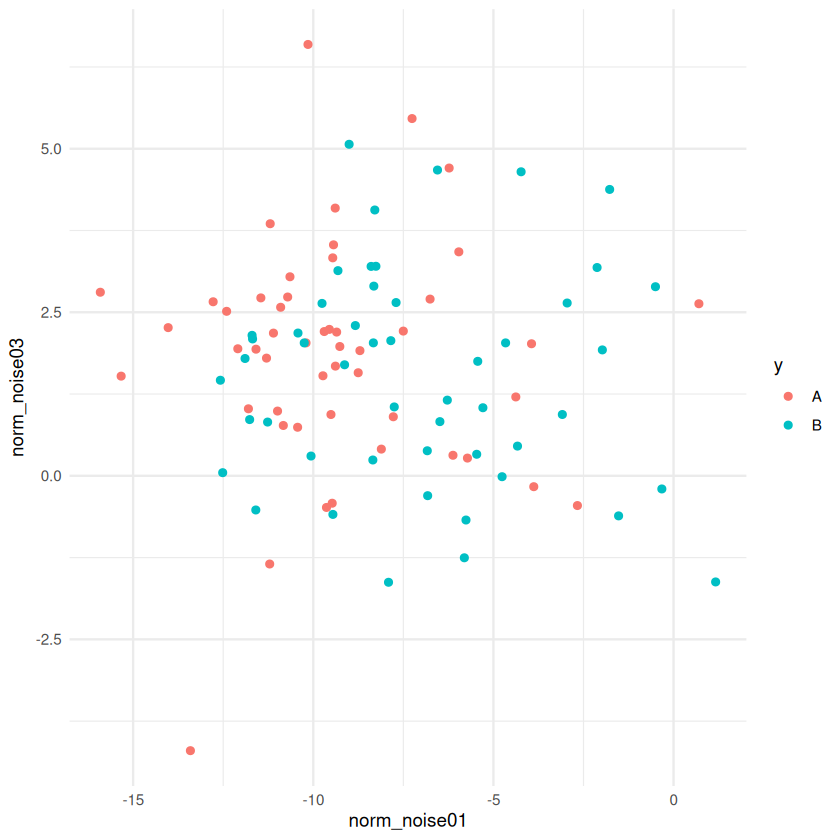

In [158]:
# Create scatter plot
library(ggplot2)
ggplot(df3_short, aes(x=norm_noise01, y=norm_noise03, color=as.factor(y))) +
  geom_point() +
  labs(x="norm_noise01", y="norm_noise03", color="y") +
  theme_minimal()


In [ ]:
xaires_fipv

In [99]:
# Installer et charger le package neuralnet si nécessaire
if (!require(neuralnet)) install.packages("neuralnet")
library(neuralnet)

# Fixer la graine pour la reproductibilité
set.seed(123)

# Générer des données simulées
n_samples <- 100   # nombre d'échantillons
n_features <- 10   # nombre de variables

# Génération d'une matrice de données aléatoires
X <- matrix(rnorm(n_samples * n_features), n_samples, n_features)

# Création d'une variable cible binaire (0 ou 1) basée sur la somme des 3 premières variables + bruit
y <- ifelse(rowSums(X[, 1:3]) + rnorm(n_samples) > 0, 1, 0)

# Combinaison des données dans un data frame
df <- as.data.frame(X)
colnames(df) <- paste0("Var", 1:n_features)
df$y <- y

df <- df3_short
#df <- df[,setdiff(colnames(df), "diff_distrib01")]
#df <- df[,setdiff(colnames(df), "diff_distrib02")]
df$y <- as.factor(df$y)
df$y <- as.numeric(df$y) - 1

# Création de la formule pour neuralnet : Class ~ Var1 + Var2 + ... + Var10

formula_nn <- as.formula("y ~ .")

# Entraînement du MLP avec 2 couches cachées :
# Par exemple, 5 neurones dans la première couche et 3 neurones dans la deuxième couche
nn_model <- neuralnet(formula = formula_nn, 
                      data = df, 
                      hidden = c(5, 3), 
                      linear.output = FALSE)

# Visualisation du réseau de neurones
plot(nn_model)

# display(df)
my_cols <- setdiff(colnames(df), "y")
display(my_cols)
# Prédiction sur le jeu de données d'entraînement
pred <- compute(nn_model, df[, my_cols])
pred_class <- ifelse(pred$net.result > 0.5, 1, 0)

# Affichage de la matrice de confusion
conf_matrix <- table(Predicted = pred_class, Actual = df$y)
print(conf_matrix)




,y,norm_noise01,norm_noise02,norm_noise03,norm_noise04,norm_noise05,norm_noise06,norm_noise07,norm_noise08,norm_noise09,norm_noise10,relVar01,relVar02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,-6.7579263,-3.3814362,2.7013842,6.917487,3.64788335,-8.74980989,10.115755,-3.0977427,3.1188930,-1.8705430,0.9673809,1.2546637
2,0,-3.9421022,-5.6959226,2.0186768,5.683056,7.16002415,0.27518974,5.146080,-12.2983169,6.8702181,-8.1007842,1.3506439,2.4085396
3,0,-15.9105346,-7.0131123,2.8061961,5.948519,0.22929788,-0.33870109,9.230829,2.2621149,6.5701204,0.3842239,0.9979927,2.1829127
4,0,-6.2286309,-2.9702398,4.7048867,9.836800,1.84807022,-2.00218335,6.121042,0.7368492,2.2050291,-4.6985806,1.8341190,3.1074023
5,0,-5.9602028,-7.2991950,3.4237093,6.053884,3.03548390,-6.64634415,7.567280,-8.7317536,1.7469672,-6.3653033,2.1466563,1.2896283
6,0,-9.7313131,-2.9653699,1.5290590,8.274682,-0.53834062,-5.67347703,8.226735,-5.7947500,12.0439163,-4.3746243,2.6020565,1.9421976
7,0,-9.6332383,-2.2048980,-0.4838893,9.574972,2.47304626,-1.97982971,7.568825,-8.3569630,3.6532212,6.1100186,2.5290555,2.3449234
8,0,-9.6954163,-3.8622655,2.2053462,7.688326,1.33758566,2.71713217,4.549246,-12.5105474,4.3084853,-11.1962031,3.4456958,3.2726544
9,0,-10.8314496,-4.4478561,0.7694095,6.100200,-2.52213782,-3.55257652,6.358794,-19.7670519,4.1072515,-4.4829943,2.5973093,1.8226192


[1] "norm_noise01" "norm_noise02" "norm_noise03" "norm_noise04" "norm_noise05"
 [6] "norm_noise06" "norm_noise07" "norm_noise08" "norm_noise09" "norm_noise10"
[11] "relVar01"     "relVar02"

         Actual
Predicted  0  1
        0 50  0
        1  0 50


In [300]:
# Installer et charger le package neuralnet si nécessaire
if (!require(neuralnet)) install.packages("neuralnet")
library(neuralnet)

# Fixer la graine pour la reproductibilité
#set.seed(1234)

df <- df3
df$y <- as.factor(df$y)
df$y <- as.numeric(df$y) - 1

df_train <- df[c(1:25, 76:100),]
# sample y
df_train$y <- sample(df_train$y)

df_test <- df[c(26:75),]
df_test$y <- sample(df_test$y)

# Création de la formule pour neuralnet : Class ~ Var1 + Var2 + ... + Var10

formula_nn <- as.formula("y ~ .")

# Entraînement du MLP avec 2 couches cachées :
# Par exemple, 5 neurones dans la première couche et 3 neurones dans la deuxième couche
nn_model <- neuralnet(formula = formula_nn, 
                      data = df_train,
                      hidden = c(8, 4), 
                      linear.output = FALSE)
                      
importance_table <- NeuralNetTools::olden(nn_model, bar_plot = FALSE)

predict(nn_model, df_test[, setdiff(colnames(df_test), "y")])[,1]

pred_wrapper <- function(object, newdata) {
    predict(object, newdata = newdata)[, 1]
}

shap_values <- explain(nn_model, X = df_test[, setdiff(colnames(df_test), "y")], pred_wrapper = pred_wrapper, nsim = 100)


# Affichage des premières lignes des valeurs SHAP
print(colMeans(abs(shap_values)))
# Affichage du tableau d'importance
print(importance_table)

26           27           28           29           30           31 
0.0001828669 0.0170294461 0.0001607530 0.0001567271 0.2740344506 0.6099436917 
          32           33           34           35           36           37 
0.9040615074 0.1110409671 0.9925400343 0.0001346794 0.0001893941 0.8156835165 
          38           39           40           41           42           43 
0.9880065713 0.9869490693 0.5941248838 0.9043759189 0.9711643853 0.9920903975 
          44           45           46           47           48           49 
0.0009151006 0.0003454904 0.5930932638 0.9923701552 0.1214160073 0.0067627277 
          50           51           52           53           54           55 
0.0397039750 0.9888129362 0.9793751928 0.9535103959 0.9961261211 0.9933834941 
          56           57           58           59           60           61 
0.9952960270 0.9962588653 0.9961953073 0.9873921536 0.9936534836 0.3869604245 
          62           63           64           65           66           67 
0.9962723639 0.0002071569 0.9962723394 0.9209894091 0.8522386515 0.9942417668 
          68           69           70           71           72           73 
0.9962701345 0.9962687578 0.9962711500 0.0460620767 0.9961559885 0.9931167942 
          74           75 
0.9886975845 0.9935023428

  norm_noise01   norm_noise02   norm_noise03   norm_noise04   norm_noise05 
    0.03592611     0.02463201     0.02163382     0.03755518     0.03325347 
  norm_noise06   norm_noise07   norm_noise08   norm_noise09   norm_noise10 
    0.09106031     0.02069671     0.02945042     0.05875364     0.08106661 
diff_distrib01 diff_distrib02       relVar01       relVar02 
    0.04925922     0.11552900     0.03542442     0.14318406 
                 importance
norm_noise01    -52.4019769
norm_noise02      0.3322099
norm_noise03    105.8769584
norm_noise04    109.7028305
norm_noise05     75.1595516
norm_noise06   -302.0960132
norm_noise07    123.2777539
norm_noise08    -73.9176497
norm_noise09   -111.8763008
norm_noise10    -33.9241522
diff_distrib01   20.1204129
diff_distrib02 -119.3553845
relVar01       -285.1764448
relVar02        329.6340005


In [257]:
predict(nn_model, df_test[, setdiff(colnames(df_test), "y")])

26,0.998509134
27,0.998496759
28,0.997733360
29,0.997700005
30,0.998470799
31,0.998034360
32,0.997611127
33,0.998513935
34,0.998414587
35,0.998417974
36,0.998508820


In [11]:
# Installer et charger les packages nécessaires
if (!requireNamespace("randomForest", quietly = TRUE)) install.packages("randomForest")
if (!requireNamespace("fastshap", quietly = TRUE)) install.packages("fastshap")
library(randomForest)
library(fastshap)

# Génération de données simulées
set.seed(123)
n <- 200    # nombre d'observations
p <- 5      # nombre de variables prédictives
X <- data.frame(matrix(rnorm(n * p), nrow = n))
names(X) <- paste0("X", 1:p)
y <- with(X, 3 * X1 - 2 * X2 + rnorm(n))
data <- data.frame(y = y, X)

# Ajustement d'un modèle Random Forest
rf_model <- randomForest(y ~ ., data = data)

# Calcul des valeurs SHAP avec fastshap en spécifiant la fonction de prédiction
shap_values <- explain(rf_model, X = data[, -1], pred_wrapper = predict, nsim = 100)

# Affichage des premières lignes des valeurs SHAP
print(head(shap_values))

# Calcul de l'importance des variables en prenant la moyenne des valeurs absolues des SHAP
shap_importance <- colMeans(abs(shap_values))
print(shap_importance)


          X1         X2          X3          X4         X5
1 -1.6075062 -2.8189268 -0.34942214 -0.46512968 -0.3356404
2 -1.0899206 -1.8533612 -0.14347560 -0.07326237 -0.2261181
3  3.0819169  1.0076625  0.19975299  0.22460206  0.1614697
4  0.4315166 -0.9498230 -0.05527562  0.01241392 -0.2322762
5  0.4657755  0.5714677 -0.17956926 -0.28793977 -0.2785743
6  3.1190309  1.4508178  0.43054590  0.27330281  0.1360959
       X1        X2        X3        X4        X5 
1.6126444 1.1244310 0.1654415 0.1630570 0.2014211 


In [18]:
# Installer et charger les packages nécessaires
if (!requireNamespace("randomForest", quietly = TRUE)) install.packages("randomForest")
if (!requireNamespace("fastshap", quietly = TRUE)) install.packages("fastshap")
library(randomForest)
library(fastshap)

# Génération de données simulées pour la classification
set.seed(123)
n <- 200    # nombre d'observations
p <- 5      # nombre de variables prédictives
X <- data.frame(matrix(rnorm(n * p), nrow = n))
names(X) <- paste0("X", 1:p)

# Création d'une variable réponse binaire (A ou B) basée sur X1
y <- ifelse(X$X1 + rnorm(n) > 0, "A", "B")
data <- data.frame(y = factor(y, levels = c("A", "B")), X)

# Ajustement d'un modèle Random Forest pour la classification
rf_model <- randomForest(y ~ ., data = data)

# Définition d'une fonction de prédiction qui renvoie la probabilité de la classe "A"
pred_wrapper <- function(object, newdata) {
  predict(object, newdata = newdata, type = "prob")[, "A"]
}

# Calcul des valeurs SHAP avec fastshap en spécifiant la fonction de prédiction
shap_values <- explain(rf_model, X = data[, -1], pred_wrapper = pred_wrapper, nsim = 100)

# Affichage des premières lignes des valeurs SHAP
print(head(shap_values))

# Calcul de l'importance des variables en prenant la moyenne des valeurs absolues des SHAP
shap_importance <- colMeans(abs(shap_values))
print(shap_importance)


        X1       X2       X3       X4       X5
1 -0.23182 -0.00976 -0.03566 -0.00792 -0.07890
2 -0.04926 -0.02668 -0.13244 -0.05122 -0.05554
3  0.40348  0.01846  0.01394 -0.00568 -0.00486
4 -0.05212 -0.09914 -0.06138 -0.05184 -0.05886
5  0.05088 -0.04058 -0.04432 -0.02876 -0.08620
6  0.43502  0.05432 -0.04448  0.01034 -0.01860
       X1        X2        X3        X4        X5 
0.2055943 0.0462969 0.0558652 0.0374405 0.0534610 


In [12]:
shap_importance["X1"]

X1 
1.612644

In [105]:
 install.packages("../0047_thesis_axis2/XAItest_0.99.25.tar.gz")

Installing package into ‘/home/gui/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

inferring 'repos = NULL' from 'pkgs'



In [5]:
# Charger les packages nécessaires
library(nnet)

# Assurez-vous que la variable cible est un facteur
df3_short$y <- as.factor(df3_short$y)

# Fixer la graine pour la reproductibilité
set.seed(123)

# Créer un split train/test (par exemple 70% train, 30% test)
n <- nrow(df3_short)
train_idx <- sample(seq_len(n), size = floor(0.5 * n))
train_data <- df3_short[train_idx, ]
test_data  <- df3_short[-train_idx, ]

# Entraîner un MLP (réseau de neurones à une couche cachée)
# Ici, size=5 correspond à 5 neurones dans la couche cachée.
# maxit fixe le nombre maximal d'itérations et decay permet de régulariser le modèle.
mlp_model <- nnet(y ~ ., 
                  data = train_data, 
                  size = 2, 
                  maxit = 200, 
                  decay = 0.1, 
                  trace = FALSE)

# Faire des prédictions sur l'ensemble test
# type = "class" retourne la classe prédite
predictions <- predict(mlp_model, newdata = test_data, type = "class")

# Calculer l'accuracy : proportion de prédictions correctes
accuracy <- mean(predictions == test_data$y)
cat("Test accuracy:", round(accuracy * 100, 2), "%\n")


Test accuracy: 50 %


In [109]:
colnames(df3_short)

[1] "y"            "norm_noise01" "norm_noise02" "norm_noise03" "norm_noise04"
 [6] "norm_noise05" "norm_noise06" "norm_noise07" "norm_noise08" "norm_noise09"
[11] "norm_noise10" "relVar01"     "relVar02"

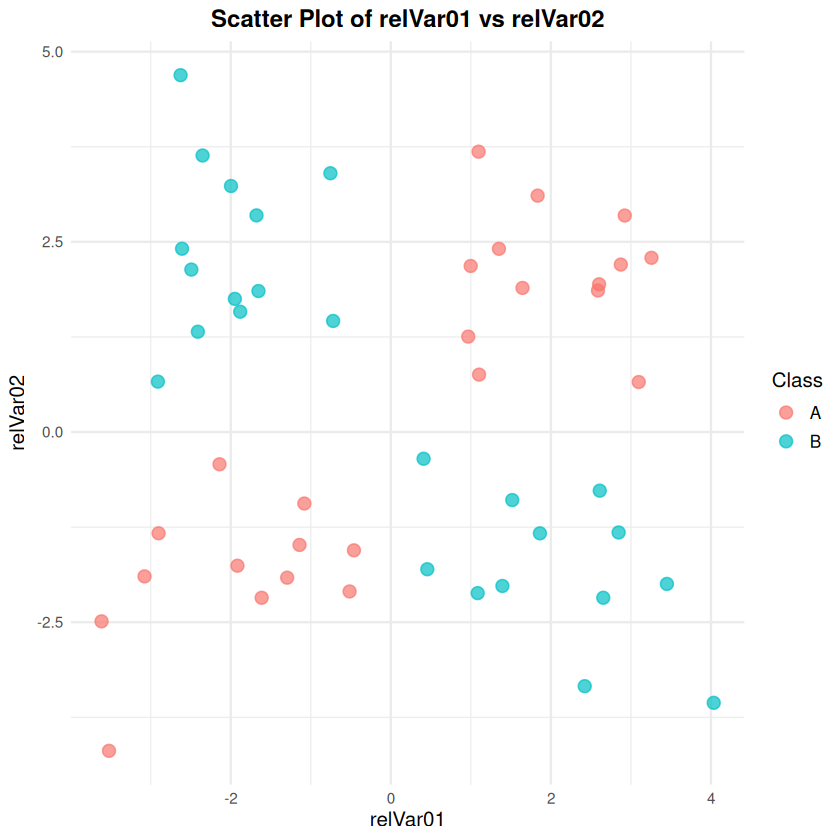

In [118]:
# Load ggplot2 package for visualization
library(ggplot2)

# Create a scatter plot of relVar01 vs relVar02 with points colored by y
ggplot(test_data, aes(x = relVar01, y = relVar02, color = y)) +
  geom_point(size = 3, alpha = 0.7) +
  #scale_color_manual(values = c("0" = "blue", "1" = "red")) +
  labs(
    title = "Scatter Plot of relVar01 vs relVar02",
    x = "relVar01",
    y = "relVar02",
    color = "Class"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )


In [116]:
library(e1071)

# SVM avec noyau RBF (radial)
svm_rbf <- svm(y ~ ., data = train_data, kernel = "radial", cost = 1, gamma = 0.1)

pred_rbf <- predict(svm_rbf, newdata = test_data)
accuracy_rbf <- mean(pred_rbf == test_data$y)
accuracy_rbf


[1] 0.62

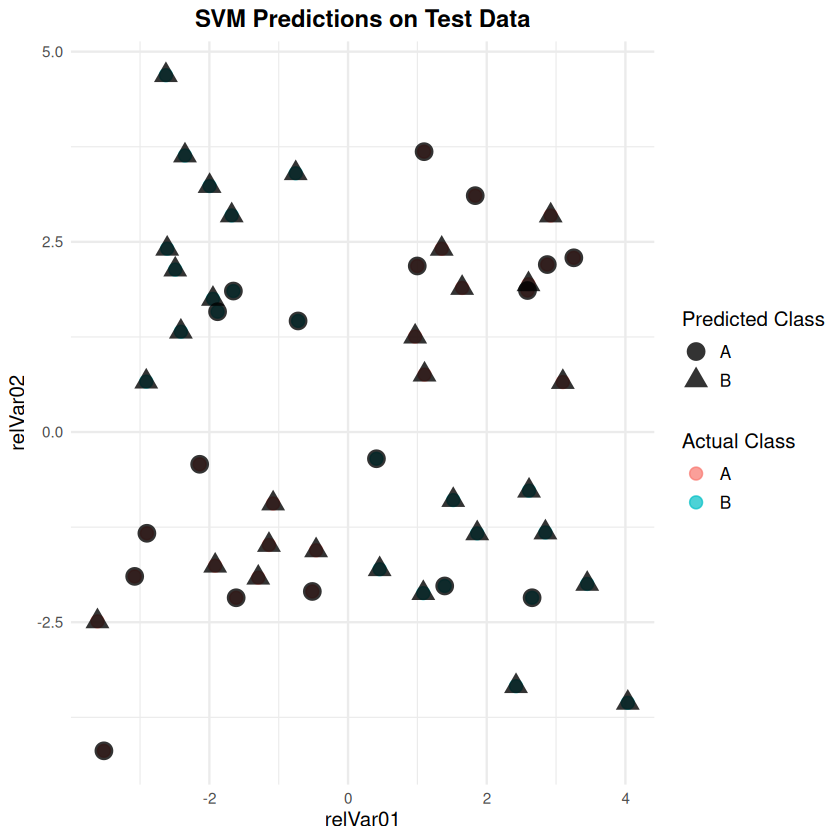

SVM with RBF kernel accuracy: 62 %


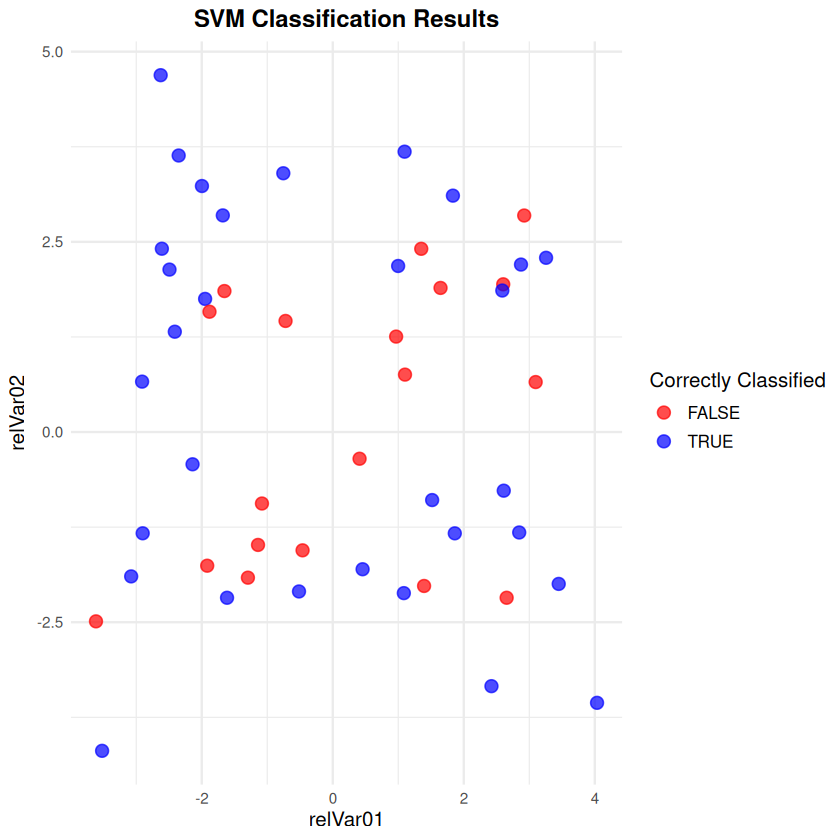

In [117]:
# Create a dataframe with test data and predictions
test_predictions <- data.frame(
  relVar01 = test_data$relVar01,
  relVar02 = test_data$relVar02,
  actual = test_data$y,
  predicted = pred_rbf
)

# Create a scatter plot showing actual vs predicted classes
ggplot() +
  # Plot actual classes with filled circles
  geom_point(data = test_predictions, 
             aes(x = relVar01, y = relVar02, color = actual),
             size = 3, alpha = 0.7) +
  # Plot predicted classes with hollow circles
  geom_point(data = test_predictions, 
             aes(x = relVar01, y = relVar02, shape = predicted),
             size = 4, alpha = 0.8, stroke = 1.5) +
  # Customize the plot appearance
  labs(
    title = "SVM Predictions on Test Data",
    x = "relVar01",
    y = "relVar02",
    color = "Actual Class",
    shape = "Predicted Class"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )

# Create a second plot showing misclassifications
test_predictions$correct <- test_predictions$actual == test_predictions$predicted

ggplot(test_predictions, aes(x = relVar01, y = relVar02, color = correct)) +
  geom_point(size = 3, alpha = 0.7) +
  scale_color_manual(values = c("FALSE" = "red", "TRUE" = "blue")) +
  labs(
    title = "SVM Classification Results",
    x = "relVar01",
    y = "relVar02",
    color = "Correctly Classified"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )

# Print accuracy as percentage
cat("SVM with RBF kernel accuracy:", round(accuracy_rbf * 100, 2), "%\n")


In [123]:
library(class)

# Préparation
train_x <- train_data[, setdiff(names(train_data), "y")]
train_y <- train_data$y
test_x  <- test_data[, setdiff(names(test_data), "y")]
test_y  <- test_data$y

# k-NN avec k=5 (par exemple)
pred_knn <- knn(train_x, test_x, cl = train_y, k = 20)
accuracy_knn <- mean(pred_knn == test_y)
accuracy_knn


[1] 0.58

In [130]:
library(randomForest)

rf_model <- randomForest(y ~ ., data = train_data, ntree = 100)
pred_rf <- predict(rf_model, newdata = test_data)
accuracy_rf <- mean(pred_rf == test_data$y)
accuracy_rf

[1] 0.54

In [131]:
library(nnet)

mlp_model <- nnet(y ~ ., data = train_data,
                  size = 10,      # plus de neurones
                  maxit = 1000,   # plus d'itérations
                  decay = 0.001,  # régularisation
                  trace = FALSE)

pred_mlp <- predict(mlp_model, newdata = test_data, type = "class")
accuracy_mlp <- mean(pred_mlp == test_data$y)
accuracy_mlp


[1] 0.58

In [22]:
# Installer et charger keras si nécessaire
# install.packages("keras")
library(keras)

# On suppose que df3_short est déjà chargé, avec 100 lignes x 13 colonnes,
# et que la colonne "y" correspond à la variable de classe.
temp_df <- df3_short
temp_df$y <- as.factor(temp_df$y)
# Scale all columns except 'y'
# First, identify all columns except 'y'
cols_to_scale <- setdiff(names(temp_df), "y")

# Apply scaling to those columns
temp_df[cols_to_scale] <- scale(temp_df[cols_to_scale])

# Verify the scaling worked by checking means and standard deviations
# The means should be approximately 0 and standard deviations approximately 1
col_means <- colMeans(temp_df[cols_to_scale])
col_sds <- apply(temp_df[cols_to_scale], 2, sd)
print("Means after scaling:")
print(col_means)
print("Standard deviations after scaling:")
print(col_sds)


# Fixer la graine pour la reproductibilité
set.seed(123)

# Création d'un split train/test (70% train, 30% test)
n <- nrow(temp_df)
train_idx <- sample(seq_len(n), size = floor(0.7 * n))
train_data <- temp_df[train_idx, ]
test_data  <- temp_df[-train_idx, ]

# Préparation des données :
# Séparer les variables explicatives et la variable cible
X_train <- as.matrix(train_data[, setdiff(names(train_data), "y")])
X_test  <- as.matrix(test_data[, setdiff(names(test_data), "y")])

# Pour le modèle Keras, il faut encoder la variable cible en one-hot
num_classes <- length(levels(temp_df$y))
# Convertir les classes en indices (commençant par 0)
y_train <- as.integer(train_data$y) - 1  
y_test  <- as.integer(test_data$y) - 1

# Encodage one-hot
y_train_cat <- to_categorical(y_train, num_classes = num_classes)
y_test_cat  <- to_categorical(y_test, num_classes = num_classes)

# Construction du modèle MLP
model <- keras_model_sequential() %>%
  # Première couche cachée avec 4 neurones et activation ReLU
  layer_dense(units = 16, activation = "relu", input_shape = ncol(X_train)) %>%
  # Dropout classique (20% des neurones désactivés aléatoirement)
  layer_dropout(rate = 0.2) %>%
  # Deuxième couche cachée avec 2 neurones et activation ReLU
  layer_dense(units = 8, activation = "relu") %>%
    layer_dropout(rate = 0.2) %>%
    
  # Deuxième couche cachée avec 2 neurones et activation ReLU

  # Couche de sortie : softmax pour la classification multi-classes
  layer_dense(units = num_classes, activation = "softmax")

# Compilation du modèle
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adam(),
  metrics = c("accuracy")
)

# Affichage de la structure du modèle
summary(model)

# Entraînement du modèle
history <- model %>% fit(
  X_train, y_train_cat,
  epochs = 100,          # ajustez le nombre d'epochs selon vos besoins
  batch_size = 32,       # ajustez la taille de batch
  validation_split = 0.2,
  verbose = 1
)

# Évaluation sur l'ensemble de test
score <- model %>% evaluate(X_test, y_test_cat)
score
# display scatter plots of prediction on
a(15,5)
b()

[1] "Means after scaling:"
 norm_noise01  norm_noise02  norm_noise03  norm_noise04  norm_noise05 
-1.200429e-17  5.308254e-18  1.657528e-17  1.977585e-17  3.001072e-17 
 norm_noise06  norm_noise07  norm_noise08  norm_noise09  norm_noise10 
 3.080869e-17  6.588046e-17  4.021089e-17  8.916479e-18 -6.661338e-18 
     relVar01      relVar02 
-2.040035e-17  1.831868e-17 
[1] "Standard deviations after scaling:"
norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           1            1            1            1            1            1 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           1            1            1            1            1            1 


Model: "sequential_9"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_29 (Dense)                   (None, 16)                      208         
 dropout_19 (Dropout)               (None, 16)                      0           
 dense_28 (Dense)                   (None, 8)                       136         
 dropout_18 (Dropout)               (None, 8)                       0           
 dense_27 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


loss  accuracy 
0.6354435 0.6000000

ERROR: Error in b(): could not find function "b"


In [10]:
# Installer et charger keras si nécessaire
# install.packages("keras")
# my_keras 
library(keras)

# On suppose que df3_short est déjà chargé, avec 100 lignes x 13 colonnes,
# et que la colonne "y" correspond à la variable de classe.
temp_df <- df3_short
temp_df$y <- as.factor(temp_df$y)
# Scale all columns except 'y'
# First, identify all columns except 'y'
cols_to_scale <- setdiff(names(temp_df), "y")

# Apply scaling to those columns
temp_df[cols_to_scale] <- scale(temp_df[cols_to_scale])

# Verify the scaling worked by checking means and standard deviations
# The means should be approximately 0 and standard deviations approximately 1
col_means <- colMeans(temp_df[cols_to_scale])
col_sds <- apply(temp_df[cols_to_scale], 2, sd)
print("Means after scaling:")
print(col_means)
print("Standard deviations after scaling:")
print(col_sds)


# Fixer la graine pour la reproductibilité
set.seed(123)

# Création d'un split train/test (70% train, 30% test)
n <- nrow(temp_df)
train_idx <- sample(seq_len(n), size = floor(0.7 * n))
train_data <- temp_df[train_idx, ]
test_data  <- temp_df[-train_idx, ]

# Préparation des données :
# Séparer les variables explicatives et la variable cible
X_train <- as.matrix(train_data[, setdiff(names(train_data), "y")])
X_test  <- as.matrix(test_data[, setdiff(names(test_data), "y")])

# Pour le modèle Keras, il faut encoder la variable cible en one-hot
num_classes <- length(levels(temp_df$y))
# Convertir les classes en indices (commençant par 0)
y_train <- as.integer(train_data$y) - 1  
y_test  <- as.integer(test_data$y) - 1

# Encodage one-hot
y_train_cat <- to_categorical(y_train, num_classes = num_classes)
y_test_cat  <- to_categorical(y_test, num_classes = num_classes)

# Construction du modèle MLP
model <- keras_model_sequential() %>%
  # Première couche cachée avec 4 neurones et activation ReLU
  layer_dense(units = 16, activation = "relu", input_shape = ncol(X_train)) %>%
  # Dropout classique (20% des neurones désactivés aléatoirement)
  layer_dropout(rate = 0.2) %>%
  # Deuxième couche cachée avec 2 neurones et activation ReLU
  layer_dense(units = 8, activation = "relu") %>%
    layer_dropout(rate = 0.2) %>%
    
  # Deuxième couche cachée avec 2 neurones et activation ReLU

  # Couche de sortie : softmax pour la classification multi-classes
  layer_dense(units = num_classes, activation = "softmax")

# Compilation du modèle
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adam(),
  metrics = c("accuracy")
)

# Affichage de la structure du modèle
summary(model)

# Entraînement du modèle
history <- model %>% fit(
  X_train, y_train_cat,
  epochs = 5000,          # ajustez le nombre d'epochs selon vos besoins
  batch_size = 32,       # ajustez la taille de batch
  validation_split = 0.2,
  verbose = 1
)

# Évaluation sur l'ensemble de test
score <- model %>% evaluate(X_test, y_test_cat)
score
# display scatter plots of prediction on
a(15,5)
b()

[1] "Means after scaling:"
 norm_noise01  norm_noise02  norm_noise03  norm_noise04  norm_noise05 
-1.200429e-17  5.308254e-18  1.657528e-17  1.977585e-17  3.001072e-17 
 norm_noise06  norm_noise07  norm_noise08  norm_noise09  norm_noise10 
 3.080869e-17  6.588046e-17  4.021089e-17  8.916479e-18 -6.661338e-18 
     relVar01      relVar02 
-2.040035e-17  1.831868e-17 
[1] "Standard deviations after scaling:"
norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
           1            1            1            1            1            1 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
           1            1            1            1            1            1 


Model: "sequential_6"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_20 (Dense)                   (None, 16)                      208         
 dropout_13 (Dropout)               (None, 16)                      0           
 dense_19 (Dense)                   (None, 8)                       136         
 dropout_12 (Dropout)               (None, 8)                       0           
 dense_18 (Dense)                   (None, 2)                       18          
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


loss  accuracy 
7.0185251 0.6666667

ERROR: Error in b(): could not find function "b"


In [24]:
# Si fastshap n'est pas installé, décommentez la ligne suivante :
# install.packages("fastshap")
library(fastshap)
library(ggplot2)

# Définir une fonction de prédiction pour le modèle Keras.
# Ici, on récupère la probabilité de la première classe.
pred_fun <- function(object, newdata) {
  # predict renvoie une matrice de probabilités pour chaque classe,
  # ici on sélectionne la première colonne.
  predict(object, newdata)[, 1]
}

# Calculer les valeurs SHAP approximatives avec fastshap.
# 'nsim' correspond au nombre de simulations Monte Carlo pour l'approximation.
set.seed(123)
shap_values <- fastshap::explain(
  object = model,      # Votre modèle Keras
  X = X_train,         # Jeu de données d'entraînement (matrice)
  pred_wrapper = pred_fun,
  nsim = 5          # Augmentez nsim pour une estimation plus précise
)

# Calculer l'importance des features comme la moyenne des valeurs absolues des SHAP values
feature_importance <- colMeans(abs(shap_values))
print("Importance des features (moyenne des valeurs absolues des SHAP) :")
print(feature_importance)



[1] "Importance des features (moyenne des valeurs absolues des SHAP) :"
norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
  0.06689423   0.03005597   0.01750779   0.04060525   0.03069149   0.03374703 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
  0.02764321   0.03801069   0.04850297   0.05126205   0.04362158   0.03906485 


In [14]:
        shap_values <- fastshap::explain(model, X = X_test, pred_wrapper = evaluate, nsim = 4)
        shap_values <- colMeans(abs(shap_values))
        shap_values

ERROR: Error in {: task 1 failed - "ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>
Run `reticulate::py_last_error()` for details."


In [56]:
# Extraire les poids du modèle Keras
weights <- model %>% get_weights()

# Vérifiez la structure des poids
# Par exemple, avec summary(weights[[1]]), summary(weights[[3]]), summary(weights[[5]])
# On suppose :
# W1 : weights[[1]]  -> dimensions : nb_features x 16
# W2 : weights[[3]]  -> dimensions : 16 x 8
# W3 : weights[[5]]  -> dimensions : 8 x num_classes

W1 <- weights[[1]]
W2 <- weights[[3]]
W3 <- weights[[5]]

n_features <- dim(W1)[1]
n_hidden1 <- dim(W1)[2]  # 16
n_hidden2 <- dim(W2)[2]  # 8
n_outputs <- dim(W3)[2]  # num_classes

# Initialiser un vecteur pour stocker l'importance de chaque feature
feature_importance <- rep(0, n_features)

# Pour chaque feature, on somme les contributions absolues de tous les chemins menant aux sorties
for (i in 1:n_features) {
  for (j in 1:n_hidden1) {
    for (k in 1:n_hidden2) {
      for (l in 1:n_outputs) {
        feature_importance[i] <- feature_importance[i] + abs(W1[i, j] * W2[j, k] * W3[k, l])
      }
    }
  }
}

# Donner des noms aux variables d'entrée, par exemple en utilisant les colonnes de X_train
names(feature_importance) <- colnames(X_train)

# Afficher les importances calculées
print("Feature importance (méthode Olden approximative) :")
print(feature_importance)


[1] "Feature importance (méthode Olden approximative) :"
norm_noise01 norm_noise02 norm_noise03 norm_noise04 norm_noise05 norm_noise06 
    62.76556     54.56071     32.44394     58.85107     40.91489     53.92813 
norm_noise07 norm_noise08 norm_noise09 norm_noise10     relVar01     relVar02 
    43.43366     35.70496     71.65305     48.67739    107.67014    122.61447 


In [43]:

# Création de deux graphiques pour visualiser les variables relVar01 et relVar02
# avec coloration selon la catégorie prédite (test et train)

b <- function(){

# Obtenir les prédictions du modèle sur les données de test
test_predictions <- model %>% predict(X_test)
test_predicted_classes <- apply(test_predictions, 1, which.max) - 1  # Convertir de one-hot à indices de classe (0-based)

# Obtenir les prédictions du modèle sur les données d'entraînement
train_predictions <- model %>% predict(X_train)
train_predicted_classes <- apply(train_predictions, 1, which.max) - 1  # Convertir de one-hot à indices de classe (0-based)

# Créer des dataframes pour la visualisation
test_viz_df <- data.frame(
  relVar01 = X_test[, "relVar01"],
  relVar02 = X_test[, "relVar02"],
  Category = factor(test_predicted_classes)
)

train_viz_df <- data.frame(
  relVar01 = X_train[, "relVar01"],
  relVar02 = X_train[, "relVar02"],
  Category = factor(train_predicted_classes)
)

# Créer un dataframe pour les données originales de test
original_viz_df <- data.frame(
  relVar01 = X_test[, "relVar01"],
  relVar02 = X_test[, "relVar02"],
  Category = factor(y_test)
)

# Créer les graphiques avec ggplot2
test_plot <- ggplot(test_viz_df, aes(x = relVar01, y = relVar02, color = Category)) +
  geom_point(size = 3, alpha = 0.8) +
  scale_color_manual(values = c("0" = "blue", "1" = "red")) +
  labs(
    title = "Prédictions sur données de test",
    x = "relVar01",
    y = "relVar02",
    color = "Catégorie prédite"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",
    plot.title = element_text(hjust = 0.5)
  )

train_plot <- ggplot(train_viz_df, aes(x = relVar01, y = relVar02, color = Category)) +
  geom_point(size = 3, alpha = 0.8) +
  scale_color_manual(values = c("0" = "blue", "1" = "red")) +
  labs(
    title = "Prédictions sur données d'entraînement",
    x = "relVar01",
    y = "relVar02",
    color = "Catégorie prédite"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",
    plot.title = element_text(hjust = 0.5)
  )

original_plot <- ggplot(original_viz_df, aes(x = relVar01, y = relVar02, color = Category)) +
  geom_point(size = 3, alpha = 0.8) +
  scale_color_manual(values = c("0" = "blue", "1" = "red")) +
  labs(
    title = "Données originales de test",
    x = "relVar01",
    y = "relVar02",
    color = "Catégorie réelle"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",
    plot.title = element_text(hjust = 0.5)
  )

# Afficher les graphiques côte à côte
library(gridExtra)
grid.arrange(test_plot, train_plot, original_plot, ncol = 3)

# Afficher le graphique sans titre dans la console
cat("plot without title\n")
}

plot without title


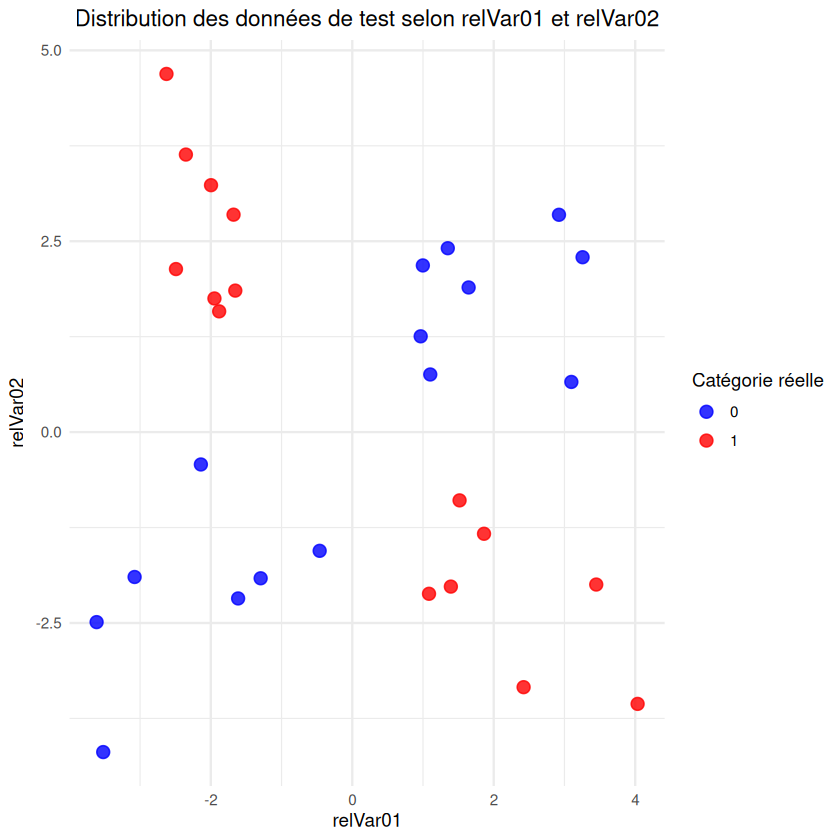

In [16]:
# Création d'un graphique pour visualiser les variables relVar01 et relVar02
# avec coloration selon la catégorie réelle

# Extraire les colonnes relVar01 et relVar02 de X_test
# On suppose que X_test est un dataframe ou une matrice avec des noms de colonnes
# Si X_test n'a pas de noms de colonnes, il faudrait adapter cette partie

# Créer un dataframe pour la visualisation
viz_df <- data.frame(
  relVar01 = X_test[, "relVar01"],
  relVar02 = X_test[, "relVar02"],
  Category = factor(y_test)
)

# Créer le graphique avec ggplot2
ggplot(viz_df, aes(x = relVar01, y = relVar02, color = Category)) +
  geom_point(size = 3, alpha = 0.8) +
  scale_color_manual(values = c("0" = "blue", "1" = "red")) +
  labs(
    title = "Distribution des données de test selon relVar01 et relVar02",
    x = "relVar01",
    y = "relVar02",
    color = "Catégorie réelle"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",
    plot.title = element_text(hjust = 0.5)
  )

# Afficher le graphique sans titre dans la console
cat("plot without title\n")


In [6]:
install_keras()

Using Python: /home/gui/.pyenv/versions/3.10.16/bin/python3.10
Creating virtual environment 'r-tensorflow' ... 


+ /home/gui/.pyenv/versions/3.10.16/bin/python3.10 -m venv /home/gui/.virtualenvs/r-tensorflow



Done!
Installing packages: pip, wheel, setuptools


+ /home/gui/.virtualenvs/r-tensorflow/bin/python -m pip install --upgrade pip wheel setuptools



Virtual environment 'r-tensorflow' successfully created.
Using virtual environment 'r-tensorflow' ...


+ /home/gui/.virtualenvs/r-tensorflow/bin/python -m pip install --upgrade --no-user 'numpy<2' 'tensorflow==2.15.*' tensorflow-hub tensorflow-datasets scipy requests Pillow h5py pandas pydot




Installation complete.



In [133]:
install.packages("keras")

Installing package into ‘/home/gui/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

also installing the dependencies ‘config’, ‘tfautograph’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [137]:
Keras::install_tensorflow()

ERROR: Error in loadNamespace(x): there is no package called ‘Keras’


In [138]:
# install.packages("remotes")
remotes::install_github("rstudio/tensorflow")

jsonlite   (1.8.9  -> 2.0.0 ) [CRAN]
RcppTOML   (0.2.2  -> 0.2.3 ) [CRAN]
reticulate (1.40.0 -> 1.42.0) [CRAN]
ps         (1.8.1  -> 1.9.0 ) [CRAN]
processx   (3.8.5  -> 3.8.6 ) [CRAN]


Installing 5 packages: jsonlite, RcppTOML, reticulate, ps, processx

Installing packages into ‘/home/gui/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpoirXTm/remotesd49d3918abcf/rstudio-tensorflow-e48867f/DESCRIPTION’ ... OK
* preparing ‘tensorflow’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘tensorflow_2.16.0.9000.tar.gz’



Installing package into ‘/home/gui/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [6]:
reticulate::install_python()

Installing pyenv ...
Done! pyenv has been installed to '/home/gui/.local/share/r-reticulate/pyenv/bin/pyenv'.


+ /home/gui/.local/share/r-reticulate/pyenv/bin/pyenv update

+ /home/gui/.local/share/r-reticulate/pyenv/bin/pyenv install --skip-existing 3.10.16



[1] "/home/gui/.pyenv/versions/3.10.16/bin/python3.10"

In [141]:
install.packages("reticulate")

Installing package into ‘/home/gui/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

